## Bibliotecas

In [ ]:
import copy
import glob
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import re
import textwrap
import time
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from typing import Any, Dict, List
from unidecode import unidecode

In [ ]:
# bibliotecas para ML (ordenadas alfabeticamente)
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
import warnings

## Exploração de dados e limpeza

### Importação de bibliotecas e dos excels

In [3]:
# para importar todos os arquivos .xlsx da pasta
arquivos = glob.glob("*.xlsx")

data = pd.concat([pd.read_excel(arquivo)for arquivo in arquivos], ignore_index=True)
pd.set_option('display.max_rows', None)

data.head(5)

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


ID_DELEGACIA ANO_BO  NUM_BO   CIDADE          NOME_DEPARTAMENTO  \
0        10007   2023  HE9099  S.PAULO  DOPE-DEPTO OP POL ESTRAT.   
1        10102   2023  HE1971  S.PAULO                      DECAP   
2        10102   2023  HF5345  S.PAULO                      DECAP   
3        10103   2023  HE1686  S.PAULO                      DECAP   
4        10103   2023  HE6127  S.PAULO                      DECAP   

                    NOME_SECCIONAL                  NOME_DELEGACIA  \
0  DIV.POL.PORTO/AERO/PROT.TURISTA  DOPE - 02ª DP DEATUR CONGONHAS   
1                DEL.SEC.1º CENTRO             02º D.P. BOM RETIRO   
2                DEL.SEC.1º CENTRO             02º D.P. BOM RETIRO   
3                DEL.SEC.1º CENTRO         03º D.P. CAMPOS ELISEOS   
4                DEL.SEC.1º CENTRO         03º D.P. CAMPOS ELISEOS   

  NOME_MUNICIPIO NOME_DEPARTAMENTO_CIRC NOME_SECCIONAL_CIRC  ...  \
0        S.PAULO                  DECAP   DEL.SEC.1º CENTRO  ...   
1        S.PAULO                  DECAP   DEL.SEC.1º CENTRO  ...   
2        S.PAULO                  DECAP   DEL.SEC.1º CENTRO  ...   
3        S.PAULO                  DECAP   DEL.SEC.1º CENTRO  ...   
4        S.PAULO                  DECAP   DEL.SEC.1º CENTRO  ...   

  TIPO DE CRIME/MODUS OPERANDI/MEIO/SUBTRACAO/LOGRADOURO/OBJETO VISADO  \
0                                                NaN                     
1                                                NaN                     
2                                                NaN                     
3                                                NaN                     
4                                                NaN                     

  Unnamed: 47 Unnamed: 48 Unnamed: 49 Unnamed: 50 Unnamed: 51  Unnamed: 52  \
0         NaN         NaN         NaN         NaN         NaN          NaN   
1         NaN         NaN         NaN         NaN         NaN          NaN   
2         NaN         NaN         NaN         NaN         NaN          NaN   
3         NaN         NaN         NaN         NaN         NaN          NaN   
4         NaN         NaN         NaN         NaN         NaN          NaN   

  Unnamed: 53  Unnamed: 54 Unnamed: 55  
0         NaN          NaN         NaN  
1         NaN          NaN         NaN  
2         NaN          NaN         NaN  
3         NaN          NaN         NaN  
4         NaN          NaN         NaN  

[5 rows x 92 columns]

### Pré processamento de dados

In [4]:
#ver o tamanho da tabela
data.shape

(32988, 92)

In [5]:
# ver os tipos das colunas
data.dtypes

ID_DELEGACIA                                                             object
ANO_BO                                                                   object
NUM_BO                                                                   object
CIDADE                                                                   object
NOME_DEPARTAMENTO                                                        object
NOME_SECCIONAL                                                           object
NOME_DELEGACIA                                                           object
NOME_MUNICIPIO                                                           object
NOME_DEPARTAMENTO_CIRC                                                   object
NOME_SECCIONAL_CIRC                                                      object
NOME_DELEGACIA_CIRC                                                      object
NOME_MUNICIPIO_CIRC                                                      object
DATA_OCORRENCIA_BO                      

In [6]:
data.describe()

DIA_REGISTRO_BO  ANO_REGISTRO_BO  NUMERO_LOGRADOURO           CEP       \
count     32984.000000     32987.000000       3.271100e+04  3.184000e+04  0.0   
mean         15.616420      2023.887774       1.691547e+06  1.351189e+06  NaN   
std           8.710086         0.779336       1.241926e+08  1.558642e+06  NaN   
min           1.000000      2023.000000       0.000000e+00  0.000000e+00  NaN   
25%           8.000000      2023.000000       2.600000e+01  1.040010e+06  NaN   
50%          16.000000      2024.000000       1.780000e+02  1.201020e+06  NaN   
75%          23.000000      2025.000000       4.560000e+02  1.219000e+06  NaN   
max          31.000000      2025.000000       1.000000e+10  3.200609e+07  NaN   

        .1   .2   .3   .4   .5  ...   .15   .16   .17   .18   .19  \
count  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   
mean   NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN   
std    NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN   
min    NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN   
25%    NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN   
50%    NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN   
75%    NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN   
max    NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN   

       Unnamed: 48  Unnamed: 49  Unnamed: 50  Unnamed: 51  Unnamed: 52  
count          0.0          0.0          0.0          0.0          0.0  
mean           NaN          NaN          NaN          NaN          NaN  
std            NaN          NaN          NaN          NaN          NaN  
min            NaN          NaN          NaN          NaN          NaN  
25%            NaN          NaN          NaN          NaN          NaN  
50%            NaN          NaN          NaN          NaN          NaN  
75%            NaN          NaN          NaN          NaN          NaN  
max            NaN          NaN          NaN          NaN          NaN  

[8 rows x 29 columns]

In [7]:
# ver quantidade de valores nulos
print(data.isna().sum())

ID_DELEGACIA                                                                1
ANO_BO                                                                      1
NUM_BO                                                                      1
CIDADE                                                                      1
NOME_DEPARTAMENTO                                                           1
NOME_SECCIONAL                                                              1
NOME_DELEGACIA                                                              1
NOME_MUNICIPIO                                                              1
NOME_DEPARTAMENTO_CIRC                                                      1
NOME_SECCIONAL_CIRC                                                         1
NOME_DELEGACIA_CIRC                                                         1
NOME_MUNICIPIO_CIRC                                                         1
DATA_OCORRENCIA_BO                                              

In [8]:
data.columns

Index(['ID_DELEGACIA', 'ANO_BO', 'NUM_BO', 'CIDADE', 'NOME_DEPARTAMENTO',
       'NOME_SECCIONAL', 'NOME_DELEGACIA', 'NOME_MUNICIPIO',
       'NOME_DEPARTAMENTO_CIRC', 'NOME_SECCIONAL_CIRC', 'NOME_DELEGACIA_CIRC',
       'NOME_MUNICIPIO_CIRC', 'DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA_BO',
       'DESCR_PERIODO', 'DATAHORA_REGISTRO_BO', 'DIA_REGISTRO_BO',
       'MÊS_REGISTRO_BO', 'ANO_REGISTRO_BO', 'DATAHORA_IMPRESSAO_BO',
       'FLAG_STATUS', 'RUBRICA', 'CONDUTA', 'DESDOBRAMENTO', 'DESCR_TIPOLOCAL',
       'DESCR_SUBTIPOLOCAL', 'LOGRADOURO', 'NUMERO_LOGRADOURO', 'BAIRRO',
       'LATITUDE', 'LONGITUDE', 'CEP', 'APRESENTACAO', 'PERIODO', 'TIPO LOCAL',
       'TIPO DE CRIME', 'MODUS OPERANDI', 'OBJETO VISADO PELO CRIMINOSO',
       'N_VITIMAS', 'DATA HORA', 'TIPO DE CRIME/LOGRADOURO/OBJETO VISADO',
       'LEGENDA', 'MÊS', 'DIA SEMANA', 'NUM SEMANA', 'NATUREZA ALTERADA PARA',
       'CLASSIFICACAO FINAL', 'CIRCUNSTANCIA', 'DURANTE EVENTO?',
       'TIPO DE EVENTO', 'MEIO DE LOCOMOÇÃO INF

In [9]:
# Lista de colunas a remover 
cols_to_drop = [
    'NOME_MUNICIPIO','NOME_DEPARTAMENTO_CIRC','DATAHORA_REGISTRO_BO','DIA_REGISTRO_BO','MÊS_REGISTRO_BO', 'ANO_REGISTRO_BO',
    'DESDOBRAMENTO','DESCR_TIPOLOCAL','DATA HORA','LEGENDA', 'MÊS', 'RECLAMAÇÃO?', 'PERÍODO', 'Unnamed: 56','Unnamed: 57',
    'Unnamed: 58', ' ', ' .1', ' .2', ' .3', ' .4', ' .5',' .6', ' .7', ' .8', ' .9', ' .10', ' .11', ' .12', ' .13', ' .14',
    ' .15', ' .16', ' .17', ' .18', ' .19','Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50','Unnamed: 51',
    'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54','Unnamed: 55','NUM_BO','CIDADE','NOME_DEPARTAMENTO','NOME_SECCIONAL',
    'NOME_SECCIONAL_CIRC','NOME_MUNICIPIO_CIRC','DESCR_PERIODO', 'DATAHORA_IMPRESSAO_BO', 'FLAG_STATUS','PERIODO',
    'NUM SEMANA', 'NATUREZA ALTERADA PARA', 'CIRCUNSTANCIA', 'DURANTE EVENTO?', 'TIPO DE EVENTO', 'MEIO DE LOCOMOÇÃO INFRATOR',
    'LOCAL DE SUBTRAÇÃO DO OBJETO','TIPO DE CRIME/LOGRADOURO/MODUS_OPERANDI/MEIO/SUBTRACAO/OBJETO VISADO','FLAGRANTE?',
    'CRIME MULTIPLO?','QUEM FEZ A RECUPERAÇÃO?', 'TIPO DE CRIME/MODUS_OPERANDI/MEIO/SUBTRACAO/LOGRADOURO/OBJETO VISADO',
    'CONDUTA','DATA_OCORRENCIA_BO_DATA','CLASSIFICACAO FINAL', 'DESCR_SUBTIPOLOCAL','TIPO DE CRIME/LOGRADOURO/OBJETO VISADO', 'NOME_DELEGACIA', 'NOME_DELEGACIA_CIRC', 'APRESENTACAO','OBJETO RECUPERADO?','CEP', 'N_VITIMAS','TIPO DE CRIME/LOGRADOURO/MODUS OPERANDI/MEIO/SUBTRACAO/OBJETO VISADO','TIPO DE CRIME/MODUS OPERANDI/MEIO/SUBTRACAO/LOGRADOURO/OBJETO VISADO', 'ID_DELEGACIA']

# Remove apenas as colunas que existem no DataFrame
data.drop(columns=[c for c in cols_to_drop if c in data.columns], inplace=True)

In [10]:
novas_colunas = {
    'TIPO LOCAL': 'TIPO_LOCAL', 'TIPO DE CRIME': 'TIPO_CRIME', 'MODUS OPERANDI': 'MODUS_OPERANDI','OBJETO VISADO PELO CRIMINOSO': 'OBJETO_VISADO', 'DIA SEMANA': 'DIA_SEMANA'
}
data.rename(columns=novas_colunas, inplace=True)


In [11]:
# definindo para aparecer todas as colunas
pd.set_option('display.max_columns', None)
data.head(5)

ANO_BO   DATA_OCORRENCIA_BO HORA_OCORRENCIA_BO           RUBRICA  \
0   2023  2023-05-30 00:00:00           19:00:00  Furto (art. 155)   
1   2023  2023-05-30 00:00:00           19:30:00  Furto (art. 155)   
2   2023  2023-05-31 00:00:00           19:04:00  Furto (art. 155)   
3   2023  2023-05-30 00:00:00           13:40:00  Furto (art. 155)   
4   2023  2023-05-30 00:00:00           20:00:00  Roubo (art. 157)   

               LOGRADOURO  NUMERO_LOGRADOURO         BAIRRO LATITUDE  \
0        AVENIDA IPIRANGA              344.0      REPUBLICA  -23.543   
1        RUA DO SEMINARIO                9.0      REPUBLICA -23.5429   
2  PRAÇA MARECHAL DEODORO              376.0  SANTA CECILIA -23.5334   
3  RUA CONSELHEIRO NEBIAS               14.0  SANTA CECILIA -23.5348   
4        AVENIDA IPIRANGA             1235.0      REPUBLICA  -23.543   

  LONGITUDE   TIPO_LOCAL                         TIPO_CRIME  \
0  -46.6412  VIA PUBLICA  SAQUE/MOVIMENTACAO NAO AUTORIZADA   
1  -46.6364  VIA PUBLICA                 FURTO A TRANSEUNTE   
2  -46.6559  VIA PUBLICA                 FURTO A TRANSEUNTE   
3  -46.6463  VIA PUBLICA                 FURTO QUEBRA VIDRO   
4  -46.6412  VIA PUBLICA                 ROUBO A TRANSEUNTE   

                                      MODUS_OPERANDI    OBJETO_VISADO  \
0                           FURTO - NAO ESPECIFICADO  CARTAO BANCARIO   
1                              FURTO - INFRATOR A PE       SO CELULAR   
2           FURTO - INFRATOR DE BICICLETA - TROMBADA       SO CELULAR   
3  FURTO - INFRATOR QUEBROU O VIDRO COM PESSOA NO...       SO CELULAR   
4                          ROUBO - INFRATOR(ES) A PE           OUTROS   

     DIA_SEMANA  
0   TERÇA-FEIRA  
1   TERÇA-FEIRA  
2  QUARTA-FEIRA  
3   TERÇA-FEIRA  
4   TERÇA-FEIRA

In [12]:
# ver quantidade de valores nulos
print(data.isna().sum())

ANO_BO                  1
DATA_OCORRENCIA_BO      1
HORA_OCORRENCIA_BO     11
RUBRICA                 1
LOGRADOURO            277
NUMERO_LOGRADOURO     277
BAIRRO                205
LATITUDE               53
LONGITUDE              53
TIPO_LOCAL            438
TIPO_CRIME              4
MODUS_OPERANDI        203
OBJETO_VISADO           4
DIA_SEMANA              1
dtype: int64


In [13]:
# convertendo a coluna DATA_OCORRENCIA_BO para o tipo datetime
data['DATA_OCORRENCIA_BO'] = pd.to_datetime(data['DATA_OCORRENCIA_BO']).dt.date
data.head()

ANO_BO DATA_OCORRENCIA_BO HORA_OCORRENCIA_BO           RUBRICA  \
0   2023         2023-05-30           19:00:00  Furto (art. 155)   
1   2023         2023-05-30           19:30:00  Furto (art. 155)   
2   2023         2023-05-31           19:04:00  Furto (art. 155)   
3   2023         2023-05-30           13:40:00  Furto (art. 155)   
4   2023         2023-05-30           20:00:00  Roubo (art. 157)   

               LOGRADOURO  NUMERO_LOGRADOURO         BAIRRO LATITUDE  \
0        AVENIDA IPIRANGA              344.0      REPUBLICA  -23.543   
1        RUA DO SEMINARIO                9.0      REPUBLICA -23.5429   
2  PRAÇA MARECHAL DEODORO              376.0  SANTA CECILIA -23.5334   
3  RUA CONSELHEIRO NEBIAS               14.0  SANTA CECILIA -23.5348   
4        AVENIDA IPIRANGA             1235.0      REPUBLICA  -23.543   

  LONGITUDE   TIPO_LOCAL                         TIPO_CRIME  \
0  -46.6412  VIA PUBLICA  SAQUE/MOVIMENTACAO NAO AUTORIZADA   
1  -46.6364  VIA PUBLICA                 FURTO A TRANSEUNTE   
2  -46.6559  VIA PUBLICA                 FURTO A TRANSEUNTE   
3  -46.6463  VIA PUBLICA                 FURTO QUEBRA VIDRO   
4  -46.6412  VIA PUBLICA                 ROUBO A TRANSEUNTE   

                                      MODUS_OPERANDI    OBJETO_VISADO  \
0                           FURTO - NAO ESPECIFICADO  CARTAO BANCARIO   
1                              FURTO - INFRATOR A PE       SO CELULAR   
2           FURTO - INFRATOR DE BICICLETA - TROMBADA       SO CELULAR   
3  FURTO - INFRATOR QUEBROU O VIDRO COM PESSOA NO...       SO CELULAR   
4                          ROUBO - INFRATOR(ES) A PE           OUTROS   

     DIA_SEMANA  
0   TERÇA-FEIRA  
1   TERÇA-FEIRA  
2  QUARTA-FEIRA  
3   TERÇA-FEIRA  
4   TERÇA-FEIRA

In [14]:
# convertendo a coluna 'ANO_BO' para o tipo numérico (inteiro)
data['ANO_BO'] = pd.to_numeric(data['ANO_BO'], errors='coerce').astype('Int64')

In [15]:
data.value_counts(['ANO_BO'])

ANO_BO
2024      12531
2023      12079
2025       8361
2022          2
10            1
Name: count, dtype: int64

In [16]:
# removendo 'ANO_BO' com valor 10
data = data[data['ANO_BO'] != 10]

#### Agrupar por similaridade - coluna: tipo local

In [17]:
#from collections import defaultdict

def normalizar(texto: str) -> str:
    """
    Normaliza texto para comparação:
    coloca em maiúsculo, remove acentos, pontuação e espaços repetidos
    """
    texto_normalizado = unidecode(texto.upper().strip())
    texto_normalizado = re.sub(r"[^A-Z0-9\s]", " ", texto_normalizado)
    texto_normalizado = re.sub(r"\s+", " ", texto_normalizado).strip()
    return texto_normalizado

def similaridade(textos: List[str],
                           ngram_range=(3,5),
                           sim_threshold: float = 0.85) -> csr_matrix:
    """
    Retorna uma matriz de adjacência esparsa (0/1) onde A[i,j]=1 se sim(i,j) >= threshold.
    """
    norm = [normalizar(texto) for texto in textos]

    # Char n-grams capturam variações como acento, plural, hífen etc.
    vec = TfidfVectorizer(analyzer="char_wb", ngram_range=ngram_range, min_df=1)
    X = vec.fit_transform(norm)
    
    # cosine_similarity(X, X) com tf-idf já normalizado = X @ X.T (mas use função p/ robustez)
    similaridade = cosine_similarity(X, X, dense_output=False)
    
    # Aplica limiar
    similaridade = similaridade.tocsr()
    similaridade.data = (similaridade.data >= sim_threshold).astype(int)

    # Garante laços (diagonal = 1) para cada nó pertencer ao seu próprio cluster
    n = similaridade.shape[0]
    similaridade.setdiag(1)
    similaridade.eliminate_zeros()
    return similaridade

def junta_similares(palavra: csr_matrix) -> List[List[int]]:
    """
    Extrai componentes conexos simples via BFS sobre a matriz esparsa binária.
    """
    n = palavra.shape[0]
    visitado = np.zeros(n, dtype=bool)
    clusters = []
    indptr, indices = palavra.indptr, palavra.indices

    for i in range(n):
        if visitado[i]:
            continue
        lista = [i]
        visitado[i] = True
        comp = []
        while lista:
            v = lista.pop()
            comp.append(v)
            for nb in indices[indptr[v]:indptr[v+1]]:
                if not visitado[nb]:
                    visitado[nb] = True
                    lista.append(nb)
        clusters.append(sorted(comp))
    return clusters

def elenca_representante(textos: List[str], sim_submatrix: np.ndarray, idxs: List[int]) -> int:
    """
    Escolhe o 'medoide' do cluster: item com maior soma de similaridades internas.
    """
    if len(idxs) == 1:
        return idxs[0]
    sub = sim_submatrix[np.ix_(idxs, idxs)]
    scores = sub.sum(axis=1)
    return idxs[int(scores.argmax())]

def cluster_strings(textos: List[str],
                    ngram_range=(3,5),
                    sim_threshold: float = 0.85) -> Dict[str, Any]:
    """
    Retorna:
      - clusters: lista de clusters com índices e rótulos originais
      - mapping: dict {texto_original -> representante_do_cluster}
      - representatives: {indice_representante -> texto_representante}
    """
    if not textos:
        return {"clusters": [], "mapping": {}, "representatives": {}}

    # grafo por limiar
    adj = similaridade(textos, ngram_range, sim_threshold)
    comps = junta_similares(adj)

    # Similaridade densa apenas para calcular representante de cada componente
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.feature_extraction.text import TfidfVectorizer
    norm = [normalizar(t) for t in textos]
    vec = TfidfVectorizer(analyzer="char_wb", ngram_range=ngram_range, min_df=1)
    X = vec.fit_transform(norm)
    S_dense = cosine_similarity(X, X)

    reps = {}
    mapping = {}
    clusters_out = []

    for comp in comps:
        rep_idx = elenca_representante(textos, S_dense, comp)
        rep_label = textos[rep_idx]
        reps[rep_idx] = rep_label
        for i in comp:
            mapping[textos[i]] = rep_label
        clusters_out.append({
            "representative": rep_label,
            "members": [textos[i] for i in comp]
        })

    return {
        "clusters": clusters_out,
        "mapping": mapping,
        "representantes": {textos[k]: v for k, v in reps.items()}
    }

# Aplicando a função na coluna 'TIPO_LOCAL'
valores_tipo_local = data['TIPO_LOCAL'].dropna().astype(str).unique().tolist()
resultado = cluster_strings(valores_tipo_local, ngram_range=(3,5), sim_threshold=0.86)

for c in resultado["clusters"]:
    print(f"[REP] {c['representative']}")
    for m in c["members"]:
        print("  -", m)

print("\nMapping (para padronizar valores):")
for k, v in resultado["mapping"].items():
    print(f"{k} -> {v}")

[REP] VIA PUBLICA
  - VIA PUBLICA
  - Via Pública
  - via publica
  - VIA PÚBLICA
  - via PUBLICA
  - VIA PUBLICA 
  - Via pública
  - VIA PÚBLICA

  - VIa Pública
  - via Pública
  - VIA Pública
  - VIA  PUBLICA
  -  VIA PUBLICA
[REP] ESTABELECIMENTO COMERCIAL
  - ESTABELECIMENTO COMERCIAL
  - INTERIOR DE ESTABELECIMENTO COMERCIAL
  - Estabelecimento comercial
  - Estabelecimento Comercial
  - estabelecimento comercial
  - ESTAbelecimento comercial
  - ESTABELECIMENTO COMERCIAL 
  - estABELECIMENTO COMERCIAL
  - ESTABELECIMENT COMERCIAL
  - EStabelecimento comercial
  - estabeLECIMENTO COMERCIAL
  - ESTABELECIMENTO COMERCIAl
  - INTERIO DE ESTABELECIMENTO COMERCIAL
[REP] RESIDENCIA
  - RESIDENCIA
  - Residência
  - residencia
  - REsidência
  - RESIDÊNCIA
  - residência
[REP] SEM INFORMACOES
  - SEM INFORMACOES
[REP] METRO
  - METRO
  - metro
  - METRÔ
[REP] ESTACAO TREM /METRO
  - ESTACAO TREM /METRO
  - ESTACAO TREM/METRO
  - ESTACAO METRO /TREM
  - ESTACAO METRO/TREM
  - ESTACAO TR

##### substituir palavras similares

In [18]:
substituicoes = {
    # VIA PUBLICA
    "VIA PÚBLICA": "VIA PUBLICA",
    "Via Pública": "VIA PUBLICA",
    "via publica": "VIA PUBLICA",
    "via PUBLICA": "VIA PUBLICA",
    "VIA PUBLICA ": "VIA PUBLICA",
    "Via pública": "VIA PUBLICA",
    "VIA PÚBLICA\n": "VIA PUBLICA",
    "VIa Pública": "VIA PUBLICA",
    "via Pública": "VIA PUBLICA",
    "VIA Pública": "VIA PUBLICA",
    "VIA  PUBLICA": "VIA PUBLICA",
    " VIA PUBLICA": "VIA PUBLICA",
    #VIA SPUBLICA
    "VIA SPUBLICA": "VIA PUBLICA",
    # VIA PLUBICA
    "VIA PLUBICA": "VIA PUBLICA",
    # VIA PUBLCIA
    "VIA PUBLCIA": "VIA PUBLICA",
    # VIA PUBLICO
    "VIA PUBLICO": "VIA PUBLICA",
    # SEMA FORO
    "SEMAFORO": "VIA PUBLICA",
    # AREA COMUM
    "AREA COMUM": "VIA PUBLICA",
    "Área Comum": "VIA PUBLICA",
    # VIA
    "VIA": "VIA PUBLICA",
    # Túnel/Viaduto/Ponte
    "Túnel/Viaduto/Ponte": "VIA PUBLICA",
    # Acostamento
    "Acostamento": "VIA PUBLICA",
    # Praia/Balneário
    "Praia/Balneário": "VIA PUBLICA",
    # VIA NPUBLICA
    "VIA NPUBLICA": "VIA PUBLICA",
    # Ciclofaixa
    "Ciclofaixa": "VIA PUBLICA",
    # ESTABELECIMENTO COMERCIAL
    "ESTABELECIMENTO COMERCIAL": "ESTABELECIMENTO COMERCIAL",
    "INTERIOR DE ESTABELECIMENTO COMERCIAL": "ESTABELECIMENTO COMERCIAL",
    "Estabelecimento comercial": "ESTABELECIMENTO COMERCIAL",
    "Estabelecimento Comercial": "ESTABELECIMENTO COMERCIAL",
    "estabelecimento comercial": "ESTABELECIMENTO COMERCIAL",
    "ESTAbelecimento comercial": "ESTABELECIMENTO COMERCIAL",
    "ESTABELECIMENTO COMERCIAL ": "ESTABELECIMENTO COMERCIAL",
    "estABELECIMENTO COMERCIAL": "ESTABELECIMENTO COMERCIAL",
    "ESTABELECIMENT COMERCIAL": "ESTABELECIMENTO COMERCIAL",
    "EStabelecimento comercial": "ESTABELECIMENTO COMERCIAL",
    "estabeLECIMENTO COMERCIAL": "ESTABELECIMENTO COMERCIAL",
    "ESTABELECIMENTO COMERCIAl": "ESTABELECIMENTO COMERCIAL",
    "INTERIO DE ESTABELECIMENTO COMERCIAL": "ESTABELECIMENTO COMERCIAL",# Serralheria
    "Serralheria": "ESTABELECIMENTO COMERCIAL",
    # Madeireira/Marcenaria
    "Madeireira/Marcenaria": "ESTABELECIMENTO COMERCIAL",
    # Banca de Jornais/Revistaria
    "Banca de Jornais/Revistaria": "ESTABELECIMENTO COMERCIAL",
    # ESTABELECIMENTO COMERCIAÇ
    "ESTABELECIMENTO COMERCIAÇ": "ESTABELECIMENTO COMERCIAL",
     # ESTABELECECIMENTO COMERCIAL
    "ESTABELECECIMENTO COMERCIAL": "ESTABELECIMENTO COMERCIAL",
    # shooping
    "shooping": "ESTABELECIMENTO COMERCIAL",
    # Sapataria
    "Sapataria": "ESTABELECIMENTO COMERCIAL",
    # Armazém/Empório
    "Armazém/Empório": "ESTABELECIMENTO COMERCIAL",
    # Gráfica
    "Gráfica": "ESTABELECIMENTO COMERCIAL",
    # MAGAZINE
    "MAGAZINE": "ESTABELECIMENTO COMERCIAL",
    # MARCENARIA
    "MARCENARIA": "ESTABELECIMENTO COMERCIAL",
    # LOCAL DE TRABALHO
    "LOCAL DE TRABALHO": "ESTABELECIMENTO COMERCIAL",
    # Salão de Beleza/Estética
    "Salão de Beleza/Estética": "ESTABELECIMENTO COMERCIAL",
    "SALAO DE BELEZA/ESTETICA": "ESTABELECIMENTO COMERCIAL",
    # INTERIOR DE ACADEMIA
    "INTERIOR DE ACADEMIA": "ESTABELECIMENTO COMERCIAL",
    # Livraria
    "Livraria": "ESTABELECIMENTO COMERCIAL",
    # Posto de Gasolina
    "Posto de Gasolina": "ESTABELECIMENTO COMERCIAL",
    "POSTO DE GASOLINA": "ESTABELECIMENTO COMERCIAL",
    # Joalheria
    "Joalheria": "ESTABELECIMENTO COMERCIAL",
    # ESCRITORIOS
    "ESCRITORIOS": "ESTABELECIMENTO COMERCIAL",
    # MERCADO OXXO
    "MERCADO OXXO": "ESTABELECIMENTO COMERCIAL",
    # FARMACIA
    "FARMACIA": "ESTABELECIMENTO COMERCIAL",
    # INTERIOR DE LOJA
    "INTERIOR DE LOJA": "ESTABELECIMENTO COMERCIAL",
    # ESTABELECIMNETO COMERCIAL
    "ESTABELECIMNETO COMERCIAL ": "ESTABELECIMENTO COMERCIAL",
    # ESTABELCIMENTO COMERCIAL
    "ESTABELCIMENTO COMERCIAL": "ESTABELECIMENTO COMERCIAL",
    # ESTABEELCIMENTO COMERCIAL
    "ESTABEELCIMENTO COMERCIAL ": "ESTABELECIMENTO COMERCIAL",
    # Depósito
    "Depósito": "ESTABELECIMENTO COMERCIAL",
    # Distribuidora
    "Distribuidora": "ESTABELECIMENTO COMERCIAL",
    # Farmácia/Drogaria
    "Farmácia/Drogaria": "ESTABELECIMENTO COMERCIAL",
    "FARMACIA/DROGARIA": "ESTABELECIMENTO COMERCIAL",
    # Floricultura
    "Floricultura": "ESTABELECIMENTO COMERCIAL",
    # Oficina
    "Oficina": "ESTABELECIMENTO COMERCIAL",
    "OFICINA": "ESTABELECIMENTO COMERCIAL",
    # Conveniência
    "Conveniência": "ESTABELECIMENTO COMERCIAL",
    # JOALHERIA/RELOJOARIA
    "JOALHERIA/RELOJOARIA": "ESTABELECIMENTO COMERCIAL",
      # Assistência Técnica
    "Assistência Técnica": "ESTABELECIMENTO COMERCIAL",
    # COMERCIO
    "COMERCIO": "ESTABELECIMENTO COMERCIAL",
     # Lojas
    "Lojas": "ESTABELECIMENTO COMERCIAL",
    "LOJAS": "ESTABELECIMENTO COMERCIAL",
    # Bureau de Serviços
    "Bureau de Serviços": "ESTABELECIMENTO COMERCIAL",
     # Mercado
    "Mercado": "ESTABELECIMENTO COMERCIAL",
    "MERCADO": "ESTABELECIMENTO COMERCIAL",
    # Autopeças
    "Autopeças": "ESTABELECIMENTO COMERCIAL",
    "AUTOPECAS": "ESTABELECIMENTO COMERCIAL",
     # MERCADO DIA
    "MERCADO DIA": "ESTABELECIMENTO COMERCIAL",
  
    # Roupas
    "Roupas": "ESTABELECIMENTO COMERCIAL",
    # INTERIOR DE ESTABELECIMENTO
    "INTERIOR DE ESTABELECIMENTO": "ESTABELECIMENTO COMERCIAL",
    # INTERIOR DE SHOPPING
    "INTERIOR DE SHOPPING": "ESTABELECIMENTO COMERCIAL",
    
    # RESIDENCIA
    "RESIDENCIA": "RESIDENCIAL",
    "Residência": "RESIDENCIAL",
    "residencia": "RESIDENCIAL",
    "REsidência": "RESIDENCIAL",
    "RESIDÊNCIA": "RESIDENCIAL",
    "residência": "RESIDENCIAL",
    # Apartamentos
    "Apartamentos": "RESIDENCIAL",
    "APARTAMENTOS": "RESIDENCIAL",
    # RESIDENCIA/CONDOMINIO
    "RESIDENCIA/CONDOMINIO": "RESIDENCIAL",
    "Condomínio Residêncial": "RESIDENCIAL",
    "CONDOMÍNIO RESIDENCIAL": "RESIDENCIAL",
    "CONDOMÍNIO/RESIDÊNCIA": "RESIDENCIAL",
    # Apartamento
    "Apartamento": "RESIDENCIAL",
    "APARTAMENTO": "RESIDENCIAL",
    # CONDOMINIO
    "CONDOMINIO": "RESIDENCIAL",
    "INTERIOR DE CONDOMINIO": "RESIDENCIAL",
    # Casa
    "Casa": "RESIDENCIAL",
    "CASA": "RESIDENCIAL",
     # INTERIOR DE RESIDENCI
    "INTERIOR DE RESIDENCI": "RESIDENCIAL",
    # INTERIOR DE RESIDENCIA
    "INTERIOR DE RESIDENCIA": "RESIDENCIAL",
    # Casas
    "Casas": "RESIDENCIAL",
    "CASAS": "RESIDENCIAL",
    # MORADIA
    "MORADIA": "RESIDENCIAL",
    # ESTABELECIMENTO RESIDENCIAL
    "ESTABELECIMENTO RESIDENCIAL": "RESIDENCIAL",
    # RESIDENCIAL
    "RESIDENCIAL": "RESIDENCIAL",
    # NAO INFORMADO
    "NAO INFORMADO": "NÃO ESPECIFICADO",
    "NAO INFORMADO ": "NÃO ESPECIFICADO",
    "NÃO INFORMADO": "NÃO ESPECIFICADO",
    # SEM INFORMACOES
    "SEM INFORMACOES": "NÃO ESPECIFICADO",
    # NAO ESPECIFICADO
    "NAO ESPECIFICADO": "NÃO ESPECIFICADO",
    "NAO ESPECIFICADO ": "NÃO ESPECIFICADO",
    "NÃO ESPECIFICADO": "NÃO ESPECIFICADO",
    "NÃO ESPECIFICADO ": "NÃO ESPECIFICADO",
    # LOCAL NÃO ESPECIFICADO
    "LOCAL NÃO ESPECIFICADO": "NÃO ESPECIFICADO",
    "LOCAL NAO ESPECIFICADO": "NÃO ESPECIFICADO",
    # SEM INFORMACAO
    "SEM INFORMACAO": "NÃO ESPECIFICADO",
    "SEM INFORMAÇÃO": "NÃO ESPECIFICADO",
   # Outros
    "Outros": "NÃO ESPECIFICADO",
    "outros": "NÃO ESPECIFICADO",
    "OUTROS": "NÃO ESPECIFICADO",
    "OUtros": "NÃO ESPECIFICADO",
    # SEM INFORMÇÕES
    "SEM INFORMÇÕES": "NÃO ESPECIFICADO",
    "NAO IDENTIFICADO": "NÃO ESPECIFICADO",
    "NÃO IDENTIFICADO ": "NÃO ESPECIFICADO",
    # NAO ESPECIFCADO
    "NAO ESPECIFCADO": "NÃO ESPECIFICADO",
    # nao inmformado
    "nao inmformado": "NÃO ESPECIFICADO",
    # METRO
    "METRO": "METRO/TREM/ONIBUS",
    "metro": "METRO/TREM/ONIBUS",
    "METRÔ": "METRO/TREM/ONIBUS",
    # ESTACAO TREM /METRO
    "ESTACAO TREM /METRO": "METRO/TREM/ONIBUS",
    "ESTACAO TREM/METRO": "METRO/TREM/ONIBUS",
    "ESTACAO METRO /TREM": "METRO/TREM/ONIBUS",
    "ESTACAO METRO/TREM": "METRO/TREM/ONIBUS",
    "ESTACAO TREM/ METRO ": "METRO/TREM/ONIBUS",
    "ESTACAO TREM/METRO ": "METRO/TREM/ONIBUS",
    "ESTACAO TREM / METRO ": "METRO/TREM/ONIBUS",
    "ESTACAO TREM /METRO ": "METRO/TREM/ONIBUS",
    "ESTACAO TREM/ METRO": "METRO/TREM/ONIBUS",
    "ESTACAO DE TREM/METRO ": "METRO/TREM/ONIBUS",
    "estação trem/metro": "METRO/TREM/ONIBUS",
    "ESTACAO TREM METRO": "METRO/TREM/ONIBUS",
    "ESTACAO TREM / METRO": "METRO/TREM/ONIBUS",
    # PONTO DE ONIBUS
    "PONTO DE ONIBUS": "METRO/TREM/ONIBUS",
    # INTERIOR TRANSPORTE PUBLICO
    "INTERIOR DE TRANSPORTE PUBLICO": "METRO/TREM/ONIBUS",
    "TRANSPORTE PUBLICO ": "METRO/TREM/ONIBUS",
    "TRANSPORTE PUBLICO": "METRO/TREM/ONIBUS",
    "transporte publico": "METRO/TREM/ONIBUS",
    "INTERIOR DE TRANSPORTE PUBLICO ": "METRO/TREM/ONIBUS",
    "INTERIOR TRANSPORTE PUBLICO ": "METRO/TREM/ONIBUS",
    "INTERIOR TRANSPORTE PUBLICO": "METRO/TREM/ONIBUS",
    "INTERIOR DO TRANSPORTE PUBLICO": "METRO/TREM/ONIBUS",
    "TRANSPORTE PÚBLICO": "METRO/TREM/ONIBUS",
    # INTERIOR DE METRO
    "INTERIOR DE METRO": "METRO/TREM/ONIBUS",
    # ESTACAO DE METRO
    "ESTACAO DE METRO": "METRO/TREM/ONIBUS",
    "ESTACAO DO METRO": "METRO/TREM/ONIBUS",
    # INTERIOR DE ESTACAO
    "INTERIOR DE ESTACAO": "METRO/TREM/ONIBUS",
    "INTERIOR DE ESTACAO ": "METRO/TREM/ONIBUS",
    "INTERIOR DE ESTAÇÃO": "METRO/TREM/ONIBUS",
    "INTERIOR DA ESTAÇÃO": "METRO/TREM/ONIBUS",
    "INTERIOR DE ESTAÇÃO ": "METRO/TREM/ONIBUS",
     # INTERIO DE ESTACAO
    "INTERIO DE ESTACAO": "METRO/TREM/ONIBUS",
    # Ônibus/Lotação/Trolebus
    "Ônibus/Lotação/Trolebus": "METRO/TREM/ONIBUS",
    "ônibus/Lotação/Trolebus": "METRO/TREM/ONIBUS",
    "ONIBUS/LOTACAO/TROLEBUS": "METRO/TREM/ONIBUS",
    # ONIBUS
    "ONIBUS": "METRO/TREM/ONIBUS",
    "ÔNIBUS": "METRO/TREM/ONIBUS",
    "Ônibus": "METRO/TREM/ONIBUS",
    "ônibus": "METRO/TREM/ONIBUS",
    "onibus": "METRO/TREM/ONIBUS",
    "ôniBUS": "METRO/TREM/ONIBUS",
    # INTERIOR DE TRANPORTE COLETIVO
    "INTERIOR DE TRANPORTE COLETIVO": "METRO/TREM/ONIBUS",
    # TRANSPORTEPUBLICO 
    "TRANSPORTEPUBLICO ": "METRO/TREM/ONIBUS",
     # INTERIOR DE ESTACAO DE METRO
    "INTERIOR DE ESTACAO DE METRO": "METRO/TREM/ONIBUS",
    # TRANSPORTE PUBLICA
    "TRANSPORTE PUBLICA": "METRO/TREM/ONIBUS",
    # DENTRO DE TREM
    "DENTRO DE TREM": "METRO/TREM/ONIBUS",
    # EINTERIOR DE ESTACAO
    "EINTERIOR DE ESTACAO": "METRO/TREM/ONIBUS",
    # INTERIOR DE ESTACAOA
    "INTERIOR DE ESTACAOA": "METRO/TREM/ONIBUS",
    # INTRERIOR DE ESTACAO
    "INTRERIOR DE ESTACAO": "METRO/TREM/ONIBUS",
    # Tansporte coletivo
    "Tansporte coletivo": "METRO/TREM/ONIBUS",
    # METRO / TREM
    "METRO / TREM": "METRO/TREM/ONIBUS",
    # Rodoviário
    "Rodoviário": "METRO/TREM/ONIBUS",
    # Metroviário e Ferroviário Metropolitano
    "Metroviário e Ferroviário Metropolitano": "METRO/TREM/ONIBUS",
    "METROVIARIO E FERROVIARIO METROPOLITANO": "METRO/TREM/ONIBUS",
    "meTROVIARIO E FERROVIARIO METROPOLITANO": "METRO/TREM/ONIBUS",
    "metroviário e Ferroviário Metropolitano": "METRO/TREM/ONIBUS",
    "MEtroviário e Ferroviário Metropolitano": "METRO/TREM/ONIBUS",
    "METROVIARIO E FERROVIÁRIO METROPOLITANO": "METRO/TREM/ONIBUS",
    "METROviário e Ferroviário Metropolitano": "METRO/TREM/ONIBUS",
    # Interior de Transporte Coletivo
    "Interior de Transporte Coletivo": "METRO/TREM/ONIBUS",
    "TRANSPORTE COLETIVO": "METRO/TREM/ONIBUS",
    "INTERIOR DE TRANSPORTE COLETIVO": "METRO/TREM/ONIBUS",
    "Transporte Público Coletivo": "METRO/TREM/ONIBUS",
    # FERROVIARIO
    "FERROVIARIO": "METRO/TREM/ONIBUS",
    "Ferroviário": "METRO/TREM/ONIBUS",
    # METROVIARIO
    "METROVIARIO": "METRO/TREM/ONIBUS",
    # INTERIOR DE ONIBUS
    "INTERIOR DE ONIBUS": "METRO/TREM/ONIBUS",
    # ESTACAO DE TREM
    "ESTACAO DE TREM": "METRO/TREM/ONIBUS",
    # COLETIVO
    "COLETIVO": "METRO/TREM/ONIBUS",
    # Terminal/Estação
    "Terminal/Estação": "METRO/TREM/ONIBUS",
    # ESACAO TREM/ METRO
    "ESACAO TREM/ METRO": "METRO/TREM/ONIBUS",
    # dentro do metrô
    "dentro do metrô": "METRO/TREM/ONIBUS",
    # GARAGEM OU ABRIGO DE RESIDENCIA
    "GARAGEM OU ABRIGO DE RESIDENCIA": "GARAGEM/ESTACIONAMENTO",
    "Garagem ou abrigo de residência": "GARAGEM/ESTACIONAMENTO",
    # INTERIOR DE ESTACIONAMENTO
    "INTERIOR DE ESTACIONAMENTO": "GARAGEM/ESTACIONAMENTO",
    # GARAGEM COLETIVA DE PREDIO
    "GARAGEM COLETIVA DE PREDIO": "GARAGEM/ESTACIONAMENTO",
    "Garagem coletiva de prédio": "GARAGEM/ESTACIONAMENTO",
    # GARAGEM COLETIVA
    "GARAGEM COLETIVA": "GARAGEM/ESTACIONAMENTO",
    # Estacionamento
    "Estacionamento": "GARAGEM/ESTACIONAMENTO",
    "ESTACIONAMENTO": "GARAGEM/ESTACIONAMENTO",
    "ESTACIONAMENTO ": "GARAGEM/ESTACIONAMENTO",
    # Estacionamento público
    "Estacionamento público": "GARAGEM/ESTACIONAMENTO",
    "ESTACIONAMENTO PUBLICO": "GARAGEM/ESTACIONAMENTO",
    # Estacionamento com vigilância
    "Estacionamento com vigilância": "GARAGEM/ESTACIONAMENTO",
    "ESTACIONAMENTO COM VIGILANCIA": "GARAGEM/ESTACIONAMENTO",
    # Estacionamento particular
    "Estacionamento particular": "GARAGEM/ESTACIONAMENTO",
    "ESTACIONAMENTO PARTICULAR": "GARAGEM/ESTACIONAMENTO",
    "Estacionamento Particular": "GARAGEM/ESTACIONAMENTO",
    # INTERIOR DE HOTEL
    "INTERIOR DE HOTEL": "HOSPEDARIA/PENSAO/CORTIÇO",
    # Cortiço
    "Cortiço": "HOSPEDARIA/PENSAO/CORTIÇO",
    # Hotel/Hospedaria
    "Hotel/Hospedaria": "HOSPEDARIA/PENSAO/CORTIÇO",
    # ALBERGUE
    "ALBERGUE": "HOSPEDARIA/PENSAO/CORTIÇO",
    "Albergue": "HOSPEDARIA/PENSAO/CORTIÇO",
    # Hotel
    "Hotel": "HOSPEDARIA/PENSAO/CORTIÇO",
    "HOTEL": "HOSPEDARIA/PENSAO/CORTIÇO",
    # Pensão/Estalagem/Hospedaria
    "Pensão/Estalagem/Hospedaria": "HOSPEDARIA/PENSAO/CORTIÇO",
    "PENSAO/ESTALAGEM/HOSPEDARIA": "HOSPEDARIA/PENSAO/CORTIÇO",
    # INTERIOR DE CASA DE ACOLHIMENTO
    "INTERIOR DE CASA DE ACOLHIMENTO": "HOSPEDARIA/PENSAO/CORTIÇO",
    # ESTABELECIMENTO DE ACOLHIMENTO
    "ESTABELECIMENTO DE ACOLHIMENTO": "HOSPEDARIA/PENSAO/CORTIÇO",
    # CENTRO DE ACOLHIDA
    "CENTRO DE ACOLHIDA": "HOSPEDARIA/PENSAO/CORTIÇO",
    # CENTRO DE ACOLHIMENTO
    "CENTRO DE ACOLHIMENTO": "HOSPEDARIA/PENSAO/CORTIÇO",
    # Motel
    "Motel": "HOSPEDARIA/PENSAO/CORTIÇO",
    # PENSÃO
    "PENSÃO": "HOSPEDARIA/PENSAO/CORTIÇO",
    # HOSPEDARIA
    "HOSPEDARIA": "HOSPEDARIA/PENSAO/CORTIÇO",
    # CARRO
    "CARRO": "VEÍCULO/INTERIOR DE VEÍCULO",
    # Veículo
    "Veículo": "VEÍCULO/INTERIOR DE VEÍCULO",
    # VEICULO EM MOVIMENTO
    "VEICULO EM MOVIMENTO": "VEÍCULO/EM MOVIMENTO",
    "Veículo em movimento": "VEÍCULO/EM MOVIMENTO",
    # INTERIOR DE VEÍCULO
    "INTERIOR DE VEÍCULO": "VEÍCULO/INTERIOR DE VEÍCULO",
    "iNTERIOR DE VEICULO": "VEÍCULO/INTERIOR DE VEÍCULO",
    "INTERIOR DE VEICULO": "VEÍCULO/INTERIOR DE VEÍCULO",
    "interior de veículo": "VEÍCULO/INTERIOR DE VEÍCULO",
     "VEÍCULO/INTERIOR DE VEÍCULO PARTICULAR": "VEÍCULO/INTERIOR DE VEÍCULO",
    "VEÍCULO/INTERIOR DE VEÍCULO DE CARGA": "VEÍCULO/INTERIOR DE VEÍCULO",
    # BICICLETARIO
    "BICICLETARIO": "VEÍCULO/INTERIOR DE VEÍCULO",
    # Interior de Veículo Particular
    "Interior de Veículo Particular": "VEÍCULO/INTERIOR DE VEÍCULO",
    "INTERIOR DE VEICULO PARTICULAR": "VEÍCULO/INTERIOR DE VEÍCULO",
    # INTERIOR DE VEICULO DE CARGA
    "INTERIOR DE VEICULO DE CARGA": "VEÍCULO/INTERIOR DE VEÍCULO",
    "Interior de Veículo de Carga": "VEÍCULO/INTERIOR DE VEÍCULO",
    # Lanchonete/Pastelaria/Pizzaria
    "Lanchonete/Pastelaria/Pizzaria": "RESTAURANTE/LANCHONETE",
    "LANCHONETE/PASTELARIA/PIZZARIA": "RESTAURANTE/LANCHONETE",
    # Doceria/Bomboniere/Sorveteria
    "Doceria/Bomboniere/Sorveteria": "RESTAURANTE/LANCHONETE",
    # Padaria/Café
    "Padaria/Café": "RESTAURANTE/LANCHONETE",
    "PADARIA/CAFE": "RESTAURANTE/LANCHONETE",
    # RESTAURANTE
    "RESTAURANTE": "RESTAURANTE/LANCHONETE",
    "Restaurante": "RESTAURANTE/LANCHONETE",
    # CAFE/LANCHONETE
    "CAFE/LANCHONETE": "RESTAURANTE/LANCHONETE",
    "Café/Lanchonete": "RESTAURANTE/LANCHONETE",
    # PRACA DE ALIMENTACAO
    "PRACA DE ALIMENTACAO": "RESTAURANTE/LANCHONETE",
    # Padaria/Confeitaria
    "Padaria/Confeitaria": "RESTAURANTE/LANCHONETE",
    "RESTAURANTE/PADARIA": "RESTAURANTE/LANCHONETE",
    # Laboratório
    "Laboratório": "UNIDADE DE SAUDE",
    # INTERIOR DE HOSPITAL
    "INTERIOR DE HOSPITAL": "UNIDADE DE SAUDE",
    # UNIDADE DE SAUDE
    "UNIDADE DE SAUDE": "UNIDADE DE SAUDE",
    # Hospital
    "Hospital": "UNIDADE DE SAUDE",
    "hospital": "UNIDADE DE SAUDE",
    "HOSPITAL": "UNIDADE DE SAUDE",
    # POSTO DE SAUDE
    "POSTO DE SAUDE": "UNIDADE DE SAUDE",
    # Transeunte
    "Transeunte": "TRANSEUNTE",
    "TRANSEUNTE": "TRANSEUNTE",
    # A PÉ
    "A PÉ": "TRANSEUNTE",
    # Casa de Show/Espetáculo
    "Casa de Show/Espetáculo": "CASA DE SHOW/ESPETACULO",
    "CASA DE SHOW/ESPETACULO": "CASA DE SHOW/ESPETACULO",
    # Boate/Danceteria
    "Boate/Danceteria": "CASA DE SHOW/ESPETACULO",
    # Casa Noturna/Outros
    "Casa Noturna/Outros": "CASA DE SHOW/ESPETACULO",
    "CASA NOTURNA/OUTROS": "CASA DE SHOW/ESPETACULO",
   # CASA DE SHOW
    "CASA DE SHOW": "CASA DE SHOW/ESPETACULO",
    # CASA NOTURNA
    "CASA NOTURNA": "CASA DE SHOW/ESPETACULO",
    # Bar/Botequim
    "Bar/Botequim": "BAR",
    "BAR/BOTEQUIM": "BAR",
    # BAR
    "BAR": "BAR",
    "Bar": "BAR",
    #OBRA
    "OBRA": "INTERIOR DE OBRA",
    # INTERIOR DE OBRA
    "INTERIOR DE OBRA": "INTERIOR DE OBRA",
    # INTERIOR DE CONSTRUÇÃO
    "INTERIOR DE CONSTRUÇÃO": "INTERIOR DE OBRA",
    # Obra/Construção
    "Obra/Construção": "INTERIOR DE OBRA",
    "OBRA/CONSTRUCAO": "INTERIOR DE OBRA",
    # GALPÃO EM REFORMA
    "GALPÃO EM REFORMA": "INTERIOR DE OBRA",
    # LOTE DE TERRENO
    "LOTE DE TERRENO": "LOTE/TERRENO",
    "Lote de Terreno": "LOTE/TERRENO",
    # Terreno Baldio
    "Terreno Baldio": "LOTE/TERRENO",
    # INVASAO/OCUPACAO
    "INVASAO/OCUPACAO": "LOTE/TERRENO",
    # IGREJA
    "IGREJA": "INSTITUIÇÃO RELIGIOSA",
    "Igreja": "INSTITUIÇÃO RELIGIOSA",
    # Sinagoga
    "Sinagoga": "INSTITUIÇÃO RELIGIOSA",
    # Agência Bancária
    "Agência Bancária": "AGÊNCIA BANCÁRIA",
    "AGENCIA BANCARIA": "AGÊNCIA BANCÁRIA",
    "INTERIOR DE AGENCIA BANCARIA": "AGÊNCIA BANCÁRIA",
    # INTERIOR DE BANCO
    "INTERIOR DE BANCO": "AGÊNCIA BANCÁRIA",
    "interior de banco": "AGÊNCIA BANCÁRIA",
    # Caixa Eletrônico
    "Caixa Eletrônico": "AGÊNCIA BANCÁRIA",
    "Caixa Eletronico": "AGÊNCIA BANCÁRIA",
    # BANCO
    "BANCO": "AGÊNCIA BANCÁRIA",
    # SAQUE/COMPRA INDEVIDA
    "SAQUE/COMPRA INDEVIDA": "AGÊNCIA BANCÁRIA",
    # MOVIMENTACAO NAO AUTORIZADA
    "MOVIMENTACAO NAO AUTORIZADA": "AGÊNCIA BANCÁRIA",
    "MOVIMENTAÇÃO NÃO AUTORIZADA": "AGÊNCIA BANCÁRIA",
    # Agência
    "Agência": "AGÊNCIA BANCÁRIA",
    "AGENCIA": "AGÊNCIA BANCÁRIA",
    # AutoAtendimento
    "AutoAtendimento": "AGÊNCIA BANCÁRIA",
    "AUTOATENDIMENTO": "AGÊNCIA BANCÁRIA",
    # TAXI
    "TAXI": "TRANSPORTE POR APLICATIVO",
    # Ponto de Táxi
    "Ponto de Táxi": "TRANSPORTE POR APLICATIVO",
    # INTERIOR DE UBER
    "INTERIOR DE UBER": "TRANSPORTE POR APLICATIVO",
    # TRANSPORTE POR APLICATIVO
    "TRANSPORTE POR APLICATIVO": "TRANSPORTE POR APLICATIVO",
    # Base da Policia Militar
    "Base da Policia Militar": "BASE POLICIAL",
     # ESTACIONAMENTO DA POLICIA CIVIL
    "ESTACIONAMENTO DA POLICIA CIVIL": "BASE POLICIAL",
    #parque
    "PARQUE": "PARQUE/PRAÇA/HORTO/RESERVA",
    # PARQUE/BOSQUE/HORTO/RESERVA
    "PARQUE/BOSQUE/HORTO/RESERVA": "PARQUE/PRAÇA/HORTO/RESERVA",
     # PRACA
    "PRACA": "PARQUE/PRAÇA/HORTO/RESERVA",
    "Praça": "PARQUE/PRAÇA/HORTO/RESERVA",
    "PRAÇA": "PARQUE/PRAÇA/HORTO/RESERVA",
    # UNIVERSIDADE
    "UNIVERSIDADE": "INSTITUIÇÃO DE ENSINO",
    # ESCOLA
    "ESCOLA": "INSTITUIÇÃO DE ENSINO",
    # ENSINO
    "ENSINO": "INSTITUIÇÃO DE ENSINO",
    # Ensino Fundamental
    "Ensino Fundamental": "INSTITUIÇÃO DE ENSINO",
    # ESTABELECIMENTO ESTUDANTIL
    "ESTABELECIMENTO ESTUDANTIL": "INSTITUIÇÃO DE ENSINO",
    # ESCOLA DE ARTE
    "ESCOLA DE ARTE": "INSTITUIÇÃO DE ENSINO",
    # GALERIA
    "GALERIA": "CENTRO CULTURAL/GALERIA/LAZER",
    # Biblioteca
    "Biblioteca": "CENTRO CULTURAL/GALERIA/LAZER",
    # EVENTO
    "EVENTO": "CENTRO CULTURAL/GALERIA/LAZER",
    "EVENTO ": "CENTRO CULTURAL/GALERIA/LAZER",
    # Salão de Festas/Buffet
    "Salão de Festas/Buffet": "CENTRO CULTURAL/GALERIA/LAZER",
    # CINEMA/TEATRO
    "CINEMA/TEATRO": "CENTRO CULTURAL/GALERIA/LAZER",
    # TEATRO
    "TEATRO": "CENTRO CULTURAL/GALERIA/LAZER",
    # Clube/Centro Esportivo
    "Clube/Centro Esportivo": "CENTRO CULTURAL/GALERIA/LAZER",
    "CLUBE/CENTRO ESPORTIVO": "CENTRO CULTURAL/GALERIA/LAZER",
    # Area de Diversão
    "Area de Diversão": "CENTRO CULTURAL/GALERIA/LAZER",
    # SECRETARIA DA CULTURA
    "SECRETARIA DA CULTURA": "CENTRO CULTURAL/GALERIA/LAZER",
    # Prefeitura Municipal
    "Prefeitura Municipal": "ESTABELECIMENTO PÚBLICO",
    # WC PÚBLICO
    "WC PÚBLICO": "ESTABELECIMENTO PÚBLICO",
    "WC PUBLICO": "ESTABELECIMENTO PÚBLICO",
    # Eletroeletrônicos
    "Eletroeletrônicos": "INTERNET/ELETRONICOS",
    "Pela Internet": "INTERNET/ELETRONICOS"
}

In [19]:
data.loc[:, 'TIPO_LOCAL'] = data['TIPO_LOCAL'].replace(substituicoes)

* remover alguns valores errados

In [20]:
valores_para_remover = [
    "MANHÃ 1 (06:00 AS 08:59)",
    "TARDE 1 (12:00 AS 14:59)",
    "TARDE 2 (15:00 AS 17:59)",
    "MADRUGADA 2 (03:00 AS 05:59)",
    "MADRUGADA 1 (00:00 AS 02:59)",
    "MANHÃ 2 (09:00 AS 11:59)",
    "NOITE 1 (18:00 AS 20:59)",
    "NOITE 2 (21:00 AS 23:59)",
    "Por Guardas Civis Metropolitanos",
    "Por Integrantes da Polícia Militar",
    "Pela Parte Interessada",
    "Por Outros"
]
data = data[~data['TIPO_LOCAL'].isin(valores_para_remover)]

In [21]:
data['TIPO_LOCAL'].value_counts()

TIPO_LOCAL
VIA PUBLICA                      21909
METRO/TREM/ONIBUS                 5376
ESTABELECIMENTO COMERCIAL         2012
NÃO ESPECIFICADO                  1268
VEÍCULO/INTERIOR DE VEÍCULO        343
RESIDENCIAL                        272
TRANSEUNTE                         171
GARAGEM/ESTACIONAMENTO             102
HOSPEDARIA/PENSAO/CORTIÇO           82
PARQUE/PRAÇA/HORTO/RESERVA          69
BAR                                 55
AGÊNCIA BANCÁRIA                    42
RESTAURANTE/LANCHONETE              33
UNIDADE DE SAUDE                    26
VEÍCULO/EM MOVIMENTO                18
CENTRO CULTURAL/GALERIA/LAZER       16
INTERIOR DE OBRA                    10
CASA DE SHOW/ESPETACULO              9
INSTITUIÇÃO RELIGIOSA                8
INSTITUIÇÃO DE ENSINO                7
ESTABELECIMENTO PÚBLICO              7
INTERNET/ELETRONICOS                 4
TRANSPORTE POR APLICATIVO            4
LOTE/TERRENO                         4
BASE POLICIAL                        3
Name: count, d

* Validar colunas

In [22]:
data.isna().sum()

ANO_BO                  0
DATA_OCORRENCIA_BO      0
HORA_OCORRENCIA_BO     10
RUBRICA                 0
LOGRADOURO            276
NUMERO_LOGRADOURO     276
BAIRRO                204
LATITUDE               52
LONGITUDE              52
TIPO_LOCAL            437
TIPO_CRIME              4
MODUS_OPERANDI          3
OBJETO_VISADO           3
DIA_SEMANA              0
dtype: int64

In [23]:
# deletando linhas com logradouro nulo
data.dropna(subset=["LOGRADOURO"], inplace=True)

* verificando coluna tipo local com dados vazios para correção

In [24]:
data['TIPO_CRIME'][(data['TIPO_LOCAL'].isna() | (data['TIPO_LOCAL'] == ''))]

1066                       FURTO EM LOCAL NAO ESPECIFICADO
1071                       FURTO EM LOCAL NAO ESPECIFICADO
1105                     SAQUE/MOVIMENTACAO NAO AUTORIZADA
1107                     SAQUE/MOVIMENTACAO NAO AUTORIZADA
1577                     SAQUE/MOVIMENTACAO NAO AUTORIZADA
1588                       FURTO EM LOCAL NAO ESPECIFICADO
1704     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
1705                                    ROUBO A TRANSEUNTE
1706     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
1707                     FURTO A ESTABELECIMENTO COMERCIAL
1708     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
1709           FURTO DE BICICLETA (SUBTRAÇÃO DA BICICLETA)
1710                                    ROUBO A TRANSEUNTE
1711     FURTO EM INTERIOR DE ESTABELECIMENTO COMERCIAL...
1712           FURTO DE BICICLETA (SUBTRAÇÃO DA BICICLETA)
1713     FURTO EM INTERIOR DE ESTABELECIMENTO COMERCIAL...
1714                          ROUBO EM INTERIOR DE VEICU

In [25]:
data['TIPO_CRIME'][(data['TIPO_LOCAL'].isna() | (data['TIPO_LOCAL'] == '')) & (data['TIPO_CRIME'] == 'FURTO A TRANSEUNTE')]

1716     FURTO A TRANSEUNTE
1727     FURTO A TRANSEUNTE
1728     FURTO A TRANSEUNTE
1735     FURTO A TRANSEUNTE
1738     FURTO A TRANSEUNTE
1741     FURTO A TRANSEUNTE
1746     FURTO A TRANSEUNTE
1806     FURTO A TRANSEUNTE
4382     FURTO A TRANSEUNTE
4388     FURTO A TRANSEUNTE
4390     FURTO A TRANSEUNTE
4394     FURTO A TRANSEUNTE
4400     FURTO A TRANSEUNTE
4402     FURTO A TRANSEUNTE
4403     FURTO A TRANSEUNTE
4410     FURTO A TRANSEUNTE
4414     FURTO A TRANSEUNTE
4415     FURTO A TRANSEUNTE
4416     FURTO A TRANSEUNTE
4420     FURTO A TRANSEUNTE
4422     FURTO A TRANSEUNTE
4430     FURTO A TRANSEUNTE
4431     FURTO A TRANSEUNTE
4435     FURTO A TRANSEUNTE
4438     FURTO A TRANSEUNTE
4439     FURTO A TRANSEUNTE
4441     FURTO A TRANSEUNTE
4442     FURTO A TRANSEUNTE
4443     FURTO A TRANSEUNTE
4455     FURTO A TRANSEUNTE
4456     FURTO A TRANSEUNTE
4464     FURTO A TRANSEUNTE
4467     FURTO A TRANSEUNTE
4468     FURTO A TRANSEUNTE
4477     FURTO A TRANSEUNTE
4478     FURTO A TRA

In [26]:
# agrupando os tipos de crime por index

indices_por_tipo = data.groupby('TIPO_CRIME').apply(lambda x: x.index.tolist()).to_dict()

with open('indices_por_tipo.json', 'w') as f:
    json.dump(indices_por_tipo, f)

/var/folders/q1/6smp3mbs6h38d0yjvyjbbb41m_tts0/T/ipykernel_11052/1893711797.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices_por_tipo = data.groupby('TIPO_CRIME').apply(lambda x: x.index.tolist()).to_dict()


* ajustando os tipos de local pelo tipo de crime


In [27]:
# "NÃO ESPECIFICADO"
data.loc[[57,109,115,153,277,289,348,371,481,483,491,689,697,740,891,3125,3137,3190,3257,3418,4012,4046,4072,4078,4202,4208,4220,4222,4284,4291,4619,4621,4688,4710,4712,4783,4788,4821,5201,5214,5253,5262,5277,5281,5290,5291,5320,5503,5523,7398,7502,7632,7634,7647,7985,7986,7998,7999,8000,8209,8214,8229,8801,8817,10251,10420,10499,10572,10586,10649,11054,11055,11079,11303,11322,12903,12920,12978,12983,13017,13036,13060,13061,13073,13122,13164,13441,13451,13459,13507,13539,13555,13569,13603,13625,13626,13669,13670,13674,13676,13681,13992,14000,14019,14062,14075,14123,14157,14192,15123,15136,15219,15241,15373,15387,15404,15407,15426,15445,15458,15459,15488,15489,15494,15499,15518,15538,15582,15587,15597,15615,15646,15732,15738,15754,15781,15788,15797,15798,15806,15831,15877,15896,15992,16002,16009,16018,16030,16911,16935,16982,17025,17028,17045,17047,17090,17108,17111,17116,17140,17201,17205,17258,17270,17280,17323,17363,17705,17754,17757,17780,17784,17787,17834,17874,17876,17878,17882,17886,17892,17893,17910,17957,17962,17973,18012,18546,18554,18559,18562,18579,18581,18590,18675,18679,18695,18705,18717,18780,19108,19125,19131,19150,19155,19268,19387,19485,20475,20486,20513,20541,20586,20587,20591,20599,20655,20666,20674,21406,21590,21786,21803,21848,24696,24962,25009,25046,25050,25060,25135,25141,25192,25193,25285,25312,25315,25335,25387,25388,26241,26327,26338,26416,26442,26452,26568,26642,26643,26728,26749,26750,26761,27103,27137,27147,27160,27174,27234,27259,27376,27377,27420,27438,27590,27678,27717,27723,31994,32117,32215,32414,32441,32468,32503,32523,32540,32617,32792,32799,32971,937,953,968,1008,1046,1066,1071,1188,1211,1343,1426,1542,1543,1588,1600,1615,1624,1630,1640,1648,1663,1672,1740,1821,1824,1841,1887,1919,1926,1966,1972,1984,1992,1999,2127,2224,2278,2298,2365,2366,2383,2387,2411,2423,2432,2433,2444,2515,2520,2546,2570,2695,2698,2718,2719,2792,2800,2819,2896,2900,3063,3070,3085,3101,3115,3119,3123,3492,3565,3566,3582,3620,3633,3768,3773,3923,3937,3940,4315,4353,4359,4364,4367,4385,4411,4424,4429,4432,4448,4452,4460,4496,4861,4868,4942,5055,5122,5150,5562,5567,5573,5579,5587,5626,5627,5658,5697,5708,5709,5750,5770,5780,5784,5793,5806,5816,5825,5859,5879,5903,5942,6030,6037,6038,6042,6115,6119,6130,6149,6158,6164,6265,6281,6296,6315,6321,6333,6350,6355,6376,6377,6384,6389,6390,6391,6396,6398,6403,6420,6425,6431,6456,6459,6461,6466,6499,6517,6568,6611,6621,6855,6865,6947,6951,7195,7321,7364,7370,7792,7802,7827,7886,7894,7897,7918,7923,7930,8258,8293,8358,8373,8399,8480,8869,8904,8929,9028,9030,9109,9140,9170,9203,9321,9354,9358,9364,9472,9513,9541,9550,9552,9593,9603,9750,9772,9940,10015,10064,10088,10143,10146,10250,10790,10791,10846,10864,10927,10993,10996,11004,11381,11392,11393,11398,11401,11402,11413,11421,11449,11485,11517,11595,11636,11642,11656,11713,11729,11730,11733,11736,11815,11833,11895,11918,11921,11952,12033,12123,12129,12175,12180,12215,12225,12247,12264,12272,12363,12390,12405,12411,12412,12434,12447,12458,12478,12526,12649,12687,12690,12718,12719,12746,12767,12794,12822,12841,13297,13329,13337,13342,13351,13353,13355,13357,13363,13376,13382,13400,13405,13720,13789,13840,14338,14340,14391,14394,14430,14444,14520,14555,14561,14564,14571,14618,14625,14652,14654,14721,14725,14731,14754,14756,14766,14797,14821,14829,14864,14920,14928,14929,14953,14980,14993,16046,16062,16121,16178,16207,16255,16260,16273,16287,16324,16340,16362,16384,16470,16549,16550,16561,16627,16634,16660,16673,16796,17417,17456,17472,17632,18130,18158,18166,18175,18185,18186,18199,18200,18209,18238,18253,18262,18270,18336,18343,18353,18355,18358,18365,18386,18404,18428,18434,18440,18490,18841,18858,18906,18972,18997,18998,19000,19018,19671,19694,19709,19715,19721,19752,19773,19800,19811,19829,19967,20023,20038,20065,20069,20125,20144,20146,20158,20177,20244,20273,20313,20374,20382,20405,20407,20409,20688,20767,20775,20814,20831,20842,20845,20854,20880,20903,20959,20998,21024,21027,21121,21218,21955,21980,22001,22106,22120,22142,22218,22249,22265,22272,22337,22341,22365,22370,22398,22402,22416,22419,22425,22442,22448,22469,22498,22526,22539,22562,22568,22572,22638,22643,22651,22652,22678,22682,22699,22701,22711,22848,22850,22857,22917,22945,22946,22948,22953,23419,23420,23542,23550,23552,23616,23629,23635,23664,23683,23703,23725,23731,23749,23763,24261,24268,24283,24299,24313,24317,24321,24330,24348,24390,24399,24404,24408,24409,24411,24433,24448,24449,24538,24570,24588,24637,25400,25467,25569,25570,25573,25592,25599,25614,25667,25711,25739,25756,25804,25838,25860,25887,25888,25895,25896,25897,25922,25924,25925,25953,25961,25974,25982,26016,26018,26030,26049,26114,26131,26139,26872,26954,26957,26963,26969,26975,27005,27026,27029,27034,27042,27047,27907,28013,28027,28047,28119,28174,28219,28231,28282,28316,28327,28341,28378,28423,28430,28466,28498,28546,28566,28599,28725,28730,28731,28732,28735,28744,28753,28780,28797,28840,28860,28872,28990,28992,29013,29039,29042,29051,29062,29074,29079,29104,29141,29178,29191,29211,29305,29306,29327,29355,29414,29464,29474,29475,29480,29513,29645,29668,29673,29709,29726,29744,29808,30071,30076,30107,30141,30143,30163,30175,30226,30239,30243,30260,30331,30364,30394,30409,30412,30475,30625,30642,30646,30649,30652,30726,30727,30742,30769,30963,31007,31016,31018,31022,31034,31056,31060,31066,31073,31084,31117,31125,31157,31181,31222,31228,31237,31239,31242,31244,31250,31259,31264,31265,31270,31320,31344,31345,31347,31351,31376,31389,31449,31621,31623,31628,31725,31732,31733,31784,31811,31816,31844,31852,31908,31910,31917,31928,31943,1066,1071,231,249,414,938,1009,1022,1024,1075,1180,1182,1205,1428,1429,1432,2403,2641,2766,2834,3086,3978,4100,4106,4124,4155,4207,4231,4237,4249,4252,4255,4582,5313,5324,5413,5465,5490,5508,5517,5525,6441,8315,8369,8412,8432,8560,8561,8581,8586,8616,8627,8633,8667,8670,8672,8680,8681,8682,8791,8824,8836,8843,8845,8856,8881,8923,8936,8942,8944,8983,8985,9037,9038,9054,9611,9640,9814,9915,9934,9955,9956,9957,9982,9983,9989,10002,10007,10212,10214,10215,10217,10239,10319,10582,10623,10705,11376,11748,12255,12864,13010,13161,13213,13791,13834,13865,14776,14798,14883,14890,14891,14908,15175,15290,15345,15871,16131,16350,16976,16987,17012,17027,17138,17202,17222,17276,17302,17422,17424,17469,17486,17541,17582,17583,17673,17756,17762,18446,18570,18651,18662,18669,19237,19328,19899,19956,20164,20421,20429,20614,20616,20631,20632,20633,20684,20785,20858,20922,20945,21404,22256,22713,22737,22764,22882,22892,22901,24284,24892,24936,24940,25005,25456,25627,25658,25661,25689,26010,26291,26836,26927,26952,26989,27454,27461,27492,27495,27523,27728,27761,27772,27782,27792,27816,28012,28028,28440,28637,28643,28700,28705,28707,29017,29073,29153,29184,29281,29479,29656,29976,30096,30188,30430,30775,30815,30953,30957,32759,1588,2881,2902,6002,6003,6010,6015,6024,6053,6061,6177,6427,9523,11664,12318,14310,14334,14432,18821,18934,19030,20198,20352,22639,30289], "TIPO_LOCAL"] = "NÃO ESPECIFICADO"

In [28]:
# "TRANSEUNTE"
data.loc[[1,2,11,15,17,56,62,65,69,76,81,84,100,101,104,107,117,124,125,126,131,134,137,140,143,148,157,158,159,169,171,172,174,177,182,188,189,191,193,199,204,208,209,210,213,214,218,248,263,272,278,280,283,295,298,300,303,304,307,316,319,329,333,335,338,339,340,342,370,375,378,383,387,391,400,404,406,417,427,434,435,439,446,455,463,467,469,472,474,486,489,493,496,497,502,504,507,510,516,517,519,521,527,528,529,531,533,534,542,543,566,573,590,598,600,602,603,604,607,608,610,611,616,617,618,619,620,622,624,650,654,656,671,676,683,705,709,710,721,723,726,731,732,752,755,765,766,772,784,785,791,793,794,795,799,804,805,807,809,810,815,819,825,832,838,840,845,846,847,848,854,856,857,860,862,864,865,866,867,869,870,876,877,879,880,882,883,884,887,888,900,901,905,907,909,910,912,916,919,921,922,924,925,926,928,929,933,935,936,942,949,951,973,983,987,993,994,1001,1003,1006,1010,1013,1019,1025,1036,1039,1044,1047,1048,1051,1052,1053,1055,1056,1057,1061,1062,1063,1064,1067,1068,1074,1078,1086,1087,1094,1097,1112,1120,1135,1137,1139,1144,1145,1147,1149,1150,1151,1155,1157,1160,1161,1164,1171,1185,1190,1192,1194,1213,1218,1226,1246,1248,1253,1255,1256,1263,1266,1267,1273,1274,1276,1280,1284,1285,1286,1290,1294,1300,1306,1307,1310,1311,1318,1319,1320,1321,1322,1323,1325,1328,1330,1332,1337,1342,1345,1347,1349,1351,1352,1353,1354,1355,1356,1357,1359,1366,1368,1369,1371,1372,1373,1374,1375,1376,1377,1378,1382,1383,1385,1407,1420,1422,1424,1431,1435,1439,1440,1445,1447,1450,1451,1452,1464,1469,1470,1474,1479,1481,1483,1487,1488,1489,1492,1495,1500,1502,1508,1513,1518,1526,1530,1531,1537,1539,1541,1547,1549,1555,1562,1563,1564,1568,1583,1584,1585,1590,1592,1603,1605,1606,1611,1619,1620,1628,1632,1633,1634,1638,1647,1649,1650,1651,1652,1656,1662,1664,1666,1668,1669,1670,1671,1677,1678,1679,1683,1684,1685,1687,1688,1693,1700,1701,1716,1727,1728,1735,1738,1741,1746,1758,1760,1766,1770,1775,1777,1782,1794,1801,1806,1811,1815,1819,1820,1823,1835,1843,1844,1847,1851,1852,1854,1855,1858,1860,1861,1862,1864,1865,1866,1867,1873,1874,1879,1880,1882,1883,1907,1908,1910,1916,1917,1918,1922,1923,1927,1928,1932,1933,1935,1936,1937,1939,1943,1944,1945,1949,1958,1961,1964,1968,1970,1974,1975,1977,1979,1980,1982,1989,1990,2000,2003,2004,2009,2010,2011,2014,2015,2020,2031,2032,2033,2034,2037,2038,2042,2043,2044,2045,2046,2047,2048,2049,2051,2052,2053,2054,2056,2057,2058,2059,2061,2063,2064,2065,2066,2067,2068,2070,2072,2076,2077,2078,2080,2087,2093,2101,2105,2116,2121,2122,2124,2130,2138,2148,2164,2169,2170,2173,2176,2177,2180,2186,2191,2195,2197,2205,2206,2209,2210,2215,2223,2225,2226,2234,2239,2240,2241,2246,2255,2265,2271,2282,2283,2286,2293,2294,2295,2303,2304,2310,2311,2322,2323,2325,2326,2330,2334,2336,2338,2343,2348,2351,2356,2361,2362,2369,2376,2386,2388,2390,2397,2401,2405,2409,2410,2417,2419,2420,2421,2448,2453,2455,2457,2464,2467,2468,2472,2474,2476,2477,2484,2488,2489,2490,2491,2492,2493,2495,2500,2501,2502,2523,2525,2526,2528,2530,2531,2532,2540,2549,2550,2551,2552,2553,2554,2557,2562,2564,2567,2569,2576,2579,2580,2581,2583,2587,2593,2594,2596,2605,2606,2608,2609,2611,2612,2614,2616,2617,2624,2625,2627,2629,2637,2639,2646,2658,2659,2664,2669,2670,2674,2680,2682,2684,2686,2693,2694,2696,2697,2699,2702,2703,2707,2710,2711,2712,2715,2717,2722,2723,2728,2729,2731,2732,2745,2749,2750,2752,2760,2761,2768,2769,2770,2771,2774,2776,2777,2778,2779,2780,2782,2784,2785,2786,2787,2788,2793,2795,2801,2803,2805,2807,2808,2810,2811,2812,2813,2815,2818,2823,2826,2828,2831,2832,2833,2835,2837,2838,2844,2845,2863,2865,2871,2879,2884,2885,2890,2892,2899,2907,2915,2925,2929,2940,2944,2955,2957,2959,2962,2965,2970,2972,2978,2984,2985,2988,2996,3003,3004,3006,3009,3013,3014,3019,3029,3032,3034,3035,3038,3041,3050,3054,3055,3059,3062,3074,3076,3080,3081,3087,3088,3089,3090,3091,3092,3093,3097,3103,3104,3105,3106,3109,3131,3136,3143,3147,3159,3162,3163,3182,3192,3196,3207,3225,3228,3234,3236,3239,3244,3246,3247,3250,3256,3259,3260,3263,3267,3269,3271,3272,3274,3276,3280,3284,3286,3288,3293,3295,3300,3312,3318,3356,3359,3362,3363,3364,3366,3368,3372,3373,3384,3385,3386,3389,3392,3395,3396,3404,3411,3415,3419,3423,3425,3428,3432,3435,3436,3437,3438,3439,3440,3441,3443,3444,3445,3446,3449,3450,3457,3460,3468,3469,3471,3491,3506,3507,3508,3509,3519,3521,3522,3531,3532,3534,3542,3545,3553,3556,3558,3573,3583,3586,3587,3590,3591,3606,3607,3611,3624,3627,3628,3631,3637,3643,3645,3651,3652,3653,3654,3662,3664,3666,3671,3679,3686,3690,3717,3719,3720,3726,3729,3731,3733,3734,3737,3738,3750,3751,3752,3760,3762,3763,3769,3771,3777,3779,3781,3791,3793,3799,3801,3806,3817,3819,3821,3824,3826,3841,3842,3855,3856,3861,3862,3866,3867,3872,3873,3878,3883,3886,3893,3894,3899,3900,3901,3902,3903,3907,3908,3909,3910,3920,3955,3960,3963,3964,3965,3967,3971,3973,3975,3976,3980,3981,3983,3984,3985,3987,4008,4041,4049,4051,4054,4080,4083,4085,4089,4090,4091,4096,4097,4110,4135,4140,4142,4143,4146,4150,4152,4153,4159,4168,4170,4173,4177,4181,4188,4197,4198,4204,4205,4211,4214,4216,4219,4235,4236,4244,4247,4248,4251,4253,4257,4259,4264,4271,4273,4285,4289,4290,4293,4297,4298,4302,4307,4313,4316,4318,4323,4324,4326,4332,4333,4336,4338,4339,4342,4343,4351,4355,4356,4357,4360,4363,4369,4373,4379,4382,4388,4390,4394,4400,4402,4403,4410,4414,4415,4416,4420,4422,4430,4431,4435,4438,4439,4441,4442,4443,4455,4456,4464,4467,4468,4477,4478,4480,4489,4493,4510,4513,4515,4517,4519,4533,4534,4543,4547,4554,4558,4573,4580,4584,4588,4590,4595,4599,4607,4618,4625,4628,4629,4632,4634,4635,4636,4637,4639,4640,4646,4647,4649,4655,4658,4659,4661,4674,4678,4687,4700,4707,4708,4711,4717,4720,4725,4727,4732,4738,4742,4745,4748,4749,4754,4756,4758,4759,4760,4762,4763,4766,4772,4785,4790,4797,4800,4801,4802,4803,4804,4805,4819,4836,4838,4841,4854,4856,4863,4864,4867,4886,4907,4908,4909,4913,4918,4922,4925,4927,4930,4936,4940,4944,4950,4956,4958,4965,4966,4967,4968,4971,4973,4978,4980,4984,4985,4990,4995,4996,4998,4999,5000,5001,5002,5005,5006,5007,5008,5009,5010,5011,5012,5013,5014,5015,5016,5017,5018,5019,5020,5021,5023,5024,5026,5027,5028,5029,5030,5031,5033,5036,5037,5038,5039,5040,5042,5043,5045,5048,5049,5050,5052,5053,5056,5057,5058,5059,5060,5061,5063,5066,5067,5068,5069,5070,5071,5074,5075,5076,5077,5078,5079,5080,5081,5083,5084,5086,5087,5088,5089,5090,5091,5092,5093,5097,5098,5100,5102,5103,5106,5107,5111,5112,5113,5114,5116,5118,5119,5120,5121,5123,5126,5130,5131,5132,5139,5142,5144,5156,5158,5160,5161,5162,5164,5165,5166,5167,5168,5169,5170,5171,5172,5173,5175,5176,5177,5178,5179,5182,5183,5184,5185,5186,5187,5188,5189,5190,5191,5193,5194,5195,5197,5198,5203,5218,5231,5232,5233,5234,5235,5243,5245,5272,5274,5280,5299,5300,5302,5303,5309,5338,5339,5340,5342,5343,5344,5346,5347,5349,5357,5361,5364,5367,5369,5372,5373,5374,5377,5387,5392,5401,5402,5422,5424,5431,5434,5435,5436,5439,5441,5442,5445,5447,5449,5451,5454,5462,5463,5464,5468,5469,5471,5473,5475,5479,5480,5482,5484,5487,5492,5494,5501,5505,5507,5512,5514,5516,5529,5531,5532,5534,5535,5537,5549,5555,5557,5560,5565,5599,5608,5613,5615,5617,5618,5619,5620,5621,5622,5623,5632,5635,5636,5637,5638,5639,5642,5646,5647,5655,5657,5659,5661,5663,5664,5665,5669,5670,5672,5673,5680,5683,5694,5695,5710,5716,5720,5721,5729,5730,5731,5733,5740,5761,5790,5811,5819,5822,5829,5833,5836,5837,5843,5846,5849,5850,5851,5853,5864,5866,5867,5869,5870,5872,5873,5885,5887,5888,5894,5901,5906,5909,5914,5916,5918,5921,5926,5927,5929,5935,5937,5939,5940,5945,5946,5951,5955,5958,5959,5960,5963,5968,5969,5971,5973,5974,5976,5979,5988,6004,6011,6020,6040,6055,6062,6063,6064,6066,6071,6073,6075,6076,6077,6082,6084,6087,6088,6089,6090,6091,6092,6106,6108,6117,6122,6128,6133,6134,6136,6137,6139,6141,6144,6147,6151,6154,6156,6157,6161,6169,6174,6176,6181,6184,6190,6197,6199,6200,6201,6205,6213,6215,6217,6218,6220,6223,6224,6226,6230,6231,6234,6236,6239,6245,6254,6256,6258,6264,6274,6275,6276,6282,6283,6284,6286,6287,6290,6291,6292,6293,6294,6295,6302,6303,6308,6310,6313,6324,6326,6329,6332,6334,6335,6343,6344,6347,6348,6351,6352,6354,6356,6357,6360,6363,6364,6365,6366,6367,6368,6369,6370,6371,6372,6374,6375,6397,6399,6406,6408,6409,6410,6412,6413,6415,6417,6428,6429,6430,6434,6437,6442,6445,6449,6457,6460,6468,6469,6474,6476,6480,6481,6486,6488,6491,6495,6496,6498,6504,6505,6509,6514,6522,6541,6543,6544,6545,6548,6549,6551,6554,6557,6558,6563,6565,6566,6567,6570,6572,6574,6576,6592,6596,6600,6606,6617,6626,6634,6637,6640,6642,6653,6664,6669,6675,6679,6680,6682,6693,6694,6695,6696,6705,6707,6712,6733,6743,6744,6750,6755,6757,6759,6761,6762,6765,6766,6767,6768,6769,6771,6774,6775,6779,6782,6801,6802,6805,6806,6823,6826,6831,6837,6840,6850,6851,6853,6870,6873,6874,6877,6890,6896,6897,6913,6924,6928,6929,6934,6940,6943,6948,6954,6955,6961,6964,7175,7182,7185,7186,7188,7191,7192,7196,7197,7199,7204,7207,7209,7211,7215,7216,7225,7226,7231,7235,7236,7237,7239,7240,7244,7247,7248,7254,7257,7259,7260,7261,7266,7267,7270,7271,7274,7275,7276,7282,7283,7295,7299,7302,7304,7307,7308,7309,7326,7355,7366,7371,7379,7392,7394,7396,7397,7400,7401,7403,7407,7422,7423,7432,7443,7456,7460,7466,7472,7473,7474,7481,7483,7484,7492,7500,7501,7507,7510,7513,7515,7516,7517,7518,7519,7520,7523,7526,7527,7528,7531,7533,7535,7536,7537,7538,7539,7540,7544,7553,7555,7556,7557,7558,7560,7561,7577,7580,7581,7585,7586,7590,7591,7592,7595,7596,7599,7603,7604,7605,7606,7607,7609,7611,7627,7628,7633,7635,7637,7645,7649,7650,7651,7652,7653,7654,7655,7656,7657,7660,7662,7664,7665,7666,7670,7674,7687,7689,7692,7707,7711,7715,7718,7719,7720,7726,7728,7731,7734,7738,7739,7741,7756,7760,7766,7774,7777,7778,7794,7797,7799,7800,7809,7811,7815,7820,7823,7825,7831,7834,7841,7843,7844,7845,7846,7847,7850,7851,7853,7859,7860,7861,7862,7864,7868,7870,7872,7873,7876,7881,7882,7883,7887,7888,7891,7896,7898,7903,7911,7915,7925,7926,7932,7933,7934,7935,7936,7937,7938,7939,7940,7942,7943,7944,7950,7953,7958,7959,7962,7969,7977,7989,7990,7994,8002,8011,8013,8018,8021,8023,8024,8025,8034,8038,8040,8041,8042,8046,8047,8049,8052,8053,8055,8057,8059,8060,8062,8063,8066,8067,8069,8070,8071,8072,8073,8074,8078,8079,8083,8084,8085,8086,8087,8090,8092,8093,8096,8097,8101,8104,8106,8107,8108,8120,8122,8123,8125,8126,8136,8140,8141,8154,8159,8161,8163,8164,8170,8171,8172,8173,8174,8186,8187,8189,8198,8199,8201,8202,8203,8205,8208,8210,8212,8215,8217,8219,8220,8221,8230,8232,8249,8256,8275,8281,8292,8295,8297,8298,8305,8310,8311,8316,8324,8329,8338,8339,8346,8351,8353,8354,8356,8359,8362,8363,8366,8371,8376,8377,8378,8381,8382,8383,8386,8387,8390,8392,8393,8394,8395,8397,8400,8406,8407,8408,8414,8415,8416,8417,8421,8422,8423,8424,8426,8427,8428,8433,8434,8435,8436,8437,8438,8442,8445,8447,8448,8450,8467,8485,8492,8496,8500,8502,8503,8506,8510,8514,8516,8517,8518,8520,8523,8524,8525,8527,8528,8544,8545,8546,8548,8562,8564,8565,8566,8567,8568,8576,8583,8584,8588,8594,8602,8603,8607,8610,8619,8637,8644,8653,8654,8658,8661,8675,8677,8684,8689,8693,8697,8702,8707,8710,8716,8722,8734,8735,8736,8739,8742,8752,8761,8762,8763,8764,8765,8766,8772,8774,8777,8780,8786,8788,8789,8794,8798,8805,8809,8811,8814,8816,8830,8832,8837,8840,8844,8860,8865,8868,8871,8877,8886,8896,8898,8899,8900,8903,8905,8906,8912,8922,8931,8932,8935,8941,8947,8948,8952,8954,8958,8959,8960,8961,8963,8964,8965,8968,8973,8979,8991,8993,8994,8995,8997,8999,9000,9002,9022,9026,9027,9034,9040,9041,9042,9044,9045,9046,9047,9071,9075,9077,9089,9097,9098,9113,9118,9121,9132,9135,9136,9137,9148,9153,9157,9158,9159,9161,9167,9174,9180,9184,9185,9190,9193,9206,9207,9211,9218,9219,9222,9225,9227,9233,9242,9247,9248,9258,9262,9264,9265,9267,9269,9270,9278,9280,9285,9286,9292,9297,9300,9303,9307,9312,9323,9330,9333,9334,9336,9342,9355,9359,9388,9389,9391,9399,9401,9405,9406,9410,9416,9420,9422,9423,9434,9435,9440,9449,9455,9456,9459,9462,9466,9469,9474,9484,9487,9489,9493,9496,9497,9498,9501,9512,9529,9544,9565,9574,9578,9579,9586,9587,9588,9589,9592,9594,9596,9598,9599,9614,9616,9618,9620,9625,9627,9628,9630,9649,9660,9661,9666,9667,9670,9676,9679,9680,9685,9693,9694,9695,9696,9698,9707,9717,9721,9722,9725,9727,9729,9735,9739,9744,9745,9752,9757,9763,9764,9766,9768,9769,9770,9771,9773,9774,9777,9778,9788,9801,9802,9804,9806,9808,9809,9811,9812,9815,9816,9817,9818,9819,9820,9821,9822,9823,9824,9825,9826,9827,9828,9829,9830,9832,9833,9834,9836,9839,9840,9841,9843,9844,9846,9849,9851,9852,9855,9856,9857,9859,9860,9861,9862,9863,9866,9867,9868,9870,9871,9872,9874,9875,9876,9877,9878,9879,9882,9884,9886,9887,9888,9889,9890,9891,9892,9893,9894,9895,9896,9897,9899,9901,9904,9916,9917,9919,9924,9935,9939,9943,9944,9946,9948,9949,9950,9951,9952,9953,9954,9960,9962,9963,9965,9966,9968,9971,9972,9973,9974,9975,9977,9978,9979,9980,9981,9984,9986,9987,9988,9990,9991,9992,9993,9994,9995,9996,9997,9998,10000,10001,10003,10004,10008,10011,10012,10013,10014,10017,10018,10023,10024,10025,10026,10028,10032,10033,10036,10037,10041,10042,10043,10046,10048,10049,10050,10052,10061,10063,10065,10068,10069,10070,10071,10072,10074,10077,10078,10080,10084,10086,10087,10089,10095,10098,10100,10102,10103,10104,10105,10107,10108,10109,10110,10112,10113,10114,10115,10120,10121,10122,10123,10125,10126,10128,10129,10131,10133,10134,10135,10138,10140,10142,10148,10155,10159,10183,10190,10206,10208,10209,10210,10218,10219,10220,10221,10223,10224,10225,10226,10227,10229,10230,10235,10236,10238,10248,10249,10264,10267,10275,10279,10284,10286,10304,10321,10323,10327,10331,10332,10333,10340,10345,10357,10360,10365,10368,10378,10380,10389,10391,10393,10394,10395,10397,10398,10402,10405,10406,10411,10413,10415,10421,10426,10427,10428,10429,10437,10442,10446,10449,10450,10452,10453,10454,10457,10460,10462,10463,10467,10469,10477,10488,10489,10492,10496,10498,10503,10504,10513,10515,10516,10521,10523,10527,10528,10533,10534,10537,10540,10544,10552,10554,10555,10557,10558,10563,10579,10585,10587,10603,10605,10610,10635,10639,10643,10671,10676,10677,10679,10683,10685,10687,10692,10704,10706,10709,10711,10712,10714,10716,10717,10721,10725,10726,10736,10738,10756,10771,10775,10777,10778,10785,10793,10794,10797,10799,10800,10802,10805,10806,10823,10825,10828,10832,10839,10842,10853,10860,10866,10868,10869,10870,10871,10874,10880,10881,10891,10895,10896,10898,10900,10901,10902,10909,10918,10926,10934,10941,10950,10955,10962,10968,10970,10971,10972,10979,10981,10984,10988,10991,10994,10995,10997,10999,11003,11005,11007,11010,11012,11017,11022,11026,11028,11031,11033,11037,11039,11041,11047,11070,11072,11073,11075,11078,11082,11098,11101,11111,11127,11130,11144,11145,11146,11147,11150,11155,11156,11159,11162,11166,11167,11169,11173,11182,11184,11185,11186,11192,11195,11200,11202,11205,11206,11207,11209,11211,11212,11213,11215,11216,11217,11219,11223,11225,11227,11229,11233,11234,11236,11237,11238,11241,11242,11243,11245,11246,11247,11248,11250,11251,11252,11257,11259,11262,11264,11266,11267,11269,11271,11273,11274,11278,11280,11294,11301,11302,11326,11336,11342,11367,11373,11377,11391,11394,11396,11400,11420,11422,11425,11426,11427,11432,11436,11442,11451,11452,11454,11455,11456,11457,11466,11467,11470,11484,11486,11488,11489,11491,11492,11497,11502,11503,11515,11518,11525,11534,11539,11540,11541,11542,11543,11545,11554,11557,11561,11563,11566,11571,11577,11578,11579,11582,11597,11598,11600,11604,11608,11609,11610,11611,11614,11615,11617,11632,11633,11635,11641,11650,11651,11673,11674,11678,11681,11682,11687,11689,11690,11692,11694,11696,11701,11702,11715,11717,11721,11723,11724,11742,11749,11751,11752,11761,11763,11767,11774,11775,11777,11779,11782,11788,11789,11796,11799,11803,11805,11809,11811,11812,11816,11817,11819,11827,11829,11832,11837,11838,11839,11840,11841,11843,11844,11847,11849,11854,11855,11862,11863,11865,11867,11868,11869,11875,11877,11878,11880,11881,11882,11886,11887,11892,11897,11900,11909,11910,11911,11912,11914,11915,11916,11917,11920,11925,11929,11938,11939,11949,11951,11964,11965,11967,11975,11977,11984,11988,12000,12006,12007,12009,12016,12021,12022,12027,12034,12035,12044,12046,12048,12055,12059,12065,12073,12080,12083,12089,12090,12102,12109,12110,12111,12112,12124,12128,12130,12132,12136,12138,12139,12141,12147,12148,12155,12162,12172,12173,12198,12209,12218,12220,12221,12227,12228,12229,12242,12260,12263,12280,12285,12287,12290,12303,12305,12313,12317,12319,12324,12330,12332,12334,12341,12344,12345,12346,12347,12361,12362,12371,12375,12380,12398,12401,12402,12409,12410,12413,12415,12416,12417,12424,12426,12433,12437,12440,12454,12456,12462,12466,12470,12472,12474,12477,12481,12498,12511,12512,12514,12515,12520,12523,12525,12539,12541,12543,12547,12551,12572,12584,12588,12593,12597,12603,12606,12607,12608,12609,12610,12611,12619,12625,12627,12632,12642,12646,12648,12655,12658,12662,12666,12673,12675,12684,12697,12703,12705,12707,12710,12712,12713,12714,12715,12717,12726,12734,12736,12750,12754,12757,12758,12759,12762,12765,12766,12770,12771,12772,12773,12774,12777,12778,12779,12780,12781,12782,12785,12786,12790,12791,12792,12793,12796,12797,12799,12800,12801,12803,12804,12805,12806,12807,12811,12814,12843,12847,12855,12873,12874,12876,12883,12884,12888,12892,12902,12909,12912,12917,12918,12922,12958,12959,12961,12963,12965,12966,12969,12972,12975,12979,12985,12986,12988,12993,12997,12998,12999,13005,13006,13008,13016,13020,13027,13033,13040,13042,13047,13049,13051,13054,13055,13070,13071,13075,13078,13079,13080,13088,13089,13091,13092,13097,13098,13099,13103,13106,13107,13163,13173,13180,13182,13185,13186,13187,13190,13196,13197,13198,13199,13202,13209,13222,13228,13230,13236,13243,13245,13249,13251,13252,13255,13258,13260,13261,13263,13264,13268,13274,13279,13290,13293,13294,13296,13298,13302,13303,13304,13305,13306,13309,13312,13313,13318,13322,13323,13326,13327,13328,13352,13370,13371,13383,13387,13392,13395,13399,13409,13414,13418,13419,13423,13427,13428,13429,13445,13454,13455,13457,13458,13461,13474,13479,13485,13487,13493,13494,13495,13498,13502,13504,13518,13525,13527,13530,13533,13535,13538,13540,13541,13542,13543,13544,13545,13546,13548,13552,13556,13557,13560,13561,13564,13572,13574,13575,13576,13577,13578,13579,13581,13582,13584,13588,13591,13592,13593,13594,13596,13598,13600,13601,13608,13619,13640,13665,13666,13672,13677,13678,13685,13687,13688,13690,13692,13693,13695,13696,13700,13706,13721,13725,13730,13731,13733,13735,13747,13752,13754,13759,13760,13761,13762,13763,13764,13771,13777,13779,13781,13782,13785,13786,13792,13793,13794,13796,13798,13800,13802,13803,13804,13806,13811,13821,13824,13828,13829,13831,13832,13833,13835,13843,13845,13848,13850,13855,13856,13859,13867,13872,13876,13883,13885,13886,13892,13897,13903,13905,13906,13907,13911,13913,13914,13916,13919,13925,13927,13929,13930,13939,13953,13956,13958,13970,13977,13993,13996,14009,14010,14021,14026,14027,14028,14036,14038,14049,14072,14082,14088,14095,14102,14105,14107,14121,14122,14124,14134,14142,14146,14147,14161,14167,14173,14174,14175,14176,14183,14184,14203,14204,14205,14206,14213,14219,14222,14232,14239,14241,14245,14249,14253,14261,14265,14269,14271,14275,14279,14280,14284,14288,14289,14291,14292,14295,14299,14301,14308,14312,14314,14315,14330,14343,14352,14365,14366,14369,14370,14371,14372,14374,14375,14382,14387,14401,14406,14407,14409,14417,14418,14420,14423,14429,14433,14434,14435,14440,14447,14449,14454,14456,14460,14464,14465,14466,14469,14470,14474,14476,14487,14489,14493,14496,14497,14503,14508,14514,14516,14534,14537,14541,14544,14548,14557,14558,14559,14562,14567,14572,14573,14586,14589,14592,14594,14595,14600,14602,14606,14607,14608,14609,14611,14612,14613,14617,14619,14620,14623,14624,14626,14627,14629,14631,14632,14633,14634,14639,14640,14641,14643,14644,14645,14646,14647,14659,14660,14670,14676,14681,14682,14687,14689,14691,14692,14706,14707,14711,14712,14713,14719,14727,14735,14747,14752,14757,14761,14769,14773,14774,14775,14785,14794,14795,14802,14805,14806,14812,14813,14819,14826,14831,14832,14833,14834,14835,14837,14840,14841,14845,14848,14851,14853,14854,14859,14861,14862,14870,14874,14885,14888,14894,14902,14907,14910,14935,14936,14939,14941,14947,14948,14950,14956,14958,14967,14971,14978,14986,14992,15001,15002,15009,15010,15012,15016,15021,15024,15026,15055,15085,15089,15093,15094,15096,15098,15099,15101,15104,15107,15109,15117,15118,15127,15132,15143,15146,15151,15152,15155,15157,15160,15161,15164,15166,15183,15186,15202,15203,15206,15210,15218,15227,15229,15245,15247,15249,15250,15254,15257,15262,15269,15277,15280,15283,15284,15289,15292,15294,15296,15302,15321,15322,15324,15325,15330,15332,15333,15335,15336,15342,15343,15344,15350,15354,15357,15364,15366,15367,15368,15370,15378,15379,15381,15390,15394,15395,15416,15422,15433,15442,15448,15467,15470,15478,15484,15485,15486,15490,15503,15507,15508,15509,15511,15513,15514,15517,15519,15520,15521,15523,15524,15527,15530,15533,15540,15541,15547,15563,15569,15570,15571,15575,15585,15586,15592,15599,15601,15602,15612,15613,15619,15621,15622,15623,15627,15628,15629,15631,15635,15641,15642,15652,15654,15659,15660,15662,15664,15672,15673,15674,15678,15682,15685,15688,15690,15693,15694,15696,15699,15700,15702,15703,15708,15709,15710,15711,15712,15713,15715,15722,15723,15729,15736,15740,15744,15752,15753,15758,15760,15764,15765,15768,15769,15772,15779,15783,15796,15813,15814,15818,15823,15832,15838,15850,15852,15853,15857,15858,15859,15880,15884,15888,15890,15891,15898,15904,15910,15914,15918,15922,15925,15926,15933,15934,15935,15945,15948,15949,15950,15955,15970,15983,15996,15998,16000,16001,16003,16010,16011,16020,16034,16040,16050,16052,16057,16072,16073,16077,16079,16082,16084,16085,16087,16089,16097,16098,16103,16106,16107,16117,16122,16124,16126,16129,16130,16132,16133,16134,16136,16137,16141,16143,16144,16146,16149,16154,16157,16159,16160,16162,16164,16166,16168,16169,16170,16182,16190,16199,16200,16209,16215,16222,16230,16231,16235,16236,16239,16241,16246,16251,16252,16265,16270,16271,16272,16275,16283,16290,16301,16302,16307,16312,16313,16316,16317,16318,16320,16321,16322,16327,16330,16335,16337,16344,16345,16348,16358,16360,16365,16366,16367,16375,16378,16381,16383,16385,16388,16389,16390,16395,16399,16400,16401,16402,16404,16405,16407,16408,16409,16413,16415,16419,16421,16424,16432,16438,16440,16441,16443,16444,16446,16447,16448,16449,16451,16452,16453,16454,16456,16457,16460,16461,16462,16463,16464,16465,16466,16467,16468,16471,16473,16475,16476,16477,16478,16479,16480,16483,16484,16485,16486,16487,16488,16489,16491,16493,16494,16496,16497,16498,16499,16500,16501,16503,16504,16506,16507,16508,16509,16510,16511,16512,16513,16514,16515,16516,16517,16518,16519,16520,16521,16522,16523,16525,16526,16527,16528,16529,16530,16531,16532,16533,16534,16536,16538,16540,16541,16542,16543,16544,16546,16547,16548,16551,16552,16553,16554,16555,16556,16557,16558,16560,16562,16563,16564,16566,16567,16568,16569,16571,16572,16574,16575,16576,16577,16578,16579,16580,16581,16582,16583,16584,16585,16586,16587,16588,16589,16590,16592,16593,16594,16595,16596,16598,16599,16602,16603,16604,16605,16606,16608,16609,16610,16611,16616,16618,16620,16622,16623,16625,16626,16628,16629,16630,16631,16632,16636,16637,16639,16640,16641,16643,16644,16645,16646,16647,16648,16649,16650,16651,16652,16654,16655,16656,16657,16658,16659,16661,16662,16663,16664,16666,16667,16668,16669,16670,16671,16672,16678,16679,16680,16681,16682,16683,16689,16690,16691,16692,16693,16695,16696,16697,16698,16702,16703,16708,16709,16710,16711,16712,16714,16716,16717,16718,16719,16720,16721,16725,16726,16727,16730,16731,16732,16734,16735,16777,16779,16781,16783,16788,16795,16797,16800,16801,16802,16803,16812,16832,16844,16845,16861,16870,16873,16875,16876,16878,16882,16884,16892,16893,16896,16897,16906,16909,16910,16934,16945,16949,16951,16956,16959,16973,16974,16980,16989,16993,17003,17009,17013,17015,17018,17023,17024,17026,17032,17033,17034,17039,17042,17050,17051,17057,17062,17063,17067,17072,17073,17078,17081,17083,17085,17088,17093,17094,17131,17134,17139,17145,17150,17160,17169,17177,17178,17180,17182,17187,17189,17190,17193,17194,17196,17197,17203,17204,17209,17210,17211,17239,17244,17245,17247,17252,17254,17287,17296,17308,17328,17329,17331,17332,17333,17334,17335,17338,17340,17343,17348,17349,17355,17382,17385,17387,17388,17389,17390,17392,17393,17406,17414,17416,17418,17426,17428,17438,17440,17441,17444,17447,17454,17462,17468,17479,17483,17489,17491,17505,17506,17507,17512,17534,17542,17547,17554,17567,17576,17580,17586,17591,17592,17595,17596,17597,17598,17601,17605,17609,17614,17615,17616,17617,17629,17631,17637,17638,17639,17640,17641,17642,17643,17645,17646,17647,17650,17654,17655,17656,17657,17658,17659,17661,17662,17663,17665,17692,17695,17699,17737,17739,17740,17742,17753,17770,17774,17775,17776,17778,17782,17783,17785,17786,17790,17793,17795,17797,17798,17802,17803,17805,17813,17814,17816,17820,17821,17826,17827,17828,17830,17836,17838,17839,17840,17841,17843,17846,17847,17849,17850,17855,17857,17858,17861,17863,17864,17868,17872,17875,17883,17918,17925,17926,17929,17933,17934,17937,17939,17943,17944,17947,17951,17953,17959,17966,17971,17975,17978,17981,17982,17989,17991,18000,18006,18007,18020,18021,18024,18041,18043,18051,18060,18062,18067,18085,18087,18093,18094,18096,18097,18098,18099,18102,18103,18105,18111,18119,18122,18123,18126,18127,18128,18129,18131,18135,18139,18140,18141,18143,18144,18146,18150,18151,18157,18160,18161,18162,18165,18167,18169,18171,18172,18173,18216,18217,18222,18224,18225,18228,18231,18232,18233,18234,18235,18240,18245,18255,18261,18267,18272,18277,18299,18301,18304,18306,18308,18310,18313,18315,18319,18330,18334,18344,18346,18373,18381,18382,18387,18390,18391,18392,18394,18396,18401,18405,18411,18413,18417,18422,18427,18432,18437,18444,18447,18448,18449,18452,18454,18457,18464,18467,18468,18471,18473,18477,18481,18484,18485,18494,18499,18500,18503,18512,18513,18516,18523,18530,18531,18534,18544,18545,18547,18552,18582,18597,18600,18602,18603,18613,18616,18617,18637,18638,18641,18642,18643,18644,18652,18653,18654,18655,18657,18664,18665,18672,18676,18677,18678,18687,18690,18691,18694,18696,18707,18710,18712,18714,18716,18720,18721,18722,18726,18729,18730,18732,18734,18736,18741,18742,18748,18750,18751,18757,18776,18778,18789,18794,18803,18813,18819,18822,18832,18843,18847,18857,18866,18867,18873,18875,18884,18888,18894,18896,18899,18901,18905,18909,18912,18919,18922,18924,18925,18927,18950,18957,18960,18963,18964,18966,18967,18969,18971,18980,18981,18987,18988,18991,18995,19001,19005,19006,19007,19008,19009,19011,19012,19026,19027,19043,19053,19056,19058,19065,19070,19072,19079,19084,19087,19094,19105,19107,19112,19117,19121,19122,19129,19134,19148,19151,19156,19157,19159,19160,19162,19163,19167,19180,19182,19183,19184,19185,19189,19190,19191,19197,19200,19204,19205,19206,19207,19208,19209,19212,19213,19214,19215,19218,19225,19240,19241,19245,19254,19257,19263,19264,19265,19269,19271,19274,19275,19277,19279,19281,19286,19295,19298,19299,19300,19304,19305,19306,19310,19311,19344,19348,19358,19369,19371,19375,19379,19388,19409,19414,19418,19420,19424,19435,19445,19452,19458,19462,19463,19464,19469,19477,19480,19483,19487,19488,19489,19495,19496,19503,19504,19509,19513,19516,19517,19521,19523,19524,19525,19531,19541,19544,19545,19551,19568,19578,19580,19585,19594,19596,19598,19621,19622,19632,19633,19644,19654,19664,19690,19705,19708,19726,19747,19755,19758,19760,19761,19762,19763,19764,19765,19767,19770,19775,19776,19777,19778,19779,19781,19782,19784,19785,19789,19793,19796,19797,19798,19801,19802,19808,19809,19813,19820,19822,19828,19830,19831,19834,19839,19843,19844,19849,19850,19851,19853,19855,19859,19860,19862,19863,19866,19868,19870,19871,19872,19873,19875,19876,19878,19879,19880,19881,19882,19883,19884,19885,19889,19890,19891,19893,19898,19900,19902,19903,19907,19908,19910,19915,19917,19918,19924,19926,19927,19928,19929,19932,19934,19939,19940,19943,19947,19952,19954,19963,19965,19976,19978,19984,19991,19992,19996,20000,20004,20007,20009,20013,20020,20022,20024,20032,20033,20036,20037,20039,20040,20049,20051,20054,20056,20058,20059,20082,20098,20103,20114,20115,20119,20121,20123,20124,20127,20133,20134,20135,20137,20156,20167,20176,20181,20202,20205,20207,20215,20217,20219,20220,20225,20233,20234,20237,20238,20240,20241,20242,20249,20256,20257,20259,20263,20270,20274,20279,20283,20284,20285,20288,20289,20296,20299,20310,20315,20316,20331,20336,20339,20341,20348,20354,20356,20358,20359,20362,20367,20371,20384,20390,20392,20393,20401,20402,20408,20416,20417,20426,20427,20433,20435,20436,20438,20439,20440,20444,20445,20450,20453,20454,20457,20459,20467,20472,20490,20493,20494,20500,20503,20510,20516,20517,20518,20520,20521,20522,20523,20529,20530,20532,20533,20534,20535,20538,20544,20547,20549,20557,20558,20559,20565,20566,20570,20583,20596,20597,20608,20618,20620,20628,20635,20636,20638,20640,20647,20650,20651,20657,20675,20678,20683,20687,20690,20714,20721,20729,20730,20731,20739,20742,20747,20749,20756,20765,20769,20770,20773,20776,20777,20778,20779,20780,20781,20782,20787,20788,20789,20790,20791,20792,20793,20794,20795,20796,20798,20799,20800,20802,20804,20805,20808,20809,20810,20811,20815,20816,20818,20844,20847,20848,20850,20855,20856,20859,20860,20861,20863,20864,20865,20866,20868,20872,20875,20877,20878,20884,20893,20898,20908,20916,20920,20923,20930,20931,20935,20938,20939,20941,20956,20962,20964,20968,20978,20987,20995,20996,21000,21006,21008,21013,21021,21022,21023,21025,21030,21034,21046,21050,21051,21052,21054,21057,21060,21061,21067,21068,21074,21081,21084,21085,21086,21094,21095,21099,21103,21105,21110,21133,21134,21136,21141,21143,21144,21157,21164,21171,21173,21174,21175,21177,21181,21182,21185,21187,21188,21189,21192,21193,21194,21196,21197,21198,21201,21202,21204,21205,21208,21221,21227,21229,21231,21232,21233,21236,21238,21240,21309,21313,21317,21320,21322,21326,21327,21329,21334,21335,21369,21376,21379,21380,21383,21384,21385,21388,21389,21397,21403,21407,21409,21418,21420,21422,21424,21425,21427,21429,21430,21443,21445,21446,21454,21459,21463,21466,21467,21468,21470,21475,21477,21478,21479,21482,21485,21486,21488,21504,21506,21509,21512,21516,21518,21519,21520,21521,21522,21524,21525,21526,21529,21530,21533,21536,21537,21549,21554,21560,21596,21597,21598,21600,21616,21619,21623,21627,21631,21632,21634,21638,21643,21651,21656,21657,21660,21662,21665,21667,21672,21680,21683,21684,21685,21691,21709,21711,21714,21715,21735,21739,21741,21742,21744,21748,21750,21752,21755,21758,21762,21763,21764,21765,21767,21770,21771,21772,21773,21774,21797,21799,21804,21807,21813,21816,21818,21819,21820,21821,21822,21829,21830,21832,21833,21835,21838,21839,21840,21850,21851,21856,21862,21864,21868,21871,21876,21877,21878,21879,21880,21883,21885,21887,21888,21891,21892,21893,21894,21896,21899,21904,21908,21910,21911,21914,21918,21922,21924,21936,21944,21946,21952,21967,21987,21988,21990,21991,21993,21996,22003,22006,22008,22009,22016,22017,22018,22019,22021,22026,22035,22037,22038,22045,22049,22052,22053,22069,22070,22071,22075,22077,22084,22087,22091,22092,22093,22094,22115,22124,22131,22134,22135,22138,22148,22157,22158,22160,22161,22162,22164,22166,22167,22171,22174,22176,22177,22179,22182,22199,22200,22206,22215,22216,22217,22221,22223,22224,22230,22237,22238,22241,22245,22250,22260,22263,22264,22271,22273,22276,22287,22297,22299,22301,22304,22312,22314,22316,22319,22330,22334,22343,22348,22349,22353,22360,22366,22368,22369,22374,22378,22379,22383,22390,22391,22397,22400,22406,22412,22413,22414,22415,22418,22423,22430,22431,22432,22433,22440,22441,22449,22450,22451,22452,22453,22458,22459,22462,22468,22479,22480,22499,22500,22510,22511,22512,22515,22517,22528,22529,22530,22533,22536,22542,22547,22553,22561,22574,22580,22590,22591,22599,22601,22602,22606,22611,22612,22618,22620,22621,22625,22626,22629,22632,22634,22637,22640,22642,22645,22648,22649,22653,22655,22657,22662,22663,22667,22668,22686,22687,22689,22690,22691,22694,22698,22703,22707,22710,22715,22723,22724,22739,22743,22756,22758,22762,22805,22847,22849,22851,22854,22855,22860,22864,22866,22869,22870,22878,22880,22881,22884,22887,22893,22894,22895,22897,22898,22902,22903,22904,22907,22910,22912,22913,22914,22918,22920,22921,22922,22923,22925,22926,22927,22929,22930,22931,22934,22937,22938,22950,22954,22955,22956,22967,22979,22996,23006,23008,23013,23022,23028,23033,23053,23076,23079,23081,23082,23092,23097,23107,23119,23120,23122,23123,23124,23126,23134,23139,23144,23145,23147,23155,23158,23163,23165,23166,23168,23169,23173,23174,23175,23185,23186,23190,23191,23197,23199,23201,23203,23204,23207,23210,23212,23259,23274,23275,23278,23283,23287,23288,23289,23290,23293,23306,23307,23310,23311,23317,23318,23319,23320,23326,23333,23334,23339,23341,23350,23352,23359,23362,23365,23369,23377,23378,23379,23380,23381,23385,23388,23390,23393,23395,23401,23402,23406,23408,23424,23429,23434,23443,23445,23447,23451,23454,23455,23457,23459,23462,23466,23467,23468,23469,23477,23482,23483,23488,23489,23491,23495,23499,23505,23507,23513,23515,23518,23519,23520,23522,23526,23527,23541,23544,23545,23546,23548,23555,23565,23573,23575,23577,23580,23582,23586,23592,23594,23596,23598,23601,23604,23606,23611,23622,23623,23646,23657,23660,23661,23666,23667,23669,23670,23674,23676,23677,23678,23684,23685,23686,23689,23690,23696,23699,23702,23704,23709,23711,23712,23713,23715,23718,23719,23723,23728,23732,23734,23736,23738,23742,23759,24239,24248,24252,24253,24257,24260,24272,24274,24278,24279,24285,24286,24287,24288,24289,24290,24291,24295,24301,24302,24303,24304,24307,24323,24325,24327,24332,24334,24335,24337,24341,24350,24351,24352,24353,24354,24355,24356,24357,24358,24359,24360,24364,24369,24371,24372,24375,24377,24380,24391,24396,24398,24407,24415,24418,24419,24422,24423,24424,24426,24427,24428,24432,24434,24435,24437,24440,24441,24442,24443,24446,24447,24454,24455,24461,24462,24473,24475,24476,24484,24488,24501,24527,24529,24530,24532,24533,24534,24546,24551,24554,24555,24561,24564,24572,24573,24576,24579,24585,24586,24592,24596,24597,24601,24602,24604,24607,24610,24613,24618,24623,24624,24629,24630,24640,24643,24646,24647,24648,24649,24650,24656,24658,24659,24663,24668,24673,24679,24680,24682,24683,24691,24693,24697,24702,24703,24704,24712,24734,24736,24740,24745,24750,24752,24766,24767,24772,24774,24780,24787,24789,24792,24793,24799,24803,24804,24806,24808,24809,24810,24816,24817,24822,24825,24826,24829,24830,24832,24834,24836,24838,24839,24841,24845,24848,24851,24852,24853,24854,24856,24858,24859,24860,24862,24866,24867,24870,24873,24879,24882,24883,24885,24886,24888,24889,24890,24891,24895,24898,24899,24900,24901,24904,24906,24907,24908,24911,24915,24916,24925,24932,24965,24973,24992,24993,24994,24995,25011,25012,25014,25015,25017,25019,25021,25023,25025,25027,25035,25036,25037,25038,25041,25043,25044,25052,25054,25061,25062,25063,25071,25077,25081,25082,25083,25086,25087,25101,25105,25125,25136,25140,25162,25163,25173,25176,25181,25182,25189,25190,25200,25202,25212,25220,25222,25224,25225,25229,25230,25231,25232,25233,25234,25236,25237,25240,25245,25248,25250,25252,25259,25260,25264,25266,25269,25270,25271,25274,25279,25306,25311,25314,25317,25319,25333,25337,25340,25344,25345,25348,25349,25351,25357,25362,25371,25372,25404,25405,25407,25411,25414,25415,25421,25427,25428,25429,25430,25434,25435,25450,25451,25455,25459,25473,25474,25475,25479,25481,25483,25488,25490,25492,25495,25496,25498,25501,25502,25504,25506,25507,25511,25515,25517,25518,25522,25526,25539,25551,25552,25557,25559,25561,25562,25563,25564,25565,25566,25567,25571,25572,25574,25575,25576,25579,25580,25581,25587,25588,25600,25601,25612,25616,25622,25633,25635,25639,25641,25650,25651,25653,25666,25668,25670,25677,25679,25680,25682,25683,25686,25697,25702,25703,25704,25707,25708,25709,25712,25714,25716,25717,25719,25722,25723,25726,25729,25732,25733,25734,25735,25736,25738,25740,25746,25750,25751,25755,25758,25762,25764,25766,25768,25771,25772,25775,25776,25781,25787,25789,25791,25794,25797,25811,25818,25822,25837,25840,25841,25842,25845,25857,25868,25879,25886,25891,25898,25899,25907,25913,25915,25917,25921,25933,25935,25936,25941,25942,25949,25951,25956,25963,25964,25966,25967,25969,25977,25987,25990,25991,25992,25994,25995,25999,26000,26001,26003,26007,26013,26023,26024,26026,26028,26029,26032,26035,26036,26038,26047,26055,26059,26064,26065,26072,26073,26076,26079,26080,26082,26083,26085,26086,26087,26089,26117,26124,26125,26128,26135,26146,26153,26156,26157,26163,26164,26165,26166,26167,26169,26171,26173,26174,26175,26177,26178,26179,26181,26182,26193,26199,26203,26206,26208,26213,26217,26222,26223,26224,26225,26226,26228,26243,26256,26272,26276,26277,26278,26285,26309,26316,26321,26323,26330,26334,26335,26348,26360,26361,26368,26371,26384,26395,26396,26398,26401,26408,26411,26415,26419,26421,26425,26438,26440,26444,26447,26463,26464,26468,26470,26473,26480,26485,26497,26502,26507,26508,26509,26512,26515,26518,26522,26526,26527,26528,26529,26549,26550,26561,26576,26585,26587,26589,26590,26593,26595,26597,26599,26603,26605,26617,26618,26625,26626,26633,26661,26662,26663,26676,26682,26689,26693,26697,26700,26702,26703,26704,26705,26706,26709,26710,26711,26712,26713,26716,26717,26719,26741,26743,26751,26753,26754,26755,26757,26762,26765,26768,26769,26771,26774,26776,26777,26778,26779,26781,26782,26783,26784,26790,26793,26794,26796,26798,26799,26812,26827,26835,26838,26844,26846,26850,26855,26856,26867,26869,26874,26884,26889,26899,26900,26901,26904,26905,26909,26910,26913,26921,26928,26935,26940,26972,26984,26986,26991,26997,26998,27002,27010,27014,27016,27021,27023,27027,27028,27032,27035,27043,27064,27065,27067,27076,27081,27085,27088,27092,27093,27096,27105,27106,27111,27112,27113,27129,27130,27131,27132,27145,27152,27182,27185,27189,27190,27193,27195,27200,27202,27211,27212,27213,27215,27218,27226,27252,27256,27258,27268,27273,27279,27285,27293,27300,27302,27303,27305,27308,27309,27310,27311,27312,27313,27315,27316,27325,27329,27345,27347,27353,27362,27383,27385,27392,27402,27403,27404,27405,27408,27410,27425,27427,27430,27434,27443,27448,27478,27498,27501,27515,27527,27535,27536,27538,27540,27552,27553,27557,27575,27581,27587,27591,27592,27594,27595,27597,27598,27600,27601,27602,27605,27609,27630,27637,27640,27654,27674,27677,27679,27681,27682,27683,27686,27690,27693,27704,27707,27708,27718,27725,27732,27752,27753,27759,27764,27766,27775,27788,27789,27793,27799,27807,27825,27826,27828,27834,27841,27842,27851,27854,27856,27858,27860,27863,27864,27866,27869,27871,27879,27882,27885,27889,27894,27897,27900,27902,27923,27924,27936,27938,27939,27940,27941,27943,27945,27946,27962,27972,28014,28016,28035,28036,28045,28054,28059,28060,28061,28063,28068,28071,28094,28098,28123,28126,28128,28129,28133,28134,28137,28139,28140,28150,28153,28154,28156,28158,28159,28160,28161,28162,28165,28166,28170,28172,28176,28178,28185,28186,28188,28189,28191,28194,28198,28230,28232,28233,28234,28235,28236,28238,28240,28241,28242,28243,28244,28246,28247,28248,28249,28250,28253,28254,28255,28256,28257,28261,28266,28267,28268,28269,28270,28271,28272,28276,28278,28279,28283,28284,28285,28287,28289,28290,28292,28293,28295,28296,28297,28298,28300,28304,28321,28324,28325,28326,28329,28335,28337,28340,28342,28343,28347,28348,28350,28352,28355,28357,28358,28359,28360,28362,28363,28365,28366,28367,28370,28371,28373,28376,28377,28379,28384,28387,28388,28391,28392,28396,28397,28403,28406,28409,28411,28412,28419,28431,28433,28434,28435,28437,28446,28457,28459,28463,28464,28465,28470,28475,28479,28481,28483,28485,28486,28487,28488,28489,28491,28492,28493,28495,28496,28500,28501,28503,28504,28505,28508,28509,28510,28511,28512,28513,28515,28517,28518,28519,28520,28521,28522,28523,28527,28528,28530,28534,28535,28536,28537,28538,28543,28544,28548,28551,28552,28555,28556,28558,28561,28562,28563,28567,28568,28569,28571,28572,28576,28582,28588,28597,28601,28602,28603,28605,28606,28607,28610,28611,28613,28615,28616,28617,28619,28620,28621,28623,28624,28625,28626,28627,28628,28631,28636,28638,28647,28654,28660,28661,28670,28675,28679,28680,28683,28684,28686,28687,28710,28712,28718,28723,28748,28749,28751,28754,28762,28763,28764,28765,28767,28770,28773,28776,28777,28778,28783,28784,28785,28786,28787,28789,28792,28794,28798,28806,28807,28809,28810,28812,28813,28816,28822,28825,28827,28829,28833,28835,28836,28839,28842,28843,28844,28850,28851,28855,28858,28861,28865,28867,28870,28895,28899,28906,28907,28914,28918,28924,28926,28928,28933,28934,28937,28938,28940,28961,28972,28974,28979,28984,28987,28988,29002,29040,29043,29045,29048,29049,29053,29055,29056,29057,29058,29059,29061,29063,29065,29066,29071,29080,29101,29105,29110,29112,29113,29115,29117,29120,29124,29125,29126,29127,29128,29132,29133,29134,29136,29137,29156,29163,29169,29173,29175,29177,29181,29182,29185,29188,29190,29194,29196,29198,29199,29208,29209,29214,29215,29217,29218,29219,29221,29224,29228,29229,29230,29231,29233,29234,29238,29239,29240,29244,29245,29246,29247,29249,29250,29251,29252,29255,29257,29258,29259,29260,29262,29265,29266,29270,29272,29273,29274,29276,29282,29297,29300,29303,29312,29313,29316,29317,29321,29322,29332,29337,29339,29340,29346,29347,29348,29357,29363,29364,29373,29376,29378,29381,29384,29393,29394,29395,29398,29404,29408,29410,29412,29415,29416,29417,29420,29421,29422,29424,29426,29428,29429,29430,29432,29435,29437,29439,29440,29443,29444,29445,29446,29448,29449,29450,29451,29452,29457,29459,29460,29463,29465,29478,29484,29492,29496,29498,29500,29503,29519,29520,29525,29527,29529,29531,29532,29533,29536,29540,29546,29547,29549,29553,29569,29572,29574,29575,29579,29580,29586,29587,29591,29592,29595,29597,29608,29609,29611,29614,29615,29616,29621,29622,29623,29624,29628,29632,29633,29635,29636,29637,29638,29639,29648,29649,29654,29655,29657,29661,29662,29665,29669,29670,29678,29681,29682,29684,29687,29690,29699,29702,29708,29712,29719,29721,29722,29729,29730,29731,29732,29734,29737,29738,29742,29748,29749,29759,29762,29772,29782,29786,29794,29795,29799,29812,29814,29825,29845,29852,29862,29869,29873,29885,29886,29887,29888,29890,29902,29907,29908,29910,29915,29916,29918,29919,29924,29928,29929,29931,29934,29936,29938,29940,29945,29953,29989,29990,29997,30004,30011,30012,30018,30030,30032,30034,30037,30048,30059,30067,30068,30069,30070,30075,30082,30084,30087,30091,30093,30095,30099,30100,30101,30104,30105,30106,30108,30109,30113,30115,30118,30119,30122,30124,30126,30127,30142,30150,30151,30154,30161,30162,30164,30166,30167,30172,30174,30179,30181,30183,30185,30191,30197,30198,30201,30203,30206,30216,30222,30229,30232,30248,30249,30263,30268,30270,30272,30276,30277,30284,30285,30295,30300,30301,30302,30309,30310,30315,30320,30327,30329,30330,30332,30333,30334,30335,30339,30340,30366,30390,30391,30396,30397,30399,30406,30407,30411,30413,30414,30416,30417,30419,30421,30422,30424,30426,30428,30445,30454,30458,30459,30473,30478,30480,30481,30491,30497,30503,30504,30509,30510,30512,30516,30520,30523,30527,30530,30533,30537,30538,30548,30551,30554,30556,30559,30560,30563,30566,30574,30575,30576,30577,30578,30580,30581,30582,30583,30584,30586,30589,30592,30594,30602,30603,30604,30607,30612,30622,30627,30628,30634,30635,30636,30641,30643,30644,30645,30647,30648,30650,30651,30655,30657,30661,30663,30664,30669,30676,30681,30689,30691,30696,30697,30704,30707,30710,30711,30715,30717,30721,30728,30732,30734,30735,30740,30743,30746,30748,30749,30750,30759,30770,30771,30773,30777,30779,30782,30784,30786,30787,30801,30805,30806,30812,30813,30821,30822,30824,30826,30827,30831,30833,30836,30837,30843,30844,30845,30853,30857,30862,30868,30869,30870,30874,30877,30882,30884,30886,30887,30888,30896,30901,30905,30914,30918,30922,30925,30926,30928,30937,30940,30941,30954,30955,30958,30961,30964,30970,30972,30973,30982,30985,30990,30993,30997,31010,31020,31023,31025,31031,31033,31036,31039,31041,31042,31045,31051,31052,31054,31063,31064,31065,31068,31071,31074,31075,31077,31085,31086,31089,31090,31092,31098,31102,31103,31106,31109,31110,31113,31115,31116,31119,31120,31130,31139,31144,31148,31156,31163,31165,31168,31170,31172,31173,31176,31179,31183,31185,31187,31189,31191,31194,31195,31197,31198,31201,31203,31204,31208,31209,31211,31212,31214,31216,31217,31218,31219,31220,31221,31223,31224,31225,31226,31230,31232,31235,31248,31255,31256,31257,31260,31262,31275,31276,31277,31280,31283,31303,31305,31317,31319,31326,31327,31328,31332,31335,31338,31339,31341,31342,31352,31359,31360,31361,31362,31364,31367,31368,31375,31377,31378,31380,31384,31387,31394,31396,31399,31410,31423,31425,31426,31429,31431,31432,31436,31438,31443,31445,31447,31448,31451,31452,31453,31454,31456,31457,31458,31459,31462,31482,31486,31489,31490,31492,31495,31496,31498,31499,31500,31506,31518,31523,31525,31531,31536,31545,31550,31551,31554,31557,31559,31560,31561,31565,31573,31579,31583,31585,31592,31594,31596,31602,31603,31605,31607,31609,31610,31612,31613,31614,31630,31633,31637,31638,31639,31641,31642,31643,31646,31647,31654,31661,31665,31689,31691,31701,31703,31704,31705,31707,31708,31710,31711,31713,31714,31716,31718,31723,31729,31730,31739,31744,31748,31750,31753,31754,31757,31761,31763,31771,31776,31778,31782,31785,31795,31798,31802,31808,31810,31818,31822,31824,31826,31831,31834,31836,31846,31847,31849,31853,31858,31859,31862,31864,31867,31873,31875,31876,31877,31879,31883,31891,31894,31898,31899,31907,31913,31915,31916,31925,31927,31934,31935,31938,31940,31944,31945,31946,31949,31951,31952,31954,31955,31957,31958,31962,31967,31969,31971,31972,31975,31976,31997,32003,32004,32005,32008,32013,32015,32017,32020,32021,32022,32028,32039,32041,32043,32046,32047,32048,32049,32075,32076,32078,32083,32088,32089,32091,32106,32109,32113,32116,32123,32132,32141,32143,32144,32146,32150,32154,32155,32158,32159,32161,32163,32169,32172,32176,32185,32186,32189,32193,32194,32195,32196,32197,32211,32213,32214,32217,32221,32228,32235,32241,32243,32245,32253,32260,32278,32282,32283,32285,32301,32303,32306,32314,32317,32318,32341,32342,32343,32349,32354,32366,32376,32381,32395,32419,32421,32428,32429,32435,32436,32440,32446,32451,32457,32462,32464,32466,32469,32477,32480,32485,32486,32496,32504,32510,32512,32513,32517,32520,32522,32525,32526,32529,32530,32533,32535,32541,32542,32551,32554,32560,32569,32579,32584,32586,32589,32592,32593,32594,32599,32600,32601,32602,32603,32607,32611,32612,32625,32626,32627,32636,32639,32643,32650,32655,32657,32660,32662,32667,32674,32676,32680,32689,32696,32697,32699,32702,32714,32717,32719,32723,32730,32732,32733,32736,32739,32740,32741,32744,32749,32750,32756,32757,32758,32768,32771,32778,32781,32785,32786,32787,32788,32790,32800,32805,32807,32810,32824,32834,32839,32841,32842,32846,32848,32851,32852,32853,32854,32855,32856,32857,32864,32865,32866,32868,32869,32870,32872,32876,32877,32879,32881,32884,32887,32888,32889,32896,32898,32899,32903,32904,32905,32906,32908,32910,32912,32925,32929,32953,32966,32967,32972,32976,32978,32983,32984,32987,4393,4396,4399,4407,4408,4413,4421,4425,4428,4433,4445,4457,4459,4465,4470,4471,4481,4487,21255,27993,27995,29027,29028,29029,29030,29032,29034,30402,31601,1705,1710,1722,1723,1729,1732,1739,1744,4389,4392,1716,1727,1728,1735,1738,1741,1746,1806,4382,4388,4390,4394,4400,4402,4403,4410,4414,4415,4416,4420,4422,4430,4431,4435,4438,4439,4441,4442,4443,4455,4456,4464,4467,4468,4477,4478,4480,4489,4493,6596,12525,12608,13236,13249,13255,13303,13306,13322,13387,18128,20037,20059,20127,20134,21164,21171,27866,27902,29040,29043,29045,29048,29049,29053,29055,29056,29057,29058,29059,29061,29063,29065,29066,29071,30263,30300,31705], "TIPO_LOCAL"] = "TRANSEUNTE"

In [29]:
# "ESTABELECIMENTO COMERCIAL"
data.loc[[750,952,1038,1121,1127,1392,1699,1737,1762,2115,2280,2281,2382,2748,2853,3360,3479,3489,3703,3732,3800,3949,4317,4458,4561,4680,5157,5662,5713,5900,5983,5998,6028,6145,6166,6421,6444,6462,6625,6716,6881,6937,7269,7347,7675,7908,7971,8099,8117,8449,8479,8728,8746,8918,9072,9168,9175,9191,9261,9293,9517,10383,10448,10569,10606,10876,10945,11286,11820,11873,11876,11899,11958,12081,12230,12254,12360,12459,12837,12881,12882,12890,12925,12931,12937,12946,12949,12981,13109,13114,13115,13116,13117,13211,13368,13449,13628,13649,14077,14237,14333,14745,14753,15544,15666,16032,16204,16775,16809,17455,17748,18197,18214,18361,18379,18784,18933,19042,19193,19457,19554,19636,19637,19824,19933,20077,20980,21087,21098,21246,21247,21248,21282,21284,21290,21294,21297,21692,21935,22014,22313,22434,22594,22660,22706,23762,24481,24759,25718,25908,25928,26230,26406,26560,26722,26973,27051,27378,27668,27754,27804,27990,28001,28110,28210,28294,28578,28667,29012,29086,29295,29693,29701,29771,29806,30205,30387,30549,30960,30977,31046,31132,31236,31267,31513,31564,31692,31728,32011,32096,32251,32320,61,90,219,221,224,267,290,411,633,749,767,1172,1204,1239,1240,1243,1388,1394,1398,1405,1414,1459,1478,1538,1544,1641,1707,1745,1763,1774,1802,1822,1825,1892,1912,1913,2082,2102,2114,2117,2151,2156,2185,2193,2364,2428,2507,2589,2759,2841,2887,2905,2952,3044,3066,3135,3183,3185,3297,3301,3316,3337,3338,3339,3340,3400,3410,3572,3578,3596,3640,3676,3699,3715,3790,3917,3926,3927,3932,3934,3947,4115,4116,4120,4130,4183,4256,4286,4361,4376,4377,4419,4463,4499,4500,4536,4540,4669,4670,4703,4713,4718,4851,4852,4853,4892,4938,4952,4963,5127,5223,5249,5250,5251,5252,5256,5257,5293,5296,5310,5389,5405,5408,5426,5541,5593,5624,5625,5644,5707,5732,5756,5832,5930,6057,6148,6225,6243,6378,6395,6447,6591,6603,6647,6726,6727,6728,6734,6738,6741,7243,7311,7327,7329,7350,7351,7362,7375,7412,7413,7417,7482,7508,7570,7622,7685,7783,7812,7855,7901,7905,7917,8151,8245,8253,8429,8446,8455,8458,8460,8476,8484,8604,8625,8634,8664,8668,8678,8683,8725,8802,8862,8920,9056,9057,9076,9088,9244,9331,9396,9397,9415,9417,9418,9421,9445,9475,9503,9506,9635,9794,9865,9918,9931,10162,10170,10179,10182,10186,10194,10201,10245,10299,10381,10436,10443,10551,10561,10564,10565,10597,10599,10607,10613,10695,10703,10708,10744,10770,10851,11042,11292,11299,11332,11371,11379,11388,11438,11439,11441,11462,11478,11481,11506,11514,11522,11627,11629,11634,11732,11739,11770,11772,11773,11781,11784,11947,11981,11993,12133,12171,12204,12257,12432,12460,12461,12574,12583,12598,12693,12699,12826,12859,12907,12908,12932,12935,12948,12971,13056,13120,13143,13147,13149,13154,13374,13375,13417,13436,13438,13450,13456,13623,13646,13942,13946,13979,13988,14012,14033,14059,14258,14311,14415,14441,14442,14448,14495,14504,14519,14565,14658,14667,14723,14739,14755,14869,14875,14887,14895,14904,14916,14917,14930,14933,15030,15035,15038,15039,15042,15047,15051,15070,15167,15228,15273,15285,15349,15391,15429,15435,15475,15550,15551,15793,15794,15795,15801,15802,15808,15809,15819,15894,15897,15979,16026,16054,16090,16101,16138,16208,16232,16266,16391,16810,16814,16824,16855,16899,16921,16922,16936,16937,16938,16940,16950,16954,16962,17096,17123,17241,17256,17257,17261,17264,17266,17268,17275,17278,17285,17291,17301,17306,17319,17375,17413,17420,17429,17433,17446,17539,17559,17666,17672,17685,17691,17714,17721,17723,17727,17881,17887,17888,17903,18015,18018,18029,18044,18178,18195,18204,18291,18395,18456,18463,18470,18495,18560,18564,18586,18588,18760,18762,18763,18779,18790,18825,19088,19102,19141,19224,19227,19258,19334,19441,19468,19595,19682,19815,19827,19894,19912,19937,19941,19944,20072,20074,20076,20089,20090,20139,20141,20168,20169,20255,20335,20410,20430,20480,20483,20487,20488,20489,20580,20584,20590,20600,20662,20676,20677,20833,20900,20902,20913,20921,20944,20960,21038,21107,21115,21125,21126,21224,21305,21306,21307,21398,21402,21452,21557,21585,21586,21589,21614,21624,21784,21853,21975,21994,22068,22086,22183,22214,22219,22310,22438,22487,22627,22709,22766,22940,22943,22944,23058,23070,23085,23117,23118,23296,23299,23323,23409,23410,23414,23421,23430,23431,23437,23473,23532,23633,23726,23733,23743,24242,24264,24397,24401,24494,24553,24560,24567,24569,24664,24718,24755,24938,25099,25108,25150,25156,25280,25293,25359,25370,25445,25453,25548,25631,25654,25694,25710,25744,25978,26022,26037,26107,26108,26111,26210,26231,26237,26288,26303,26349,26367,26457,26460,26494,26510,26612,26622,26674,26677,26732,26734,26817,26828,26831,26879,26886,26946,26947,26949,26955,26960,26968,27052,27055,27083,27157,27162,27163,27260,27449,27504,27529,27569,27599,27660,27673,27733,27734,27758,27769,27800,27801,27809,27810,27811,27819,27916,27925,28227,28251,28593,28641,28642,28658,28878,28888,28902,28903,28994,29001,29006,29010,29015,29068,29070,29157,29200,29354,29467,29557,29567,29643,29663,29664,29680,29733,29735,29776,29778,29815,29889,29939,29968,29977,30060,30061,30064,30132,30133,30137,30189,30194,30196,30349,30363,30368,30369,30377,30392,30433,30482,30534,30705,30790,30951,31076,31134,31138,31141,31150,31154,31340,31468,31470,31509,31510,31517,31667,31671,31687,31696,31837,31851,32225,32250,32268,32336,32389,32458,32793,32836,32922,32927,32964,32965,1707,1745,4419,4463,4499,4500,11506,12598,29068,29070,5,7,19,41,45,64,66,114,161,179,181,197,223,226,229,260,288,291,311,344,369,374,376,423,471,511,515,532,547,555,609,670,699,701,792,851,892,899,904,980,982,1014,1026,1029,1030,1032,1043,1050,1058,1077,1079,1102,1115,1117,1133,1134,1141,1143,1158,1162,1163,1166,1167,1168,1197,1228,1229,1238,1258,1264,1272,1292,1297,1308,1314,1331,1395,1396,1430,1456,1552,1571,1572,1578,1581,1589,1593,1643,1654,1680,1682,1690,1695,1697,1711,1713,1718,1736,1747,1756,1771,1772,1776,1778,1779,1788,1793,1803,1839,1856,1857,1895,1903,1904,2016,2036,2055,2085,2086,2089,2104,2106,2125,2140,2145,2157,2167,2168,2211,2214,2219,2220,2248,2250,2262,2285,2302,2313,2331,2332,2335,2341,2347,2406,2449,2451,2461,2478,2497,2499,2514,2518,2521,2535,2539,2599,2619,2683,2734,2742,2757,2764,2772,2773,2781,2816,2867,2891,2893,2908,2917,2941,2945,2969,2981,2989,3007,3018,3021,3025,3140,3145,3158,3166,3270,3275,3277,3282,3290,3291,3304,3307,3353,3387,3388,3403,3409,3499,3513,3526,3541,3544,3576,3581,3598,3632,3639,3642,3657,3667,3668,3670,3673,3678,3682,3702,3704,3758,3767,3804,3816,3827,3853,3854,3860,3888,3891,3892,3921,3924,3950,3968,3979,3982,4006,4045,4060,4108,4117,4119,4166,4167,4174,4182,4185,4206,4212,4225,4263,4269,4277,4283,4299,4303,4327,4340,4341,4381,4405,4437,4484,4486,4490,4494,4505,4509,4523,4527,4572,4591,4626,4638,4644,4673,4744,4795,4831,4834,4926,4939,4988,4991,4993,5082,5136,5143,5181,5258,5279,5282,5330,5341,5356,5370,5403,5407,5428,5446,5511,5543,5546,5558,5564,5572,5575,5591,5594,5606,5614,5629,5630,5631,5650,5652,5676,5677,5696,5711,5712,5722,5723,5726,5752,5758,5768,5772,5788,5794,5799,5803,5809,5810,5826,5844,5858,5871,5907,5932,5961,5965,5977,5980,6005,6008,6025,6065,6074,6080,6093,6111,6155,6173,6198,6211,6228,6242,6250,6300,6317,6337,6345,6346,6359,6373,6385,6387,6443,6527,6546,6561,6573,6577,6584,6627,6645,6649,6650,6687,6688,6717,6725,6730,6739,6760,6777,6797,6810,6817,6832,6836,6848,6849,6860,6861,6895,6904,6911,6927,6930,6936,6942,6950,6959,6960,6969,7178,7203,7214,7228,7229,7233,7252,7256,7284,7285,7288,7318,7319,7325,7333,7338,7340,7363,7383,7395,7418,7419,7430,7449,7452,7477,7480,7511,7525,7534,7548,7564,7600,7601,7610,7669,7686,7691,7724,7753,7784,7785,7786,7788,7796,7801,7805,7837,7871,7929,7941,7948,7973,7975,8015,8048,8098,8110,8132,8133,8157,8182,8244,8250,8251,8255,8286,8296,8384,8418,8453,8487,8505,8575,8585,8597,8646,8657,8676,8712,8737,8745,8757,8759,8767,8776,8815,8825,8851,8852,8882,8883,8890,8895,8902,8907,8908,8909,8910,8915,8966,8972,9005,9006,9015,9017,9020,9021,9052,9053,9069,9085,9086,9124,9130,9146,9149,9164,9173,9182,9187,9188,9196,9201,9216,9220,9234,9241,9250,9251,9268,9276,9277,9305,9306,9339,9341,9345,9370,9377,9378,9381,9411,9427,9428,9429,9452,9480,9490,9494,9505,9521,9526,9528,9546,9548,9557,9558,9562,9567,9568,9569,9597,9631,9637,9650,9669,9673,9677,9700,9702,9704,9712,9713,9715,9716,9723,9732,9733,9734,9736,9748,9749,9755,9756,9787,9793,9810,9835,9854,9864,9985,10027,10060,10083,10097,10141,10145,10175,10187,10213,10234,10271,10300,10305,10309,10328,10334,10343,10371,10384,10407,10422,10459,10468,10511,10514,10517,10542,10548,10549,10559,10588,10600,10648,10690,10766,10773,10784,10820,10833,10837,10858,10873,10878,10904,10913,10921,10929,10935,10949,10953,10959,10961,10963,10964,10976,10980,10989,11014,11027,11044,11053,11063,11090,11177,11231,11232,11239,11254,11270,11275,11287,11291,11311,11348,11354,11357,11361,11365,11372,11378,11471,11520,11532,11550,11551,11552,11567,11573,11628,11631,11637,11638,11640,11643,11647,11659,11660,11661,11668,11695,11699,11707,11708,11711,11738,11750,11753,11765,11848,11850,11851,11852,11866,11884,11885,11889,11898,11904,11962,11963,11971,11972,11982,11983,12023,12026,12045,12069,12082,12085,12091,12103,12108,12116,12117,12118,12126,12143,12146,12152,12178,12185,12186,12187,12191,12202,12278,12282,12291,12304,12306,12309,12323,12328,12331,12337,12350,12369,12377,12393,12400,12407,12422,12435,12442,12450,12452,12455,12457,12464,12505,12509,12516,12519,12537,12540,12544,12554,12570,12575,12586,12590,12628,12638,12639,12650,12651,12720,12760,12776,12842,12862,12867,12870,12895,12913,12941,12980,13023,13057,13074,13101,13127,13159,13165,13184,13204,13248,13253,13299,13324,13330,13331,13332,13338,13362,13364,13381,13389,13394,13421,13443,13519,13553,13580,13616,13644,13647,13959,13966,14013,14044,14076,14080,14115,14116,14132,14133,14148,14155,14170,14191,14211,14218,14224,14231,14236,14243,14290,14297,14342,14379,14383,14404,14450,14455,14457,14478,14484,14485,14491,14494,14498,14512,14518,14525,14529,14536,14560,14590,14663,14672,14673,14675,14690,14749,14782,14784,14871,14873,14880,14884,14889,14892,14909,14913,14914,14938,14943,14961,14974,15006,15014,15018,15029,15037,15054,15061,15072,15084,15095,15103,15120,15126,15135,15238,15243,15255,15263,15272,15282,15286,15291,15320,15331,15376,15413,15446,15447,15454,15456,15461,15465,15492,15500,15529,15543,15546,15637,15733,15759,15775,15807,15833,15856,15866,15879,15882,15908,15920,15929,15944,15951,15952,15966,15995,15997,16025,16039,16049,16051,16053,16092,16113,16139,16156,16158,16172,16181,16186,16188,16202,16211,16243,16248,16256,16277,16291,16311,16326,16333,16334,16349,16376,16379,16382,16474,16612,16633,16665,16677,16699,16736,16740,16763,16778,16817,16869,16889,16939,16941,16946,16952,17014,17029,17148,17155,17168,17179,17200,17224,17235,17274,17283,17315,17330,17339,17345,17352,17354,17360,17369,17370,17371,17378,17431,17465,17480,17530,17557,17581,17585,17608,17613,17755,17764,17822,17829,17848,17931,17941,17942,17968,17995,17999,18025,18028,18034,18037,18053,18086,18113,18154,18170,18212,18226,18236,18242,18251,18252,18281,18293,18295,18297,18367,18372,18400,18403,18412,18414,18460,18466,18487,18504,18528,18538,18594,18635,18663,18728,18761,18799,18800,18806,18816,18828,18837,18842,18848,18855,18861,18870,18883,18893,18898,18911,18936,18946,18954,18958,18973,19021,19048,19080,19110,19113,19168,19194,19217,19222,19261,19291,19312,19343,19353,19356,19386,19439,19482,19491,19519,19527,19537,19559,19560,19561,19567,19604,19642,19691,19704,19738,19741,19769,19774,19787,19803,19823,19836,19888,19957,19959,19988,19989,19995,20012,20027,20029,20044,20067,20079,20080,20087,20093,20094,20102,20116,20129,20130,20143,20162,20174,20191,20197,20223,20243,20265,20267,20269,20271,20276,20287,20293,20294,20295,20302,20307,20311,20319,20321,20323,20324,20332,20365,20376,20381,20423,20431,20506,20576,20589,20615,20623,20639,20783,20840,20846,20873,20879,20889,20895,20918,20932,20934,20967,20989,21026,21028,21055,21056,21096,21100,21101,21129,21130,21131,21140,21151,21158,21162,21178,21180,21200,21203,21206,21207,21215,21216,21234,21235,21239,21308,21314,21324,21347,21350,21363,21392,21432,21469,21471,21487,21532,21558,21563,21569,21593,21606,21610,21622,21635,21636,21639,21708,21712,21717,21733,21743,21746,21766,21794,21806,21872,21902,21903,21905,21912,21923,21932,21939,21945,21948,21953,21972,22002,22033,22048,22050,22060,22074,22095,22101,22111,22123,22130,22173,22175,22184,22188,22197,22268,22280,22283,22288,22293,22320,22327,22335,22346,22352,22357,22361,22367,22395,22404,22417,22435,22439,22447,22455,22457,22492,22496,22506,22518,22532,22550,22557,22586,22587,22593,22596,22607,22614,22617,22628,22633,22641,22650,22664,22670,22679,22692,22722,22844,22852,22867,22888,22899,22924,22939,22942,23066,23074,23183,23205,23211,23213,23214,23271,23294,23325,23346,23372,23376,23415,23423,23432,23439,23442,23461,23472,23476,23484,23486,23492,23493,23503,23504,23509,23510,23523,23529,23581,23613,23615,23638,23659,23662,23679,23691,23694,23714,23740,23745,23751,23755,23757,23758,24328,24342,24361,24373,24374,24394,24444,24472,24480,24500,24505,24511,24517,24522,24524,24536,24544,24558,24559,24577,24617,24620,24627,24628,24632,24653,24654,24661,24665,24738,24739,24796,24800,24811,24821,24823,24837,24865,24952,25007,25008,25029,25030,25045,25056,25066,25075,25139,25165,25228,25239,25241,25247,25256,25258,25265,25272,25286,25287,25343,25350,25384,25399,25441,25442,25462,25465,25478,25519,25525,25529,25533,25534,25542,25550,25568,25603,25669,25681,25701,25731,25737,25749,25778,25780,25782,25783,25784,25792,25798,25802,25816,25817,25819,25823,25825,25827,25829,25833,25836,25851,25872,25894,25919,25920,25939,25952,25959,25973,25981,26004,26005,26017,26025,26033,26058,26070,26096,26097,26150,26180,26186,26191,26192,26194,26195,26204,26219,26229,26279,26292,26298,26301,26329,26352,26403,26414,26417,26433,26449,26467,26503,26511,26513,26521,26536,26556,26569,26581,26591,26606,26611,26695,26696,26721,26730,26759,26767,26805,26810,26821,26833,26871,26881,26919,26970,26987,26990,26992,26993,27030,27082,27120,27142,27159,27165,27199,27224,27250,27276,27299,27307,27319,27324,27336,27338,27396,27417,27421,27514,27528,27555,27556,27578,27625,27659,27661,27685,27705,27710,27720,27765,27770,27776,27783,27797,27802,27833,27875,27877,27890,27896,27899,27901,27906,27911,27914,27928,27931,27944,27987,28046,28062,28081,28084,28111,28112,28118,28136,28143,28167,28168,28169,28211,28212,28218,28224,28226,28259,28260,28303,28306,28322,28382,28385,28393,28395,28432,28438,28445,28478,28494,28559,28587,28589,28656,28663,28790,28795,28837,28846,28854,28890,28896,28909,28941,28962,28970,28996,29021,29038,29044,29047,29050,29054,29064,29077,29123,29139,29143,29148,29160,29197,29206,29254,29261,29264,29271,29283,29315,29320,29351,29360,29380,29403,29406,29493,29497,29551,29555,29561,29563,29582,29594,29630,29658,29692,29694,29751,29757,29766,29768,29810,29819,29821,29827,29831,29832,29836,29837,29840,29841,29842,29854,29859,29868,29875,29893,29903,29906,29911,29914,29922,29926,29932,29937,29952,29962,29965,29973,30007,30015,30024,30045,30049,30058,30066,30073,30111,30199,30204,30214,30217,30220,30224,30225,30259,30261,30265,30278,30282,30286,30288,30311,30318,30324,30336,30357,30365,30367,30370,30374,30375,30376,30403,30404,30408,30429,30431,30437,30446,30477,30485,30494,30496,30508,30514,30521,30541,30547,30557,30562,30570,30579,30588,30591,30605,30615,30616,30637,30659,30668,30670,30672,30738,30828,30834,30855,30910,30942,30966,30968,30974,30986,30991,31005,31008,31011,31013,31017,31087,31143,31151,31202,31213,31234,31258,31266,31271,31272,31284,31287,31290,31291,31294,31304,31308,31322,31373,31381,31397,31417,31421,31427,31428,31430,31435,31439,31481,31487,31497,31508,31524,31530,31624,31635,31640,31655,31664,31669,31670,31677,31694,31695,31709,31724,31759,31764,31780,31796,31817,31861,31887,31900,31901,31906,31909,31924,31929,31931,31947,31948,31959,31974,31978,32016,32071,32095,32111,32207,32208,32220,32224,32226,32231,32232,32234,32258,32277,32280,32293,32299,32311,32344,32378,32385,32396,32400,32407,32422,32445,32448,32585,32604,32628,32633,32648,32666,32683,32692,32767,32808,32863,32901,49,85,86,216,275,589,695,948,1201,1202,1236,1400,1635,1734,2081,2090,2091,2096,2103,2516,2857,3065,3120,3124,3129,3178,3315,3345,3355,3422,3477,3520,3931,3991,3993,3997,4383,4397,4417,4504,5583,5760,5911,6007,6033,6464,6478,6593,6594,6602,6721,6816,6888,6892,6921,6923,6939,7180,7313,7320,7337,7372,7424,7436,7450,7451,7488,7693,7902,7904,7906,7967,7988,7992,8115,8225,8226,8234,8254,8454,8461,8488,8718,8755,9166,9302,9563,9632,9636,9638,9641,9643,9714,9799,10167,10180,10604,10694,10696,10697,10699,10746,10753,10755,10760,11059,11067,11097,11297,11409,11412,11428,11519,11587,11588,11591,11613,11792,11793,11842,12099,12122,12286,12294,12688,12956,12957,13123,13124,13129,13131,13133,13145,13146,13178,13348,13411,13440,13444,13605,13629,13632,13634,13637,13645,13697,13949,14350,14354,14359,14427,14674,14733,14734,14736,14897,14905,15050,15106,15790,15791,15804,15963,15981,15985,16100,16229,16786,16841,16933,17100,17102,17122,17130,17137,17263,17271,17293,17298,17300,17318,17366,17421,17423,17425,17550,17552,17560,17570,17571,17574,17675,17728,17730,17749,17896,17920,18179,18243,18496,18569,18621,18622,18623,18625,18626,18627,18636,18650,18764,18769,18770,18775,18781,18783,18797,18881,18895,18900,18952,19096,19242,19262,19316,19318,19321,19674,19677,19678,19685,20073,20075,20245,20281,20364,20373,20420,20424,20479,20588,20593,20604,20612,20669,20822,20830,20835,21029,21546,21573,21801,21869,21942,21951,22043,22047,22193,22339,22674,22705,22767,22806,22815,22816,22817,22828,22836,22837,22941,23101,23322,23407,24263,24318,24322,24387,24463,24490,24669,24677,24747,24824,24917,24926,24958,24959,24961,24979,25069,25072,25098,25148,25381,25440,25532,25546,25715,25807,25932,25958,26031,26091,26095,26099,26202,26205,26289,26481,26670,26860,26961,28113,28213,28596,28676,28884,28998,28999,29150,29161,29476,29524,29535,29537,29543,29605,29620,29688,29828,29829,29830,29834,29861,29985,30192,30352,30442,30460,30500,30501,30531,30553,30569,30945,31048,31515,31533,31715,31726,31737,32386,32543,32610], "TIPO_LOCAL"] = "ESTABELECIMENTO COMERCIAL"

In [30]:
# "AGÊNCIA BANCÁRIA"
data.loc[[1105, 1107, 1577,1707,0,108,170,192,222,230,242,257,343,410,424,437,487,577,673,694,760,816,954,1105,1107,1212,1249,1362,1387,1390,1399,1406,1423,1493,1523,1577,1599,1676,1686,1702,1991,1996,2013,2030,2035,2100,2218,2339,2349,2350,2357,2398,2425,2470,2555,2592,2613,2622,2632,2645,2649,2650,2657,2724,2791,2820,2830,2932,3008,3056,3096,3168,3187,3205,3243,3365,3413,3414,3416,3564,3822,3936,3941,3953,3962,4098,4226,4243,4287,4409,4412,4418,4427,4497,4609,4612,4623,4672,4807,4809,4817,4875,4910,4929,4931,4934,4948,4961,5096,5099,5133,5149,5215,5308,5332,5396,5399,5481,5530,5684,5824,5899,6049,6142,6172,6328,6336,6340,6401,6528,6540,6560,6597,6607,6632,6635,6644,6785,6808,7310,7332,7415,7459,7486,7505,7514,7571,7750,7854,7869,7884,7890,7946,8014,8091,8155,8236,8277,8326,8357,8430,8444,8451,8491,8509,8515,8519,8522,8589,8946,9186,9221,9271,9325,9547,9626,9885,9902,9961,10188,10196,10200,10262,10281,10370,10385,10430,10476,10622,10634,10656,10735,10845,10872,10875,10886,10924,10946,10967,10977,10990,11071,11094,11109,11137,11142,11208,11210,11387,11389,11447,11448,11464,11469,11526,11649,11704,11846,11923,11979,12041,12084,12214,12244,12373,12436,12444,12448,12451,12527,12661,12679,12827,12838,12844,12861,12960,12995,13063,13126,13140,13150,13166,13233,13412,13466,13523,13703,14029,14242,14376,14506,14545,14653,14679,14716,14772,14788,14827,14843,15062,15066,15090,15149,15209,15236,15388,15443,15630,15632,15650,15656,15698,15745,15812,15828,15834,15836,15915,15974,15988,15991,16060,16093,16105,16112,16150,16185,16238,16364,16414,16450,16675,16787,16790,16902,16927,16961,16965,16977,17022,17065,17159,17167,17232,17277,17281,17294,17325,17326,17347,17364,17396,17546,17599,17600,17611,17676,17877,17932,17940,17955,18042,18104,18109,18196,18215,18218,18263,18419,18475,18505,18563,18633,18658,18746,18791,18982,19347,19384,19403,19553,19555,19573,19625,19645,19655,19680,19788,19949,20084,20140,20145,20218,20275,20395,20502,20634,20653,20658,20663,20685,20869,20940,20986,21111,21179,21195,21365,21489,21689,21690,21788,21906,21940,22028,22055,22156,22192,22358,22380,22473,22558,22588,22644,22728,22834,22853,22862,22900,23018,23049,23057,23135,23140,23154,23284,23386,23444,23458,23478,23502,23514,23517,23554,23705,23750,24254,24294,24365,24367,24417,24526,24537,24742,24751,24842,24934,24935,25022,25078,25303,25309,25322,25389,25521,25678,25830,25859,25866,25909,25962,25980,26008,26014,26021,26042,26046,26081,26104,26105,26116,26119,26239,26258,26454,26475,26701,26720,26897,27004,27009,27031,27061,27192,27451,27469,27543,27579,27604,27621,27629,27741,27760,27839,27881,28023,28078,28107,28135,28145,28183,28207,28351,28398,28413,28618,28724,28771,28775,28796,28800,28804,28905,28913,28946,28956,29060,29154,29159,29189,29236,29237,29284,29299,29309,29342,29353,29379,30040,30047,30062,30125,30129,30173,30178,30305,30319,30323,30326,30328,30350,30372,30373,30443,30678,30890,31061,31175,31200,31240,31247,31263,31388,31390,31450,31471,31521,31546,31586,31812,31856,31878,31989,32130,32162,32347,32398,32614,32947], "TIPO_LOCAL"] = "AGÊNCIA BANCÁRIA"

In [31]:
# "VEÍCULO/INTERIOR DE VEÍCULO"
data.loc[[934,965,979,984,1002,1005,1037,1042,1065,1069,1072,1080,1084,1132,1148,1191,1206,1207,1252,1265,1268,1270,1283,1299,1346,1360,1379,1393,1463,1480,1494,1499,1503,1505,1509,1517,1522,1533,1550,1582,1587,1595,1597,1602,1608,1644,1646,1661,1715,1719,1721,1724,1725,1743,1748,1750,1764,1769,1792,1798,1810,1832,1833,1834,1836,1846,1853,1859,1871,1896,1940,1954,1955,1962,1985,1987,1994,2001,2039,2088,2113,2126,2141,2146,2174,2181,2184,2203,2236,2245,2249,2257,2270,2308,2318,2320,2321,2355,2416,2434,2435,2437,2441,2450,2469,2479,2505,2558,2563,2573,2577,2585,2588,2601,2620,2634,2653,2662,2668,2671,2692,2705,2713,2725,2727,2730,2851,2860,2873,2886,2909,2923,2933,2937,2949,2992,3039,3043,3058,3067,3078,3510,3517,3524,3527,3529,3554,3560,3563,3574,3577,3585,3604,3610,3612,3613,3638,3655,3688,3695,3740,3743,3744,3757,3764,3770,3774,3778,3795,3807,3869,3882,3885,3895,3966,4300,4308,4310,4345,4352,4365,4366,4391,4398,4401,4404,4423,4449,4451,4454,4479,4482,4485,4491,4492,4498,4503,4847,4849,4873,4902,4935,4949,4974,4986,5051,5550,5551,5559,5611,5648,5671,5718,5742,5759,5798,5860,5875,5925,5954,5956,5964,6013,6023,6029,6031,6050,6067,6068,6078,6083,6125,6159,6162,6171,6178,6179,6186,6191,6194,6227,6249,6253,6267,6311,6318,6322,6341,6358,6381,6382,6383,6388,6402,6418,6471,6487,6503,6507,6515,6525,6555,6582,6583,6586,6599,6601,6613,6614,6628,6657,6714,6722,6814,6821,6841,6852,6869,6901,6935,6971,7198,7296,7317,7330,7360,7698,7706,7779,7781,7782,7808,7816,7849,7892,7914,7919,8303,8337,8413,8439,8508,8512,8849,8874,8876,8888,8889,8917,8919,8926,8950,8957,8987,8996,9043,9049,9058,9101,9111,9119,9144,9210,9212,9245,9255,9266,9290,9291,9320,9343,9383,9395,9432,9534,9543,9560,9566,9619,9621,9629,9634,9645,9646,9657,9672,9709,9710,9720,9728,9741,9791,9813,9858,9908,9941,10005,10047,10054,10056,10137,10172,10232,10240,10772,10776,10789,10808,10814,10831,10841,10849,10879,10893,10897,10899,10931,10942,10974,11001,11395,11403,11429,11433,11440,11493,11494,11508,11511,11538,11548,11549,11622,11630,11654,11663,11666,11667,11669,11670,11679,11680,11688,11697,11698,11706,11741,11756,11822,11823,11831,11834,11864,11874,11934,11968,12015,12040,12052,12077,12137,12169,12176,12181,12182,12205,12234,12259,12267,12297,12308,12333,12349,12355,12378,12395,12403,12406,12427,12429,12475,12476,12484,12485,12490,12491,12510,12524,12533,12561,12600,12616,12669,12670,12689,12709,12735,12737,12740,12752,12761,12775,12829,13195,13205,13217,13231,13232,13292,13335,13343,13344,13360,13378,13391,13401,13404,13723,13738,13742,13744,13749,13750,13765,13766,13797,13807,13810,13817,13825,13826,13844,13846,13868,13878,13912,13915,13917,13918,13932,13933,13935,14304,14318,14322,14332,14341,14346,14377,14380,14395,14431,14439,14483,14513,14523,14553,14563,14583,14605,14622,14642,14648,14657,14668,14710,14740,14744,14746,14758,14759,14770,14771,14815,14877,14879,14886,14898,14900,14906,14921,14926,14962,14965,14977,15013,15031,15040,15049,15065,15079,15105,16047,16083,16095,16114,16145,16196,16197,16214,16217,16221,16227,16261,16281,16285,16286,16293,16296,16309,16315,16336,16341,16342,16393,16420,16442,16469,16482,16760,17381,17394,17404,17419,17445,17459,17461,17466,17478,17492,17497,17513,17525,17526,17536,17548,17652,18032,18054,18089,18106,18163,18239,18278,18283,18289,18312,18320,18321,18323,18326,18338,18345,18356,18360,18362,18366,18378,18380,18399,18415,18439,18443,18450,18486,18811,18820,18853,18854,18862,18902,18932,18935,18977,18993,19020,19022,19024,19031,19643,19650,19658,19659,19673,19683,19703,19748,19756,19783,19790,19792,19816,19817,19818,19819,19857,19896,19921,19938,19950,19951,19962,19975,19980,20008,20083,20086,20104,20159,20178,20193,20214,20231,20246,20258,20260,20303,20322,20325,20330,20682,20686,20699,20734,20735,20736,20737,20744,20750,20763,20813,20832,20867,20894,20896,20917,20937,20947,20950,21042,21069,21113,21117,21120,21122,21123,21132,21145,21210,21211,21217,21270,21957,21986,22012,22058,22061,22103,22121,22122,22149,22165,22189,22202,22203,22205,22207,22211,22222,22227,22232,22244,22246,22270,22275,22279,22285,22290,22296,22323,22324,22326,22350,22388,22392,22393,22426,22477,22478,22482,22488,22494,22497,22502,22507,22565,22570,22592,22608,22631,22675,22680,22732,22741,22749,22754,22765,22824,22868,22891,22896,22919,22932,22935,23295,23302,23312,23340,23354,23411,23449,23463,23464,23508,23535,23539,23551,23576,23579,23599,23627,23634,23639,23644,23658,23700,23760,23761,24241,24256,24265,24276,24388,24389,24450,24495,24516,24518,24531,24543,24545,24566,24600,24667,25397,25401,25437,25438,25484,25491,25535,25589,25590,25605,25615,25619,25624,25637,25644,25645,25649,25687,25698,25760,25795,25852,25856,25863,25881,25892,25901,25929,25930,25947,25988,26069,26092,26100,26101,26102,26122,26147,26149,26160,26197,26840,26880,26882,26891,26894,26934,26938,26939,26948,27001,27046,27814,27815,27817,27844,27845,27849,27853,27859,27865,27874,27883,27908,27917,27918,27932,27935,28005,28018,28044,28048,28101,28102,28121,28130,28164,28181,28201,28202,28221,28262,28334,28361,28407,28442,28449,28451,28472,28480,28514,28570,28586,28609,28614,28645,28655,28678,28695,28701,28716,28741,28747,28750,28756,28757,28758,28759,28781,28793,28801,28826,28881,28882,28897,28900,28923,29009,29031,29041,29084,29090,29099,29108,29116,29118,29130,29131,29151,29166,29183,29207,29226,29279,29280,29382,29386,29387,29400,29425,29436,29462,29471,29477,29505,29508,29542,29548,29565,29566,29570,29598,29644,29650,29659,29667,29698,29711,29716,29743,29760,29801,29826,29856,29863,29883,29896,29913,29930,29935,29947,29971,29987,29996,30001,30022,30023,30025,30055,30057,30097,30123,30131,30134,30136,30139,30190,30211,30241,30255,30269,30275,30290,30297,30351,30359,30360,30441,30455,30462,30472,30476,30483,30489,30555,30564,30695,30701,30716,30736,30751,30752,30753,30763,30764,30772,30776,30788,30792,30794,30797,30799,30816,30829,30839,30875,30880,30893,30902,30903,30916,30927,30930,30980,30992,30994,31021,31027,31028,31062,31070,31072,31078,31095,31104,31118,31133,31135,31152,31227,31229,31231,31278,31288,31289,31292,31293,31318,31323,31324,31325,31348,31363,31379,31413,31418,31455,31476,31478,31480,31501,31505,31522,31526,31537,31538,31552,31562,31571,31595,31600,31608,31651,31686,31720,31721,31731,31760,31762,31769,31787,31790,31797,31801,31815,31843,31855,31860,31863,31886,31902,31905,31956,31960,31977,18,24,44,55,70,91,102,122,154,156,163,164,168,203,207,215,235,239,259,281,299,305,309,313,322,334,390,409,412,426,430,431,450,452,456,459,488,505,509,523,525,548,599,613,651,655,659,674,675,684,702,725,730,734,753,764,768,770,771,790,797,803,817,818,824,831,834,858,871,874,875,885,890,906,915,918,927,3126,3127,3139,3150,3156,3157,3167,3179,3184,3189,3193,3197,3198,3208,3215,3220,3232,3241,3249,3252,3278,3299,3305,3306,3308,3332,3333,3342,3379,3380,3383,3390,3397,3434,3467,3470,3480,3481,4005,4010,4019,4023,4040,4047,4065,4067,4107,4131,4161,4163,4175,4190,4209,4242,4267,4295,4520,4538,4556,4564,4568,4585,4603,4604,4606,4608,4616,4643,4645,4677,4693,4706,4722,4740,4741,4743,4747,4765,4767,4775,4782,4796,4818,4822,5200,5202,5209,5211,5222,5225,5227,5230,5236,5247,5266,5270,5288,5294,5305,5311,5316,5321,5327,5329,5331,5354,5358,5362,5412,5414,5418,5432,5450,5476,5489,5502,5504,5509,7385,7387,7389,7402,7408,7425,7431,7439,7440,7442,7457,7458,7478,7524,7547,7567,7579,7583,7589,7608,7643,7667,7678,7679,7979,7980,7983,8005,8008,8009,8010,8020,8045,8058,8068,8075,8076,8077,8081,8089,8112,8127,8128,8149,8153,8168,8180,8184,8185,8190,8535,8550,8553,8558,8573,8605,8609,8611,8640,8645,8666,8688,8690,8711,8714,8726,8743,8754,8773,8818,8823,8831,10266,10273,10287,10288,10322,10336,10358,10362,10364,10366,10372,10382,10388,10414,10425,10444,10447,10451,10456,10464,10466,10474,10479,10483,10487,10490,10494,10500,10502,10505,10507,10509,10553,10562,10570,10571,10573,10577,10594,10636,10652,10665,10680,10689,10698,10710,10741,10765,11011,11023,11038,11050,11061,11068,11081,11086,11100,11105,11107,11112,11115,11116,11121,11124,11126,11128,11131,11149,11153,11164,11171,11172,11180,11198,11199,11220,11230,11235,11249,11260,11265,11284,11298,11316,12854,12871,12887,12896,12919,12924,12930,12953,12955,12989,13001,13003,13030,13032,13037,13039,13043,13053,13065,13068,13077,13084,13142,13431,13460,13467,13472,13473,13476,13480,13497,13503,13517,13520,13537,13567,13589,13590,13611,13638,13680,13702,13950,13962,13968,13975,13982,13983,13984,13986,14003,14004,14005,14015,14022,14035,14039,14042,14054,14063,14071,14078,14094,14096,14097,14168,14197,14226,14229,14234,14244,14252,15122,15133,15158,15180,15181,15187,15195,15212,15214,15226,15240,15258,15260,15264,15281,15314,15316,15328,15334,15397,15399,15412,15419,15440,15460,15464,15466,15480,15483,15487,15542,15555,15572,15596,15598,15600,15604,15624,15634,15644,15647,15648,15649,15651,15655,15670,15679,15683,15686,15714,15743,15746,15751,15767,15778,15780,15844,15846,15855,15862,15865,15870,15873,15878,15885,15886,15893,15919,15936,15953,15958,16005,16808,16821,16831,16843,16856,16857,16874,16883,16887,16888,16916,16918,16944,16958,16983,16986,16990,17002,17006,17038,17040,17041,17044,17049,17056,17059,17061,17064,17066,17075,17084,17091,17099,17101,17117,17121,17133,17136,17165,17166,17171,17183,17186,17192,17214,17216,17229,17234,17246,17267,17282,17289,17295,17299,17303,17304,17342,17356,17690,17693,17701,17729,17735,17752,17760,17761,17768,17772,17789,17806,17811,17835,17844,17845,17851,17852,17853,17860,17862,17885,17956,17961,18005,18014,18497,18507,18511,18517,18518,18524,18532,18535,18543,18550,18577,18580,18587,18592,18593,18596,18599,18605,18619,18624,18673,18692,18708,18727,18756,18766,18772,19035,19057,19061,19063,19092,19100,19114,19120,19124,19136,19142,19146,19149,19174,19178,19216,19221,19232,19246,19253,19260,19266,19297,19345,19360,19396,19399,19406,19411,19436,19438,19461,19474,19478,19492,19518,19602,19614,19618,20413,20414,20447,20460,20461,20495,20526,20539,20542,20552,20553,20554,20568,20582,20592,20607,20611,20637,21312,21316,21325,21343,21355,21367,21400,21401,21428,21439,21440,21441,21456,21514,21539,21553,21562,21567,21575,21576,21581,21607,21609,21612,21613,21625,21633,21641,21642,21644,21647,21649,21658,21681,21686,21696,21699,21706,21716,21734,21749,21754,21756,21759,21768,21777,21795,21824,21836,21841,21852,21886,22959,22963,22968,22978,22981,22999,23029,23034,23059,23071,23080,23083,23087,23093,23106,23141,23143,23151,23179,23180,23196,23200,23264,24686,24692,24698,24705,24710,24714,24721,24723,24728,24746,24748,24757,24760,24768,24770,24773,24798,24802,24812,24815,24819,24846,24849,24850,24857,24869,24871,24874,24893,24894,24897,24918,24945,24948,24976,24990,25001,25010,25018,25034,25048,25057,25068,25090,25092,25107,25109,25110,25130,25137,25143,25153,25154,25168,25169,25172,25177,25178,25185,25201,25208,25209,25213,25226,25238,25251,25253,25255,25263,25268,25273,25277,25310,25316,25327,25330,25342,25346,26209,26212,26215,26216,26246,26255,26259,26274,26284,26290,26307,26314,26337,26341,26345,26346,26350,26351,26355,26356,26375,26376,26377,26380,26383,26386,26387,26390,26404,26422,26428,26437,26451,26531,26534,26552,26572,26580,26582,26586,26594,26615,26638,26639,26648,26651,26667,26668,26678,26688,26694,26707,26715,26718,26748,26770,26775,26780,26789,26802,26803,26824,27070,27099,27101,27104,27114,27117,27134,27139,27143,27144,27191,27194,27196,27207,27219,27233,27251,27280,27286,27287,27296,27332,27368,27379,27397,27406,27446,27468,27480,27482,27490,27516,27524,27530,27563,27567,27573,27574,27576,27580,27584,27596,27603,27607,27610,27636,27643,27657,27669,27670,27672,27680,27701,27703,27706,27715,27755,27763,27777,27780,27787,27791,31995,31999,32000,32006,32012,32027,32051,32052,32070,32077,32129,32134,32137,32140,32142,32152,32156,32164,32168,32171,32181,32183,32187,32209,32257,32271,32298,32308,32321,32335,32346,32358,32360,32368,32372,32375,32383,32405,32410,32423,32427,32433,32434,32455,32479,32483,32492,32499,32502,32549,32638,32706,32729,32743,32772,32784,32791,32806,32813,32814,32823,32873,32878,32894,32917,32940,32949,32957,32959,32977,956,998,1125,1257,1281,1317,1453,1627,1714,1731,2166,3079,3495,3617,3677,3706,3858,3922,4330,5681,5706,5805,5989,6001,6052,6058,6203,6450,6530,6589,6668,6673,6706,6920,6922,7306,7344,7700,7878,8848,8901,8953,9039,9066,9160,9205,9402,9408,9483,9530,9805,10992,11384,11419,11737,11807,12068,12157,12190,12201,12269,12276,12302,12612,12653,12654,13221,13271,13272,13726,13909,13910,13924,14293,14398,14425,14896,15032,16094,16096,16279,16377,16638,17443,17493,17518,17563,17577,17594,18023,18112,18176,18181,18258,18265,18309,18328,18331,18347,18801,18863,18921,19015,19794,19821,19838,20070,20081,20157,20391,20881,20961,21002,21004,21037,21088,22010,22013,22078,22109,22201,22225,22253,22475,22481,22541,22685,22757,22802,22818,22840,22933,23398,23500,23557,23605,23641,23706,24277,24395,24639,24671,25549,25675,26103,26121,26132,26134,26903,26914,26925,27048,27996,28011,28672,29121,29292,29675,29756,29877,29955,30156,30798,30873,30952,31002,31205,31393,31539,31719,31848,934,965,979,984,1002,1005,1037,1042,1065,1069,1072,1080,1084,1132,1148,1191,1206,1207,1252,1265,1268,1270,1283,1299,1346,1360,1379,1393,1463,1480,1494,1499,1503,1505,1509,1517,1522,1533,1550,1582,1587,1595,1597,1602,1608,1644,1646,1661,1715,1719,1721,1724,1725,1743,1748,1750,1764,1769,1792,1798,1810,1832,1833,1834,1836,1846,1853,1859,1871,1896,1940,1954,1955,1962,1985,1987,1994,2001,2039,2088,2113,2126,2141,2146,2174,2181,2184,2203,2236,2245,2249,2257,2270,2308,2318,2320,2321,2355,2416,2434,2435,2437,2441,2450,2469,2479,2505,2558,2563,2573,2577,2585,2588,2601,2620,2634,2653,2662,2668,2671,2692,2705,2713,2725,2727,2730,2851,2860,2873,2886,2909,2923,2933,2937,2949,2992,3039,3043,3058,3067,3078,3510,3517,3524,3527,3529,3554,3560,3563,3574,3577,3585,3604,3610,3612,3613,3638,3655,3688,3695,3740,3743,3744,3757,3764,3770,3774,3778,3795,3807,3869,3882,3885,3895,3966,4300,4308,4310,4345,4352,4365,4366,4391,4398,4401,4404,4423,4449,4451,4454,4479,4482,4485,4491,4492,4498,4503,4847,4849,4873,4902,4935,4949,4974,4986,5051,5550,5551,5559,5611,5648,5671,5718,5742,5759,5798,5860,5875,5925,5954,5956,5964,6013,6023,6029,6031,6050,6067,6068,6078,6083,6125,6159,6162,6171,6178,6179,6186,6191,6194,6227,6249,6253,6267,6311,6318,6322,6341,6358,6381,6382,6383,6388,6402,6418,6471,6487,6503,6507,6515,6525,6555,6582,6583,6586,6599,6601,6613,6614,6628,6657,6714,6722,6814,6821,6841,6852,6869,6901,6935,6971,7198,7296,7317,7330,7360,7698,7706,7779,7781,7782,7808,7816,7849,7892,7914,7919,8303,8337,8413,8439,8508,8512,8849,8874,8876,8888,8889,8917,8919,8926,8950,8957,8987,8996,9043,9049,9058,9101,9111,9119,9144,9210,9212,9245,9255,9266,9290,9291,9320,9343,9383,9395,9432,9534,9543,9560,9566,9619,9621,9629,9634,9645,9646,9657,9672,9709,9710,9720,9728,9741,9791,9813,9858,9908,9941,10005,10047,10054,10056,10137,10172,10232,10240,10772,10776,10789,10808,10814,10831,10841,10849,10879,10893,10897,10899,10931,10942,10974,11001,11395,11403,11429,11433,11440,11493,11494,11508,11511,11538,11548,11549,11622,11630,11654,11663,11666,11667,11669,11670,11679,11680,11688,11697,11698,11706,11741,11756,11822,11823,11831,11834,11864,11874,11934,11968,12015,12040,12052,12077,12137,12169,12176,12181,12182,12205,12234,12259,12267,12297,12308,12333,12349,12355,12378,12395,12403,12406,12427,12429,12475,12476,12484,12485,12490,12491,12510,12524,12533,12561,12600,12616,12669,12670,12689,12709,12735,12737,12740,12752,12761,12775,12829,13195,13205,13217,13231,13232,13292,13335,13343,13344,13360,13378,13391,13401,13404,13723,13738,13742,13744,13749,13750,13765,13766,13797,13807,13810,13817,13825,13826,13844,13846,13868,13878,13912,13915,13917,13918,13932,13933,13935,14304,14318,14322,14332,14341,14346,14377,14380,14395,14431,14439,14483,14513,14523,14553,14563,14583,14605,14622,14642,14648,14657,14668,14710,14740,14744,14746,14758,14759,14770,14771,14815,14877,14879,14886,14898,14900,14906,14921,14926,14962,14965,14977,15013,15031,15040,15049,15065,15079,15105,16047,16083,16095,16114,16145,16196,16197,16214,16217,16221,16227,16261,16281,16285,16286,16293,16296,16309,16315,16336,16341,16342,16393,16420,16442,16469,16482,16760,17381,17394,17404,17419,17445,17459,17461,17466,17478,17492,17497,17513,17525,17526,17536,17548,17652,18032,18054,18089,18106,18163,18239,18278,18283,18289,18312,18320,18321,18323,18326,18338,18345,18356,18360,18362,18366,18378,18380,18399,18415,18439,18443,18450,18486,18811,18820,18853,18854,18862,18902,18932,18935,18977,18993,19020,19022,19024,19031,19643,19650,19658,19659,19673,19683,19703,19748,19756,19783,19790,19792,19816,19817,19818,19819,19857,19896,19921,19938,19950,19951,19962,19975,19980,20008,20083,20086,20104,20159,20178,20193,20214,20231,20246,20258,20260,20303,20322,20325,20330,20682,20686,20699,20734,20735,20736,20737,20744,20750,20763,20813,20832,20867,20894,20896,20917,20937,20947,20950,21042,21069,21113,21117,21120,21122,21123,21132,21145,21210,21211,21217,21270,21957,21986,22012,22058,22061,22103,22121,22122,22149,22165,22189,22202,22203,22205,22207,22211,22222,22227,22232,22244,22246,22270,22275,22279,22285,22290,22296,22323,22324,22326,22350,22388,22392,22393,22426,22477,22478,22482,22488,22494,22497,22502,22507,22565,22570,22592,22608,22631,22675,22680,22732,22741,22749,22754,22765,22824,22868,22891,22896,22919,22932,22935,23295,23302,23312,23340,23354,23411,23449,23463,23464,23508,23535,23539,23551,23576,23579,23599,23627,23634,23639,23644,23658,23700,23760,23761,24241,24256,24265,24276,24388,24389,24450,24495,24516,24518,24531,24543,24545,24566,24600,24667,25397,25401,25437,25438,25484,25491,25535,25589,25590,25605,25615,25619,25624,25637,25644,25645,25649,25687,25698,25760,25795,25852,25856,25863,25881,25892,25901,25929,25930,25947,25988,26069,26092,26100,26101,26102,26122,26147,26149,26160,26197,26840,26880,26882,26891,26894,26934,26938,26939,26948,27001,27046,27814,27815,27817,27844,27845,27849,27853,27859,27865,27874,27883,27908,27917,27918,27932,27935,28005,28018,28044,28048,28101,28102,28121,28130,28164,28181,28201,28202,28221,28262,28334,28361,28407,28442,28449,28451,28472,28480,28514,28570,28586,28609,28614,28645,28655,28678,28695,28701,28716,28741,28747,28750,28756,28757,28758,28759,28781,28793,28801,28826,28881,28882,28897,28900,28923,29009,29031,29041,29084,29090,29099,29108,29116,29118,29130,29131,29151,29166,29183,29207,29226,29279,29280,29382,29386,29387,29400,29425,29436,29462,29471,29477,29505,29508,29542,29548,29565,29566,29570,29598,29644,29650,29659,29667,29698,29711,29716,29743,29760,29801,29826,29856,29863,29883,29896,29913,29930,29935,29947,29971,29987,29996,30001,30022,30023,30025,30055,30057,30097,30123,30131,30134,30136,30139,30190,30211,30241,30255,30269,30275,30290,30297,30351,30359,30360,30441,30455,30462,30472,30476,30483,30489,30555,30564,30695,30701,30716,30736,30751,30752,30753,30763,30764,30772,30776,30788,30792,30794,30797,30799,30816,30829,30839,30875,30880,30893,30902,30903,30916,30927,30930,30980,30992,30994,31021,31027,31028,31062,31070,31072,31078,31095,31104,31118,31133,31135,31152,31227,31229,31231,31278,31288,31289,31292,31293,31318,31323,31324,31325,31348,31363,31379,31413,31418,31455,31476,31478,31480,31501,31505,31522,31526,31537,31538,31552,31562,31571,31595,31600,31608,31651,31686,31720,31721,31731,31760,31762,31769,31787,31790,31797,31801,31815,31843,31855,31860,31863,31886,31902,31905,31956,31960,31977,18,24,44,55,70,91,102,122,154,156,163,164,168,203,207,215,235,239,259,281,299,305,309,313,322,334,390,409,412,426,430,431,450,452,456,459,488,505,509,523,525,548,599,613,651,655,659,674,675,684,702,725,730,734,753,764,768,770,771,790,797,803,817,818,824,831,834,858,871,874,875,885,890,906,915,918,927,3126,3127,3139,3150,3156,3157,3167,3179,3184,3189,3193,3197,3198,3208,3215,3220,3232,3241,3249,3252,3278,3299,3305,3306,3308,3332,3333,3342,3379,3380,3383,3390,3397,3434,3467,3470,3480,3481,4005,4010,4019,4023,4040,4047,4065,4067,4107,4131,4161,4163,4175,4190,4209,4242,4267,4295,4520,4538,4556,4564,4568,4585,4603,4604,4606,4608,4616,4643,4645,4677,4693,4706,4722,4740,4741,4743,4747,4765,4767,4775,4782,4796,4818,4822,5200,5202,5209,5211,5222,5225,5227,5230,5236,5247,5266,5270,5288,5294,5305,5311,5316,5321,5327,5329,5331,5354,5358,5362,5412,5414,5418,5432,5450,5476,5489,5502,5504,5509,7385,7387,7389,7402,7408,7425,7431,7439,7440,7442,7457,7458,7478,7524,7547,7567,7579,7583,7589,7608,7643,7667,7678,7679,7979,7980,7983,8005,8008,8009,8010,8020,8045,8058,8068,8075,8076,8077,8081,8089,8112,8127,8128,8149,8153,8168,8180,8184,8185,8190,8535,8550,8553,8558,8573,8605,8609,8611,8640,8645,8666,8688,8690,8711,8714,8726,8743,8754,8773,8818,8823,8831,10266,10273,10287,10288,10322,10336,10358,10362,10364,10366,10372,10382,10388,10414,10425,10444,10447,10451,10456,10464,10466,10474,10479,10483,10487,10490,10494,10500,10502,10505,10507,10509,10553,10562,10570,10571,10573,10577,10594,10636,10652,10665,10680,10689,10698,10710,10741,10765,11011,11023,11038,11050,11061,11068,11081,11086,11100,11105,11107,11112,11115,11116,11121,11124,11126,11128,11131,11149,11153,11164,11171,11172,11180,11198,11199,11220,11230,11235,11249,11260,11265,11284,11298,11316,12854,12871,12887,12896,12919,12924,12930,12953,12955,12989,13001,13003,13030,13032,13037,13039,13043,13053,13065,13068,13077,13084,13142,13431,13460,13467,13472,13473,13476,13480,13497,13503,13517,13520,13537,13567,13589,13590,13611,13638,13680,13702,13950,13962,13968,13975,13982,13983,13984,13986,14003,14004,14005,14015,14022,14035,14039,14042,14054,14063,14071,14078,14094,14096,14097,14168,14197,14226,14229,14234,14244,14252,15122,15133,15158,15180,15181,15187,15195,15212,15214,15226,15240,15258,15260,15264,15281,15314,15316,15328,15334,15397,15399,15412,15419,15440,15460,15464,15466,15480,15483,15487,15542,15555,15572,15596,15598,15600,15604,15624,15634,15644,15647,15648,15649,15651,15655,15670,15679,15683,15686,15714,15743,15746,15751,15767,15778,15780,15844,15846,15855,15862,15865,15870,15873,15878,15885,15886,15893,15919,15936,15953,15958,16005,16808,16821,16831,16843,16856,16857,16874,16883,16887,16888,16916,16918,16944,16958,16983,16986,16990,17002,17006,17038,17040,17041,17044,17049,17056,17059,17061,17064,17066,17075,17084,17091,17099,17101,17117,17121,17133,17136,17165,17166,17171,17183,17186,17192,17214,17216,17229,17234,17246,17267,17282,17289,17295,17299,17303,17304,17342,17356,17690,17693,17701,17729,17735,17752,17760,17761,17768,17772,17789,17806,17811,17835,17844,17845,17851,17852,17853,17860,17862,17885,17956,17961,18005,18014,18497,18507,18511,18517,18518,18524,18532,18535,18543,18550,18577,18580,18587,18592,18593,18596,18599,18605,18619,18624,18673,18692,18708,18727,18756,18766,18772,19035,19057,19061,19063,19092,19100,19114,19120,19124,19136,19142,19146,19149,19174,19178,19216,19221,19232,19246,19253,19260,19266,19297,19345,19360,19396,19399,19406,19411,19436,19438,19461,19474,19478,19492,19518,19602,19614,19618,20413,20414,20447,20460,20461,20495,20526,20539,20542,20552,20553,20554,20568,20582,20592,20607,20611,20637,21312,21316,21325,21343,21355,21367,21400,21401,21428,21439,21440,21441,21456,21514,21539,21553,21562,21567,21575,21576,21581,21607,21609,21612,21613,21625,21633,21641,21642,21644,21647,21649,21658,21681,21686,21696,21699,21706,21716,21734,21749,21754,21756,21759,21768,21777,21795,21824,21836,21841,21852,21886,22959,22963,22968,22978,22981,22999,23029,23034,23059,23071,23080,23083,23087,23093,23106,23141,23143,23151,23179,23180,23196,23200,23264,24686,24692,24698,24705,24710,24714,24721,24723,24728,24746,24748,24757,24760,24768,24770,24773,24798,24802,24812,24815,24819,24846,24849,24850,24857,24869,24871,24874,24893,24894,24897,24918,24945,24948,24976,24990,25001,25010,25018,25034,25048,25057,25068,25090,25092,25107,25109,25110,25130,25137,25143,25153,25154,25168,25169,25172,25177,25178,25185,25201,25208,25209,25213,25226,25238,25251,25253,25255,25263,25268,25273,25277,25310,25316,25327,25330,25342,25346,26209,26212,26215,26216,26246,26255,26259,26274,26284,26290,26307,26314,26337,26341,26345,26346,26350,26351,26355,26356,26375,26376,26377,26380,26383,26386,26387,26390,26404,26422,26428,26437,26451,26531,26534,26552,26572,26580,26582,26586,26594,26615,26638,26639,26648,26651,26667,26668,26678,26688,26694,26707,26715,26718,26748,26770,26775,26780,26789,26802,26803,26824,27070,27099,27101,27104,27114,27117,27134,27139,27143,27144,27191,27194,27196,27207,27219,27233,27251,27280,27286,27287,27296,27332,27368,27379,27397,27406,27446,27468,27480,27482,27490,27516,27524,27530,27563,27567,27573,27574,27576,27580,27584,27596,27603,27607,27610,27636,27643,27657,27669,27670,27672,27680,27701,27703,27706,27715,27755,27763,27777,27780,27787,27791,31995,31999,32000,32006,32012,32027,32051,32052,32070,32077,32129,32134,32137,32140,32142,32152,32156,32164,32168,32171,32181,32183,32187,32209,32257,32271,32298,32308,32321,32335,32346,32358,32360,32368,32372,32375,32383,32405,32410,32423,32427,32433,32434,32455,32479,32483,32492,32499,32502,32549,32638,32706,32729,32743,32772,32784,32791,32806,32813,32814,32823,32873,32878,32894,32917,32940,32949,32957,32959,32977,265,285,367,392,477,513,593,661,714,1093,1101,1210,1473,1570,1730,1952,2142,2228,2354,2389,2443,2463,2565,2566,2855,3160,3350,3504,3609,3797,3829,4000,4557,4676,4773,4972,5544,5762,5763,5775,5876,5886,5891,5902,5928,6009,6297,6440,6451,6521,6581,6838,6875,6902,6916,6918,7218,7429,7641,7764,7858,7970,7993,8859,8863,9100,9103,9107,9143,9235,9665,9937,10258,10512,10779,10818,10883,11110,11374,11443,11477,11590,11760,11764,11986,12066,12075,12134,12235,12365,12438,12443,12453,12487,12991,13208,13254,13464,13675,13813,14086,14091,14307,14316,14327,14437,14526,14575,14578,14585,14860,14915,14942,15193,15411,15418,15776,16023,16061,16218,16249,16387,17152,17174,17225,17351,17399,17490,17653,17769,17777,17954,18050,18137,18142,18305,18522,18548,18917,18983,19340,19365,19410,19460,19640,19667,19750,19753,19923,19948,20298,20306,20347,20353,20377,20694,20719,20891,20899,20909,20946,21018,21243,21375,21675,21753,21895,21969,22032,22063,22096,22359,22505,23291,23297,23389,23404,23752,24452,24467,24690,25257,25261,25843,25875,26052,26646,26746,26873,26878,27040,27108,27382,27568,28394,28719,29227,29241,29372,29427,29522,29539,29545,29646,29781,29796,29820,29956,29958,29984,30088,30237,30618,30629,30694,30720,30848,30919,30932,31159,31532,31965,31998,32157,32587,32766,40,80,98,228,372,373,389,432,498,500,657,658,718,720,775,812,958,1092,1175,1189,1193,1196,1277,1279,1472,1507,1519,1520,1963,2019,2147,2150,2159,2161,2189,2233,2452,2465,2607,2623,2633,2638,2872,2904,2919,2948,2951,3132,3142,3223,3242,3273,3378,3546,3550,3551,3616,3830,3831,3833,3843,3852,4068,4122,4149,4178,4524,4862,4919,5062,5199,5304,5328,5568,5569,5585,5588,5600,5704,5757,5765,5767,5828,5933,5984,6017,6043,6059,6086,6207,6240,6279,6455,6458,6479,6483,6518,6633,6678,6811,6827,6834,6863,6882,6883,6884,7213,7390,7455,7469,7485,7638,7705,7762,7763,7889,8102,8177,8261,8335,8632,8686,8723,8861,8911,8913,8967,9070,9155,9237,9284,9295,9299,9349,9371,9390,9467,9507,9555,9556,9570,9571,9606,9607,9609,9613,9681,9682,9936,10192,10272,10317,10390,10668,10810,10812,10824,10844,10877,10884,10889,10905,10912,10987,11080,11103,11106,11113,11114,11175,11176,11375,11386,11404,11446,11476,11589,11624,11662,11672,11768,11780,11783,11931,11937,11959,11976,11987,11991,11997,12071,12097,12224,12240,12243,12449,12488,12489,12665,12668,12731,12810,12875,12927,12967,12970,12990,13226,13499,13509,13521,13522,13524,13694,13851,13852,13879,13884,13951,13985,14031,14037,14267,14270,14278,14325,14356,14361,14384,14436,14540,14576,14604,14610,14615,14748,14777,14822,14855,14857,14866,14937,15199,15221,15224,15244,15246,15410,15453,15462,15603,15742,15811,15816,15835,16013,16019,16029,16056,16115,16177,16244,16359,16417,16866,16880,16913,16914,17004,17198,17265,17313,17511,17531,17710,17720,17736,17746,17763,18036,18250,18257,18266,18273,18279,18292,18350,18423,18610,18805,18851,18864,18914,18930,18986,19066,19089,19091,19126,19351,19647,19686,19692,19696,19710,19719,19723,19733,19736,19746,19805,19958,19994,20005,20034,20160,20175,20185,20210,20211,20226,20272,20291,20314,20320,20425,20468,20504,20575,20892,20911,20966,21041,21242,21244,21245,21321,21494,21640,21968,21971,22107,22208,22243,22328,22420,22548,22575,22734,22883,22969,23015,23021,23094,23102,23156,23331,23367,23382,23387,23397,23403,23450,23675,24345,24470,24478,24479,24485,24497,24521,24535,24709,25073,25084,25093,25120,25144,25203,25433,25510,25596,25607,25611,25638,25869,25873,25902,25906,25940,25989,26043,26110,26136,26220,26427,26566,26583,26627,26636,26739,26883,26885,26929,27078,27084,27136,27181,27209,27255,27288,27289,27294,27380,27381,27472,27502,27522,27531,27561,27612,27627,27948,27949,27950,27951,27952,28414,28453,28454,28456,28458,28666,28688,28689,28713,28728,28761,28904,28908,28917,28931,28945,28965,29081,29091,29093,29109,29135,29164,29176,29367,29490,29499,29501,29504,29507,29514,29534,29562,29666,29758,29777,29824,29865,29879,29949,29969,29980,29981,29983,29992,30089,30094,30227,30233,30236,30257,30258,30264,30267,30325,30453,30466,30467,30502,30518,30526,30543,30712,30713,30747,30800,30900,30912,31000,31029,31312,31357,31386,31391,31407,31408,31409,31419,31483,31519,31535,31576,31591,31740,31745,31788,31804,31809,31840,31890,31937,31987,32010,32042,32082,32167,32357,32465,32489,32507,32651,32678,32716,32801,32804,32960,32961,32962,32963,32964,32965,32966,32967,32968,32969,32970,32971,32972,32973,32974,32975,32976,32977,32978,32979,32980,32981,32982,32983,32984,32985,32986,32987,1358,1476,1504,1596,1655,1768,2190,2244,2378,2513,2519,2655,2854,2866,2906,2920,2950,3100,3641,3930,4378,4447,4983,5041,5724,5910,6041,6098,6113,6490,6651,6715,6731,6740,7314,7323,7900,7949,8847,8921,8930,8976,9008,9010,9382,9903,9929,10016,10202,10928,10944,11513,11524,11625,11657,11658,11894,12167,12189,12385,12549,12555,12647,12825,12840,13259,13361,13734,13739,13862,14286,14317,14345,14468,14528,14718,15033,16175,16347,18114,18187,18188,18246,18332,18815,18833,18838,18846,18880,19734,19795,20019,20042,20163,20266,20312,20334,20368,20828,20849,21078,22209,22282,22342,23336,23373,23516,24298,24349,25530,25647,25672,25957,26931,27830,27857,28085,28109,28209,28336,28685,28845,28862,28891,28993,29022,29204,29205,29293,29509,30028,30298,30348,30353,30386,30471,30741,30744,30975,31146,31650,31652,31914,31922,959,1110,1159,1230,1234,1574,1674,1709,1712,1742,1890,1929,1993,2162,2404,2709,2895,2918,2987,3498,3700,3972,4335,4375,4406,4440,4488,4901,4976,5137,5609,5689,5728,6229,6270,6342,6392,6393,6394,6616,6629,6646,6809,7761,9128,9464,9545,9551,9687,9730,9761,9780,10796,10852,10894,10919,10973,11521,11813,11826,11856,11955,12135,12144,12237,12292,12339,12370,12494,12635,12657,12732,13200,13837,13888,14309,14438,14878,14932,14945,14998,15076,15077,16233,16280,16373,18818,18999,19711,19979,20151,20161,20248,20337,20387,20841,21079,22072,22377,22566,23353,23494,23583,23729,24438,24487,24589,24634,25408,25424,25425,25585,25640,25788,25850,25970,25971,26044,26159,26188,28015,28051,28088,28120,28144,28220,28245,28499,28516,28592,28681,28893,28894,29011,29075,29111,29165,29311,29370,29391,29442,29491,29494,29564,29686,29750,29769,29844,29853,29872,30017,30063,30244,30246,30609,30667,30725,30866,30907,30962,30965,30969,30998,31035,31083,31094,31137,31158,31207,31253,31405,31572,31581,31693,31742,1176,1403,10198,10781,17558,17568,20068,20404,21241,27050,27983,29302,30461,31666,31777,366,418,652,747,3164,3330,4189,4652,4654,4750,4784,7688,8807,10688,10723,11040,12879,15153,15298,15306,15588,15810,15817,15824,16865,17217,17745,17919,17928,18632,21679,23089,23157,24887,24910,25053,25207,25282,26282,26325,26347,26620,27150,27205,27358,27428,27687,27714,27726,32040,32210,32531,32605,643,3322,3341,4074,4145,4832,5391,11319,15230,15276,15408,15424,15568,19081,19339,21455,21584,23037,23067,23091,26297,26302,27346,27467,32131,32420,32452,32709,32727,32738,32796,265,285,367,392,477,513,593,661,714,1093,1101,1210,1473,1570,1730,1952,2142,2228,2354,2389,2443,2463,2565,2566,2855,3160,3350,3504,3609,3797,3829,4000,4557,4676,4773,4972,5544,5762,5763,5775,5876,5886,5891,5902,5928,6009,6297,6440,6451,6521,6581,6838,6875,6902,6916,6918,7218,7429,7641,7764,7858,7970,7993,8859,8863,9100,9103,9107,9143,9235,9665,9937,10258,10512,10779,10818,10883,11110,11374,11443,11477,11590,11760,11764,11986,12066,12075,12134,12235,12365,12438,12443,12453,12487,12991,13208,13254,13464,13675,13813,14086,14091,14307,14316,14327,14437,14526,14575,14578,14585,14860,14915,14942,15193,15411,15418,15776,16023,16061,16218,16249,16387,17152,17174,17225,17351,17399,17490,17653,17769,17777,17954,18050,18137,18142,18305,18522,18548,18917,18983,19340,19365,19410,19460,19640,19667,19750,19753,19923,19948,20298,20306,20347,20353,20377,20694,20719,20891,20899,20909,20946,21018,21243,21375,21675,21753,21895,21969,22032,22063,22096,22359,22505,23291,23297,23389,23404,23752,24452,24467,24690,25257,25261,25843,25875,26052,26646,26746,26873,26878,27040,27108,27382,27568,28394,28719,29227,29241,29372,29427,29522,29539,29545,29646,29781,29796,29820,29956,29958,29984,30088,30237,30618,30629,30694,30720,30848,30919,30932,31159,31532,31965,31998,32157,32587,32766], "TIPO_LOCAL"] = "VEÍCULO/INTERIOR DE VEÍCULO"

In [32]:
# "RESIDENCIAL"
data.loc[[1818,1915,2095,2098,3710,3798,3814,3919,5582,5651,5691,5693,6588,6859,6899,7201,7315,7322,7328,7349,7374,7377,7780,7793,7798,7803,11665,11740,11762,12261,12329,12408,12441,12576,12660,12833,14522,14524,14767,14927,15060,18878,18907,18926,18928,18962,19033,20078,20096,20301,20929,21071,23324,23428,23553,23693,24525,24563,25439,25454,25537,25547,25713,25796,26201,29019,29023,31792,31842,31885,19116,24726,24981,26826,3,43,48,50,60,68,87,88,89,95,116,118,119,123,217,227,237,243,247,254,256,258,262,292,315,317,345,346,350,351,355,356,357,358,360,361,363,365,381,394,395,397,399,405,428,445,462,468,470,475,476,478,479,514,549,560,561,563,565,570,571,579,580,582,585,588,594,626,628,631,632,635,636,641,645,649,660,666,686,691,693,696,700,706,736,739,756,774,777,913,1023,1111,1118,1119,1128,1200,1209,1231,1237,1254,1391,1397,1411,1484,1548,1551,1561,1591,1717,1720,1753,1761,1797,1807,1809,1814,1816,1877,1891,1897,1898,1902,1906,1920,2084,2092,2094,2099,2107,2133,2199,2221,2260,2279,2291,2367,2430,2635,2758,2840,2889,2912,2930,2939,2963,2982,3022,3133,3134,3171,3172,3173,3181,3194,3201,3294,3296,3302,3309,3311,3313,3321,3323,3324,3326,3327,3328,3329,3344,3346,3347,3349,3354,3398,3407,3408,3473,3478,3482,3484,3486,3487,3512,3518,3547,3549,3557,3589,3600,3619,3634,3660,3663,3669,3681,3683,3698,3701,3705,3707,3708,3709,3711,3713,3714,3766,3784,3788,3820,3925,3933,3935,3938,3942,3989,4001,4003,4022,4039,4044,4075,4095,4103,4113,4123,4148,4193,4194,4218,4262,4265,4268,4296,4501,4535,4537,4542,4545,4548,4550,4552,4559,4562,4563,4570,4665,4666,4667,4683,4685,4690,4691,4694,4697,4698,4699,4728,4808,4814,4820,4823,4824,4829,4833,4946,5047,5085,5138,5216,5217,5219,5239,5248,5261,5264,5287,5289,5297,5315,5388,5393,5398,5409,5411,5456,5497,5500,5521,5522,5528,5590,5597,5602,5685,5701,5714,5715,5725,5736,5743,5769,5771,5786,5792,5796,5808,5835,5839,5856,5878,5975,5985,5987,6027,6036,6045,6103,6135,6163,6353,6380,6446,6512,6604,6615,6658,6719,6778,6792,6794,6795,6796,6798,6799,7200,7223,7294,7312,7334,7335,7342,7386,7406,7410,7411,7414,7420,7427,7435,7441,7445,7479,7489,7563,7572,7573,7574,7617,7618,7619,7620,7621,7676,7680,7682,7683,7684,7790,7806,7895,7966,8114,8116,8118,8121,8129,8134,8142,8143,8144,8166,8228,8231,8238,8239,8240,8241,8246,8247,8248,8252,8285,8287,8452,8464,8469,8470,8472,8482,8547,8617,8618,8624,8659,8663,8665,8758,8835,8854,8914,8925,8927,8928,9007,9012,9013,9018,9019,9060,9061,9065,9081,9082,9083,9087,9091,9092,9093,9095,9102,9150,9171,9178,9214,9215,9275,9360,9365,9394,9414,9431,9436,9446,9454,9458,9461,9471,9473,9478,9486,9519,9697,9701,9708,9726,9754,9790,10161,10173,10177,10191,10259,10265,10290,10291,10298,10301,10303,10311,10313,10316,10347,10351,10352,10353,10431,10433,10434,10435,10439,10508,10758,10761,10763,10798,10885,10947,10948,11016,11048,11051,11058,11083,11084,11088,11089,11096,11102,11108,11194,11276,11281,11283,11285,11293,11300,11307,11308,11309,11310,11312,11313,11317,11320,11321,11323,11333,11335,11337,11343,11346,11362,11411,11437,11453,11472,11480,11490,11523,11537,11574,11601,11653,11734,11743,11791,11818,11890,11893,11902,11903,11905,11907,11950,11960,11978,12011,12019,12036,12101,12114,12149,12210,12212,12258,12279,12284,12325,12357,12364,12445,12538,12556,12567,12578,12579,12580,12692,12755,12787,12798,12852,12928,12936,13041,13130,13144,13151,13152,13155,13156,13158,13160,13167,13170,13174,13193,13287,13336,13347,13349,13350,13356,13358,13359,13366,13373,13402,13403,13413,13420,13435,13602,13606,13607,13614,13624,13630,13635,13639,13643,13648,13652,13659,13660,13662,13663,13667,13679,13710,13711,13714,13770,13814,13896,13923,13965,13971,14011,14061,14090,14130,14140,14141,14143,14150,14156,14186,14208,14323,14339,14348,14349,14351,14360,14388,14408,14421,14428,14443,14502,14554,14603,14656,14661,14722,14728,14881,14882,14893,14969,15034,15036,15043,15045,15053,15058,15059,15064,15073,15080,15086,15110,15129,15130,15189,15191,15194,15200,15220,15259,15270,15297,15305,15341,15358,15369,15425,15449,15451,15472,15473,15477,15495,15497,15502,15532,15545,15552,15638,15747,15770,15799,15803,15962,15975,15977,15982,15984,15987,16031,16033,16035,16036,16037,16048,16074,16119,16128,16210,16240,16397,16737,16761,16773,16813,16838,16839,16840,16848,16849,16931,17098,17103,17107,17109,17114,17118,17208,17262,17284,17305,17320,17365,17374,17403,17544,17545,17562,17578,17671,17724,17726,17731,17765,17767,17824,17889,17890,17891,17894,17913,17916,18010,18040,18045,18048,18120,18183,18189,18192,18194,18211,18274,18286,18288,18311,18341,18351,18352,18374,18421,18557,18558,18568,18576,18601,18628,18629,18630,18631,18634,18649,18684,18713,18739,18754,18767,18774,18810,18845,18916,18989,19004,19064,19068,19073,19085,19095,19115,19176,19219,19220,19236,19244,19251,19322,19323,19325,19329,19330,19382,19385,19390,19397,19401,19404,19415,19443,19448,19467,19507,19543,19547,19548,19556,19558,19564,19571,19574,19575,19576,19582,19586,19590,19591,19592,19593,19609,19627,19628,19629,19810,19841,19856,20085,20091,20092,20097,20138,20172,20184,20189,20190,20212,20222,20230,20232,20254,20286,20308,20338,20345,20369,20372,20394,20396,20398,20399,20422,20442,20473,20507,20595,20659,20661,20671,20691,20692,20725,20821,20857,20874,20883,20904,20997,21001,21010,21016,21019,21047,21049,21064,21073,21075,21124,21128,21214,21219,21220,21222,21223,21226,21228,21230,21345,21346,21351,21358,21361,21364,21391,21395,21396,21399,21405,21436,21437,21450,21451,21453,21511,21542,21543,21544,21545,21547,21548,21555,21556,21559,21564,21568,21572,21579,21664,21671,21687,21697,21705,21731,21780,21781,21783,21785,21789,21790,21792,21800,21805,21814,21846,21854,21857,21858,21925,21929,21958,21976,21979,21985,22089,22105,22113,22145,22146,22147,22185,22186,22248,22295,22302,22303,22317,22363,22407,22464,22509,22549,22551,22559,22567,22569,22571,22595,22615,22619,22696,22727,22759,22761,22763,22947,22952,22960,22962,22964,22972,22973,22983,22990,22993,23004,23007,23010,23011,23016,23025,23027,23038,23040,23041,23042,23043,23050,23061,23065,23073,23075,23098,23100,23104,23105,23108,23109,23111,23125,23130,23131,23132,23138,23217,23220,23221,23222,23223,23224,23228,23235,23237,23238,23240,23241,23242,23243,23244,23245,23246,23248,23249,23252,23253,23255,23256,23261,23262,23280,23313,23314,23337,23412,23416,23422,23435,23528,23549,23556,23631,23747,24393,24493,24504,24552,24556,24595,24599,24651,24670,24684,24687,24716,24717,24724,24725,24731,24733,24778,24920,24921,24924,24927,24931,24937,24941,24942,24944,24963,24968,24970,24974,24977,24991,24996,24997,25000,25024,25051,25067,25100,25102,25103,25111,25115,25118,25119,25146,25149,25157,25179,25183,25290,25298,25299,25300,25301,25302,25305,25325,25360,25361,25364,25365,25366,25368,25374,25375,25376,25378,25379,25382,25383,25385,25391,25392,25419,25538,25591,25741,25834,26106,26189,26200,26207,26227,26235,26236,26240,26257,26260,26262,26283,26299,26456,26458,26461,26462,26466,26471,26472,26474,26476,26477,26478,26483,26505,26530,26533,26554,26557,26558,26559,26564,26604,26616,26624,26672,26675,26683,26724,26725,26735,26736,26752,26800,26806,26822,26830,26832,26842,26870,26887,26941,26945,26959,27045,27053,27079,27089,27151,27153,27158,27161,27166,27168,27169,27175,27180,27184,27223,27225,27236,27262,27263,27264,27266,27275,27278,27282,27339,27340,27343,27344,27349,27350,27352,27354,27360,27367,27371,27372,27375,27384,27412,27413,27414,27415,27416,27418,27419,27423,27424,27432,27435,27436,27457,27463,27465,27476,27477,27483,27484,27491,27509,27512,27517,27518,27519,27520,27526,27532,27546,27549,27550,27558,27559,27564,27565,27571,27572,27577,27593,27615,27617,27645,27648,27650,27651,27652,27656,27662,27663,27664,27665,27667,27692,27724,27727,27735,27736,27738,27739,27740,27743,27746,27748,27749,27750,27756,27757,27774,27778,27786,27818,27903,27904,27909,27915,27922,27926,27927,27930,27934,28066,28086,28087,28089,28093,28097,28106,28114,28115,28117,28197,28206,28214,28215,28217,28311,28381,28461,28635,28653,28698,28726,28739,28745,28746,28857,28876,28885,28919,28922,28925,28991,28997,29003,29007,29014,29024,29026,29072,29146,29296,29328,29329,29385,29469,29495,29554,29647,29745,29764,29839,29846,29848,29895,29925,29959,29964,29970,30039,30053,30081,30092,30110,30157,30184,30235,30379,30389,30393,30415,30436,30456,30488,30528,30529,30737,30791,30840,30876,30891,30898,30944,31014,31015,31024,31058,31059,31121,31241,31245,31254,31349,31467,31485,31511,31649,31658,31662,31663,31674,31675,31676,31679,31683,31688,31727,31734,31746,31752,31838,31933,31984,32023,32024,32025,32029,32031,32032,32035,32061,32064,32065,32072,32073,32081,32084,32086,32093,32094,32097,32099,32103,32120,32127,32133,32138,32202,32223,32227,32233,32237,32238,32239,32242,32244,32246,32248,32259,32261,32262,32263,32264,32266,32267,32269,32270,32272,32273,32274,32275,32279,32323,32324,32325,32327,32329,32331,32332,32333,32334,32339,32345,32350,32353,32388,32394,32402,32413,32424,32425,32463,32539,32545,32546,32547,32548,32552,32553,32556,32557,32558,32567,32568,32571,32573,32574,32590,32591,32615,32618,32620,32622,32623,32664,32670,32698,32725,32809,32914,32915,32920,32923,32930,32931,32933,32934,32938,32944,32955,32981,32985], "TIPO_LOCAL"] = "RESIDENCIAL"

In [33]:
# "VIA PUBLICA"
data.loc[[2858,5737,16289,23566,31093,8571,8608,8643,14066,14073,15463,15476,15611,15721,944,1015,1017,1109,1114,1215,1301,1302,1749,1784,1870,2201,2261,2268,2287,2345,2422,2438,2545,2615,2630,2636,2651,2687,3742,3834,3846,3851,3959,4372,5643,5787,5812,5818,5823,5915,6079,6196,6257,6407,6610,6660,6661,6699,6720,6724,6742,6786,6787,6825,6889,7205,7316,7920,8463,8940,9055,9125,9126,9163,9165,9249,9298,9316,9319,9433,9515,9516,9537,9706,9786,10231,10943,11431,11473,11495,11558,11716,11932,11998,12094,12163,12179,12194,12223,12238,12528,12532,12644,12742,12743,12744,12816,12817,13273,13339,13341,13893,14461,14482,14781,14830,14842,14946,14979,16080,16109,16152,16258,16369,17397,17415,17660,18071,18072,18073,18115,18116,18117,18118,18205,18206,18207,18223,18285,18296,18839,18953,18965,19029,19717,19725,19814,19825,19858,19869,19970,20110,20111,20112,20113,20206,20389,20927,20949,21108,21118,21119,21963,22874,23345,23425,23471,23630,24515,24574,24621,24652,24657,25482,25620,25628,25810,25826,25960,25984,26039,26133,26837,26956,27813,28258,28288,28577,28915,28916,28949,28950,28951,28952,28953,28954,28958,29069,29140,29142,29149,29192,29285,29314,29365,29366,29383,29470,29588,29603,29674,29867,29878,29933,29972,29975,30065,30452,30463,30468,30621,30631,30703,30959,30984,30987,30988,31067,31383,31479,31540,31549,31648,31653,31659,31702,31833,52,139,271,401,448,788,789,813,3165,3358,3463,3464,3465,4026,4276,4278,4528,4704,5318,5319,5326,5390,7428,7965,8137,8145,8216,8227,8237,10289,10318,10349,10481,11025,11045,11062,11139,11140,11193,11279,11366,13135,13139,13448,15113,15131,15162,15182,15192,15213,15403,15840,15841,15842,15843,15860,15861,16819,16842,17135,17221,17879,17904,17907,17967,18604,19040,19067,19086,19090,19226,19230,19231,19247,19285,19303,19314,19366,19472,21390,21541,21621,21718,21719,21721,21722,21723,21747,21796,21920,23000,23002,23260,24678,25088,25186,25188,25211,25352,26281,26653,26656,26658,26659,26660,26763,27188,27210,27241,27242,27243,27244,32102,32236,32302,32309,32438,32474,32606,32747], "TIPO_LOCAL"] = "VIA PUBLICA"

In [34]:
data['TIPO_CRIME'][(data['TIPO_LOCAL'].isna() | (data['TIPO_LOCAL'] == ''))]

1704     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
1706     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
1708     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
1726     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
1733     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
3783     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
4380     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
4384     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
4386     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
4387     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
4395     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
4426     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
4434     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
4436     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
4444     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
4446     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT...
4450     FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENT.

In [35]:
# "METRO/TREM/ONIBUS"
data.loc[[1704,1706,1708,20,21,25,26,28,29,33,34,35,36,38,39,42,58,162,175,195,200,205,320,325,326,330,332,337,386,403,413,415,419,420,422,425,429,433,438,447,464,526,530,535,536,538,539,557,559,564,569,669,672,680,711,712,713,724,727,829,833,841,842,844,855,868,889,902,920,939,940,941,943,945,947,960,962,966,969,970,971,972,974,975,976,977,978,981,985,986,988,989,990,991,992,995,996,997,999,1000,1004,1007,1012,1016,1018,1027,1031,1045,1054,1070,1081,1085,1089,1090,1091,1095,1100,1104,1106,1140,1142,1146,1153,1169,1177,1181,1184,1216,1217,1220,1221,1227,1235,1245,1250,1260,1269,1275,1287,1288,1289,1293,1295,1296,1298,1309,1312,1324,1329,1348,1350,1384,1401,1416,1417,1418,1419,1437,1449,1465,1466,1467,1482,1485,1486,1490,1496,1497,1501,1506,1510,1511,1512,1514,1515,1521,1525,1527,1528,1529,1535,1553,1558,1566,1575,1598,1604,1607,1613,1614,1616,1618,1637,1639,1642,1659,1665,1675,1692,1703,1704,1706,1708,1726,1733,1752,1755,1773,1791,1796,1799,1804,1808,1813,1829,1831,1842,1845,1868,1869,1878,1884,1894,1909,1914,1946,1947,1948,1950,1951,1953,1957,1959,1960,1965,1967,1978,1986,1988,2005,2007,2008,2012,2018,2023,2060,2062,2073,2110,2111,2120,2129,2134,2136,2137,2139,2143,2144,2149,2153,2160,2171,2192,2194,2198,2202,2204,2222,2229,2230,2231,2232,2237,2238,2243,2247,2254,2256,2259,2263,2264,2269,2272,2273,2274,2276,2296,2300,2305,2307,2314,2316,2319,2324,2327,2333,2344,2352,2353,2363,2368,2370,2373,2374,2375,2379,2391,2392,2393,2394,2396,2399,2400,2408,2414,2415,2424,2429,2445,2446,2447,2454,2459,2460,2462,2466,2475,2481,2483,2485,2486,2504,2510,2511,2512,2517,2529,2534,2544,2560,2571,2572,2578,2582,2584,2590,2591,2598,2600,2602,2603,2604,2621,2626,2640,2644,2652,2654,2656,2661,2665,2666,2672,2675,2677,2678,2679,2681,2708,2720,2737,2738,2743,2744,2746,2747,2751,2753,2756,2765,2767,2775,2797,2799,2802,2804,2814,2824,2827,2842,2843,2846,2847,2848,2861,2864,2868,2870,2875,2876,2894,2897,2898,2901,2911,2913,2914,2921,2926,2927,2934,2946,2958,2967,2968,2974,2976,2979,2983,2986,2990,3010,3011,3012,3016,3017,3023,3024,3027,3036,3040,3046,3047,3048,3049,3051,3052,3061,3069,3073,3077,3084,3094,3102,3110,3111,3114,3117,3121,3122,3128,3138,3141,3144,3149,3154,3155,3214,3230,3231,3254,3279,3283,3285,3289,3292,3310,3348,3351,3357,3374,3375,3377,3391,3433,3458,3475,3490,3494,3496,3497,3500,3501,3503,3505,3511,3514,3515,3525,3528,3530,3535,3538,3543,3552,3555,3570,3571,3593,3595,3602,3615,3618,3622,3635,3687,3716,3718,3721,3722,3723,3724,3725,3727,3730,3739,3741,3745,3748,3749,3753,3754,3755,3756,3759,3761,3765,3772,3775,3776,3780,3782,3783,3786,3794,3802,3805,3823,3832,3835,3836,3844,3845,3847,3848,3849,3850,3863,3864,3865,3868,3870,3871,3874,3875,3876,3877,3880,3881,3884,3889,3904,3918,3956,3969,3970,3974,3977,4077,4079,4082,4084,4094,4102,4109,4112,4114,4144,4184,4245,4314,4319,4320,4321,4329,4331,4344,4350,4354,4358,4370,4380,4384,4386,4387,4395,4426,4434,4436,4444,4446,4450,4453,4461,4462,4466,4469,4472,4474,4475,4476,4483,4495,4502,4514,4518,4522,4525,4526,4530,4531,4532,4544,4549,4553,4566,4586,4587,4592,4593,4594,4598,4601,4605,4615,4620,4627,4653,4681,4705,4721,4778,4781,4786,4787,4789,4792,4794,4811,4826,4843,4844,4845,4846,4855,4866,4871,4872,4874,4876,4877,4878,4879,4880,4881,4882,4884,4885,4887,4890,4891,4894,4895,4896,4897,4899,4900,4903,4904,4905,4906,4911,4912,4914,4915,4916,4917,4920,4921,4923,4924,4928,4932,4933,4937,4941,4943,4953,4969,4970,4975,4977,4979,4994,4997,5003,5035,5054,5072,5105,5180,5204,5205,5207,5212,5213,5241,5242,5244,5306,5323,5345,5355,5359,5383,5538,5545,5548,5552,5553,5556,5563,5570,5574,5578,5586,5592,5596,5601,5603,5605,5607,5610,5612,5616,5634,5640,5641,5645,5649,5653,5654,5660,5666,5668,5678,5679,5682,5686,5688,5690,5698,5700,5702,5703,5705,5735,5738,5739,5745,5751,5754,5755,5764,5766,5774,5776,5781,5782,5785,5791,5797,5802,5804,5807,5814,5817,5821,5827,5831,5840,5842,5848,5852,5855,5857,5861,5868,5874,5877,5880,5883,5889,5895,5896,5904,5905,5908,5913,5919,5922,5923,5924,5931,5934,5938,5949,5962,5981,5982,5990,5993,5994,5995,5996,6006,6014,6021,6039,6046,6051,6054,6060,6072,6085,6099,6102,6105,6107,6126,6127,6129,6132,6140,6168,6170,6182,6208,6209,6216,6233,6235,6247,6248,6251,6252,6255,6259,6261,6262,6263,6266,6268,6269,6271,6272,6277,6278,6280,6285,6301,6309,6312,6314,6316,6320,6327,6331,6339,6349,6361,6362,6386,6411,6424,6426,6433,6436,6438,6448,6475,6482,6485,6489,6492,6493,6494,6497,6500,6501,6502,6510,6513,6516,6519,6520,6523,6526,6534,6535,6536,6537,6538,6539,6542,6547,6552,6553,6559,6562,6569,6571,6578,6579,6585,6598,6618,6619,6622,6623,6624,6630,6636,6654,6663,6666,6667,6670,6671,6672,6676,6681,6683,6685,6698,6701,6704,6708,6713,6718,6745,6751,6753,6756,6758,6763,6764,6783,6784,6788,6789,6803,6804,6813,6815,6820,6822,6828,6829,6833,6842,6843,6844,6846,6857,6858,6862,6866,6872,6891,6893,6894,6900,6905,6908,6910,6914,6931,6938,6941,6949,6952,6953,6956,6958,6963,6967,6968,7176,7194,7206,7208,7210,7217,7221,7222,7227,7230,7232,7234,7241,7245,7246,7250,7251,7253,7255,7262,7265,7268,7272,7273,7279,7286,7289,7290,7291,7292,7293,7324,7348,7353,7356,7365,7367,7368,7391,7393,7399,7405,7433,7444,7461,7462,7464,7475,7476,7506,7512,7542,7562,7575,7602,7614,7661,7697,7703,7704,7708,7709,7710,7712,7713,7714,7716,7721,7722,7723,7725,7727,7729,7732,7733,7735,7737,7740,7743,7747,7748,7749,7752,7754,7755,7767,7768,7772,7773,7775,7776,7789,7795,7804,7807,7817,7818,7822,7826,7828,7829,7833,7836,7838,7839,7848,7852,7863,7865,7866,7885,7907,7922,7927,7928,7931,7945,7955,7956,7957,7960,8064,8065,8080,8082,8165,8191,8290,8465,8531,8542,8549,8551,8555,8557,8559,8593,8600,8601,8606,8621,8623,8630,8631,8636,8651,8673,8694,8698,8699,8701,8720,8731,8741,8744,8749,8838,8839,8841,8850,8853,8855,8866,8870,8873,8878,8879,8880,8884,8887,8892,8893,8924,8943,8949,8955,8956,8962,8969,8971,8980,8984,8986,8988,8989,9016,9023,9024,9025,9064,9094,9096,9104,9105,9108,9110,9112,9114,9115,9116,9117,9122,9127,9131,9145,9179,9183,9197,9202,9213,9231,9240,9254,9256,9263,9272,9274,9281,9283,9296,9301,9304,9308,9310,9311,9314,9315,9318,9326,9332,9337,9340,9344,9346,9348,9362,9367,9374,9375,9376,9379,9385,9387,9392,9398,9404,9407,9413,9426,9439,9441,9451,9465,9470,9476,9485,9495,9508,9510,9511,9520,9539,9540,9554,9559,9564,9572,9573,9575,9576,9577,9580,9581,9582,9584,9595,9600,9601,9602,9604,9605,9617,9622,9623,9624,9633,9639,9644,9658,9659,9662,9663,9664,9668,9671,9674,9675,9678,9689,9692,9699,9703,9719,9742,9743,9746,9747,9758,9775,10276,10277,10278,10282,10283,10296,10297,10302,10310,10315,10320,10324,10325,10326,10329,10335,10341,10354,10359,10377,10379,10392,10404,10408,10409,10410,10412,10417,10423,10455,10461,10470,10472,10475,10480,10493,10529,10546,10591,10595,10602,10621,10638,10641,10657,10664,10670,10672,10673,10774,10780,10782,10783,10803,10804,10807,10815,10816,10817,10826,10827,10830,10834,10835,10838,10843,10848,10854,10862,10867,10890,10910,10911,10914,10915,10916,10917,10920,10933,10936,10937,10952,10954,10956,10960,10965,10966,10969,10975,10978,10998,11000,11002,11006,11009,11020,11024,11029,11030,11032,11034,11046,11163,11191,11253,11256,11263,11268,11304,11358,11652,11655,11671,11675,11677,11683,11684,11685,11693,11700,11703,11705,11709,11710,11712,11714,11719,11720,11722,11725,11727,11728,11731,11745,11755,11776,11778,11785,11786,11787,11794,11810,11824,11828,11830,11835,11845,11853,11872,11883,11888,11906,11908,11922,11928,11930,11935,11940,11941,11943,11945,11948,11953,11954,11961,11966,11969,11974,11980,11985,11989,11995,11999,12001,12002,12003,12004,12005,12010,12012,12013,12014,12017,12018,12020,12024,12025,12030,12031,12032,12039,12043,12047,12053,12054,12058,12064,12072,12074,12079,12086,12087,12088,12105,12106,12113,12121,12131,12154,12164,12165,12166,12177,12188,12192,12193,12195,12199,12200,12203,12207,12219,12226,12231,12232,12241,12245,12246,12248,12250,12251,12253,12265,12271,12273,12277,12298,12301,12310,12312,12326,12336,12338,12353,12356,12367,12368,12374,12384,12388,12389,12392,12399,12404,12418,12420,12463,12467,12469,12471,12473,12493,12504,12506,12507,12508,12513,12517,12518,12521,12522,12529,12530,12531,12534,12535,12536,12542,12548,12550,12552,12557,12558,12562,12566,12568,12577,12594,12595,12596,12599,12601,12605,12618,12626,12633,12636,12637,12641,12643,12645,12664,12671,12674,12677,12678,12680,12682,12683,12685,12686,12708,12716,12722,12728,12729,12733,12738,12745,12747,12751,12756,12769,12783,12784,12808,12812,12815,12819,12824,12830,12845,12851,12877,12899,12904,12943,13034,13050,13059,13062,13066,13176,13206,13212,13214,13215,13216,13218,13219,13220,13223,13227,13229,13237,13240,13250,13257,13262,13265,13266,13270,13277,13282,13285,13295,13300,13311,13314,13315,13316,13319,13354,13365,13384,13385,13390,13393,13397,13432,13477,13570,13960,13974,14016,14040,14043,14055,14057,14069,14117,14135,14159,14165,14180,14185,14221,14240,14259,14260,14262,14263,14266,14273,14277,14283,14294,14296,14298,14300,14302,14305,14313,14321,14326,14328,14331,14335,14336,14353,14355,14358,14362,14364,14367,14378,14381,14385,14389,14390,14392,14397,14412,14416,14422,14424,14426,14451,14452,14479,14488,14501,14505,14507,14509,14510,14511,14515,14517,14521,14531,14532,14533,14538,14539,14542,14543,14546,14549,14550,14551,14552,14574,14587,14588,14591,14593,14597,14601,14614,14621,14630,14635,14636,14637,14651,14655,14664,14666,14680,14685,14686,14688,14726,14732,14741,14743,14750,14763,14778,14779,14780,14783,14787,14790,14791,14792,14793,14796,14801,14804,14807,14808,14809,14814,14816,14817,14818,14820,14823,14825,14828,14838,14839,14844,14846,14849,14850,14852,14858,14863,14876,14912,14949,14951,14952,14954,14955,14960,14963,14964,14966,14968,14972,14973,14975,14982,14984,14985,14987,14988,14991,14997,15003,15005,15007,15008,15015,15017,15025,15027,15041,15044,15048,15068,15069,15075,15088,15091,15097,15111,15125,15137,15142,15147,15150,15159,15170,15178,15205,15261,15293,15300,15303,15318,15356,15359,15386,15401,15402,15409,15525,15669,15671,15689,15748,15749,15755,15766,15785,15789,15821,15847,15887,15899,15900,15901,16022,16043,16045,16055,16064,16067,16068,16070,16071,16078,16081,16086,16099,16104,16111,16118,16120,16123,16151,16155,16165,16171,16174,16179,16191,16192,16203,16205,16212,16219,16220,16223,16224,16225,16226,16228,16234,16253,16259,16262,16263,16264,16267,16268,16269,16274,16276,16278,16282,16288,16294,16295,16298,16299,16300,16304,16305,16306,16308,16310,16314,16325,16328,16338,16339,16343,16346,16351,16354,16355,16356,16357,16361,16368,16372,16380,16398,16423,16425,16427,16428,16429,16433,16437,16445,16455,16458,16459,16472,16481,16545,16570,16619,16642,16707,16739,16743,16747,16751,16771,16826,16830,16835,16851,16890,16905,16923,16978,16985,16988,16991,16992,16996,16997,17007,17035,17218,17230,17237,17251,17310,17353,17398,17430,17467,17470,17508,17593,17602,17686,17687,17696,17697,17703,17711,17712,17713,17715,17750,17751,17809,17815,17818,17823,17831,17832,17964,17984,17990,17998,18033,18049,18052,18055,18059,18061,18064,18065,18066,18068,18069,18070,18074,18076,18077,18078,18079,18080,18081,18082,18083,18084,18088,18091,18092,18107,18110,18121,18147,18149,18155,18159,18168,18177,18180,18182,18184,18213,18220,18227,18229,18241,18247,18254,18269,18271,18275,18276,18282,18284,18287,18290,18294,18298,18303,18317,18325,18327,18329,18335,18340,18357,18359,18363,18364,18368,18371,18376,18385,18393,18397,18398,18402,18408,18409,18416,18424,18431,18436,18438,18441,18442,18445,18455,18461,18465,18472,18476,18488,18536,18572,18608,18670,18671,18674,18725,18731,18737,18740,18743,18753,18793,18798,18802,18808,18823,18824,18826,18830,18831,18835,18836,18840,18844,18849,18859,18865,18869,18871,18876,18879,18885,18890,18897,18903,18904,18910,18915,18929,18942,18943,18947,18948,18956,18959,18961,18968,18970,18976,18984,18990,18992,18994,18996,19002,19003,19010,19019,19023,19034,19036,19045,19046,19047,19054,19055,19059,19060,19062,19078,19082,19171,19173,19187,19188,19192,19210,19211,19223,19238,19243,19372,19373,19374,19376,19394,19425,19479,19493,19494,19530,19532,19538,19540,19542,19566,19570,19620,19638,19639,19648,19649,19652,19653,19661,19662,19663,19665,19668,19669,19675,19676,19679,19684,19687,19689,19693,19698,19699,19700,19701,19706,19707,19712,19713,19714,19718,19720,19724,19727,19729,19732,19735,19737,19742,19744,19745,19749,19757,19786,19804,19812,19826,19835,19837,19845,19847,19854,19864,19865,19920,19925,19935,19936,19955,19961,19966,19977,19981,19982,19983,19985,19986,19987,19990,19993,19997,19998,20001,20003,20011,20025,20028,20030,20031,20041,20047,20048,20050,20052,20055,20057,20060,20061,20062,20063,20064,20071,20101,20105,20118,20120,20122,20131,20132,20149,20153,20155,20165,20166,20170,20173,20180,20194,20199,20200,20201,20203,20204,20208,20209,20213,20216,20221,20224,20228,20229,20250,20251,20252,20264,20277,20282,20290,20292,20297,20305,20309,20317,20318,20327,20328,20329,20340,20349,20360,20361,20366,20379,20383,20386,20388,20397,20403,20474,20680,20695,20696,20700,20701,20702,20703,20704,20705,20706,20707,20708,20709,20710,20711,20712,20713,20715,20716,20717,20718,20720,20723,20724,20726,20727,20728,20732,20738,20740,20741,20745,20746,20748,20752,20753,20754,20755,20757,20758,20760,20761,20762,20766,20768,20771,20774,20784,20797,20806,20807,20812,20819,20823,20827,20829,20834,20837,20839,20843,20851,20852,20870,20897,20912,20914,20925,20926,20928,20936,20963,20965,20969,20970,20974,20984,20988,20992,20993,20994,20999,21005,21007,21011,21043,21072,21076,21080,21083,21089,21090,21092,21109,21112,21127,21135,21137,21138,21139,21142,21146,21147,21148,21149,21150,21152,21153,21154,21155,21156,21159,21160,21161,21163,21165,21166,21167,21168,21169,21170,21172,21183,21184,21186,21190,21191,21199,21209,21212,21213,21319,21323,21328,21331,21332,21336,21338,21339,21341,21342,21348,21349,21353,21370,21377,21378,21382,21387,21410,21411,21413,21415,21421,21426,21433,21438,21458,21460,21461,21472,21474,21483,21491,21496,21497,21505,21507,21515,21527,21528,21531,21535,21566,21617,21618,21628,21629,21630,21645,21648,21650,21655,21663,21666,21701,21702,21704,21720,21724,21725,21726,21727,21728,21736,21745,21761,21769,21823,21847,21909,21941,21943,21954,21956,21959,21962,21966,21970,21973,21978,21982,21984,21989,21992,21995,21997,22004,22007,22011,22015,22025,22027,22030,22040,22044,22051,22064,22073,22081,22083,22088,22097,22104,22108,22110,22112,22114,22116,22117,22118,22125,22126,22129,22132,22133,22136,22137,22140,22141,22143,22150,22154,22170,22178,22191,22196,22198,22212,22213,22220,22226,22228,22229,22231,22234,22235,22239,22240,22242,22247,22255,22257,22258,22259,22261,22262,22266,22269,22274,22277,22281,22284,22286,22298,22300,22305,22307,22309,22311,22318,22329,22332,22333,22336,22338,22340,22345,22351,22362,22371,22372,22373,22375,22376,22381,22382,22384,22385,22394,22403,22405,22408,22409,22424,22428,22429,22437,22446,22454,22461,22463,22470,22471,22474,22484,22486,22490,22493,22514,22519,22521,22523,22524,22527,22531,22534,22535,22540,22543,22544,22545,22546,22552,22554,22560,22564,22573,22576,22577,22581,22582,22584,22585,22603,22604,22610,22613,22623,22630,22647,22654,22658,22666,22669,22671,22672,22673,22688,22693,22702,22742,22746,22755,22841,22842,22843,22845,22846,22856,22858,22859,22861,22863,22865,22872,22873,22875,22876,22877,22879,22885,22886,22889,22890,22905,22906,22908,22909,22911,22915,22916,22928,22949,22951,22984,23020,23026,23032,23046,23047,23056,23069,23086,23095,23099,23176,23178,23188,23193,23230,23270,23292,23298,23335,23338,23342,23343,23348,23351,23355,23356,23357,23358,23360,23361,23363,23364,23366,23368,23370,23374,23375,23383,23394,23399,23400,23405,23413,23436,23440,23453,23456,23465,23470,23474,23479,23481,23485,23487,23490,23506,23511,23512,23533,23534,23537,23564,23567,23568,23569,23570,23571,23572,23574,23578,23584,23585,23588,23589,23590,23591,23593,23595,23597,23600,23607,23608,23609,23610,23612,23614,23620,23624,23625,23626,23632,23637,23642,23643,23663,23671,23672,23673,23680,23681,23682,23687,23688,23695,23697,23698,23701,23710,23721,23735,23737,23756,24238,24244,24245,24246,24247,24249,24250,24259,24267,24271,24275,24282,24292,24300,24308,24309,24312,24315,24319,24320,24324,24329,24331,24333,24336,24343,24344,24346,24347,24368,24376,24382,24386,24392,24406,24410,24414,24445,24456,24457,24460,24464,24469,24471,24477,24482,24483,24486,24492,24499,24502,24503,24508,24509,24510,24512,24513,24519,24523,24528,24539,24540,24541,24547,24548,24557,24562,24565,24568,24578,24581,24583,24587,24598,24606,24608,24609,24616,24619,24625,24626,24631,24633,24635,24645,24662,24666,24730,24781,24782,24783,24790,24827,24863,24864,24896,24903,24928,24929,24972,25076,25080,25085,25091,25096,25112,25198,25235,25244,25249,25403,25409,25410,25412,25413,25416,25418,25420,25426,25431,25432,25436,25443,25447,25449,25457,25464,25466,25468,25469,25471,25476,25477,25480,25486,25487,25505,25523,25524,25527,25536,25540,25583,25584,25586,25593,25594,25595,25597,25598,25602,25604,25606,25608,25610,25618,25621,25623,25629,25630,25632,25636,25642,25643,25646,25648,25655,25656,25657,25664,25665,25673,25674,25684,25685,25688,25691,25692,25700,25705,25706,25720,25721,25727,25728,25742,25743,25752,25759,25763,25769,25793,25800,25801,25806,25808,25809,25812,25813,25814,25815,25824,25831,25832,25846,25847,25848,25849,25853,25854,25858,25862,25870,25877,25878,25880,25882,25883,25885,25893,25903,25904,25905,25910,25911,25912,25914,25916,25918,25923,25937,25938,25943,25944,25946,25948,25955,25976,25993,25996,25997,25998,26009,26027,26040,26045,26048,26051,26053,26056,26060,26061,26062,26063,26066,26068,26074,26090,26093,26120,26123,26129,26130,26137,26141,26143,26144,26145,26148,26154,26161,26170,26184,26190,26221,26248,26249,26250,26252,26253,26254,26265,26266,26268,26269,26280,26319,26326,26328,26331,26333,26339,26357,26374,26379,26385,26407,26410,26420,26450,26489,26544,26548,26551,26553,26562,26571,26573,26574,26575,26588,26592,26596,26600,26601,26652,26801,26808,26818,26819,26848,26853,26854,26858,26917,26923,26926,27100,27110,27118,27119,27121,27126,27127,27133,27138,27146,27292,27297,27320,27327,27328,27331,27333,27335,27337,27455,27456,27458,27466,27471,27479,27487,27488,27494,27499,27503,27506,27508,27511,27521,27537,27539,27542,27544,27554,27560,27582,27624,27632,27633,27634,27638,27641,27798,27820,27821,27822,27823,27827,27829,27831,27832,27835,27837,27838,27840,27843,27846,27847,27848,27850,27852,27855,27861,27862,27867,27868,27870,27872,27873,27876,27878,27880,27884,27886,27887,27888,27891,27893,27895,27898,27905,27912,27913,27919,27920,27929,27933,27942,27947,28021,28022,28024,28025,28026,28029,28030,28031,28032,28033,28034,28037,28038,28039,28041,28042,28043,28049,28050,28052,28053,28055,28056,28057,28058,28065,28067,28070,28072,28073,28075,28079,28080,28083,28095,28103,28124,28125,28127,28131,28142,28155,28157,28163,28173,28175,28180,28182,28184,28195,28203,28222,28223,28281,28291,28308,28344,28386,28390,28416,28426,28441,28448,28450,28455,28460,28469,28471,28477,28482,28484,28490,28497,28507,28532,28533,28564,28575,28604,28608,28622,28629,28639,28644,28646,28648,28650,28665,28671,28673,28677,28682,28692,28693,28694,28699,28706,28711,28715,28720,28721,28722,28727,28729,28774,28788,28799,28805,28808,28811,28815,28817,28819,28820,28821,28828,28831,28841,28853,28856,28863,28866,28868,28880,28883,28887,28911,28912,28920,28927,28929,28930,28932,28935,28936,28939,28942,28944,28963,28966,28967,28968,28971,28973,28977,28989,28995,29008,29018,29033,29035,29036,29037,29046,29052,29067,29082,29083,29087,29092,29094,29095,29096,29097,29100,29102,29103,29106,29107,29114,29122,29138,29144,29145,29155,29167,29168,29171,29172,29174,29179,29186,29195,29222,29223,29225,29235,29242,29243,29253,29277,29289,29291,29294,29301,29319,29330,29331,29334,29335,29336,29344,29345,29349,29350,29359,29361,29362,29369,29375,29377,29389,29392,29396,29399,29401,29407,29409,29411,29419,29433,29434,29438,29441,29456,29458,29461,29468,29483,29489,29502,29511,29512,29518,29521,29523,29526,29528,29541,29550,29552,29556,29560,29568,29576,29577,29581,29583,29584,29593,29599,29600,29601,29602,29607,29610,29617,29619,29625,29634,29642,29653,29677,29679,29685,29691,29700,29706,29707,29715,29728,29746,29753,29754,29755,29761,29763,29770,29773,29774,29783,29784,29785,29787,29788,29789,29790,29791,29792,29793,29797,29798,29802,29804,29809,29813,29816,29817,29823,29833,29849,29855,29857,29858,29864,29866,29871,29880,29881,29882,29884,29891,29901,29941,29948,29950,29957,29961,29963,29967,29978,29991,29993,29995,29998,29999,30000,30002,30003,30005,30008,30009,30013,30014,30016,30019,30020,30021,30035,30036,30038,30042,30044,30050,30051,30054,30074,30077,30078,30079,30086,30116,30117,30128,30130,30138,30140,30144,30148,30155,30158,30165,30168,30234,30245,30251,30253,30262,30266,30274,30279,30280,30287,30291,30292,30293,30296,30299,30303,30312,30313,30314,30316,30317,30322,30337,30354,30362,30405,30425,30435,30447,30448,30449,30457,30464,30474,30479,30484,30492,30495,30498,30506,30511,30513,30519,30524,30535,30536,30544,30550,30567,30568,30601,30613,30630,30633,30653,30656,30660,30665,30666,30673,30899,30904,30909,30913,30917,30920,30921,30923,30929,30931,30933,30934,30935,30936,30939,30946,30947,30948,30967,30976,30979,30981,30983,30989,30995,30996,30999,31003,31004,31009,31030,31032,31040,31043,31044,31047,31055,31079,31097,31099,31100,31101,31105,31108,31122,31126,31128,31129,31136,31140,31145,31164,31166,31167,31169,31174,31177,31178,31180,31186,31188,31190,31192,31193,31196,31199,31206,31233,31285,31286,31295,31298,31299,31300,31301,31302,31306,31307,31309,31310,31311,31313,31314,31315,31316,31329,31330,31331,31334,31336,31337,31350,31353,31354,31355,31365,31366,31370,31372,31374,31395,31398,31400,31401,31402,31403,31404,31406,31411,31412,31415,31416,31422,31434,31437,31441,31460,31461,31463,31464,31465,31469,31472,31473,31488,31491,31507,31528,31543,31544,31548,31555,31558,31566,31567,31568,31569,31570,31574,31577,31584,31593,31597,31598,31599,31615,31616,31618,31619,31620,31625,31626,31627,31629,31634,31636,31645,31680,31712,31717,31736,31738,31749,31751,31755,31765,31766,31768,31775,31781,31783,31793,31794,31799,31800,31803,31806,31820,31821,31823,31828,31829,31832,31839,31841,31845,31850,31857,31866,31868,31869,31870,31881,31882,31884,31892,31893,31895,31896,31897,31904,31911,31918,31920,31921,31926,31936,31939,31950,31961,31964,31970,32002,32007,32014,32018,32019,32030,32034,32068,32079,32178,32216,32219,32222,32230,32287,32288,32291,32292,32294,32297,32304,32305,32313,32319,32337,32338,32348,32361,32363,32364,32374,32379,32380,32384,32387,32392,32399,32411,32430,32431,32432,32439,32470,32473,32476,32487,32488,32493,32494,32498,32500,32505,32508,32649,32654,32658,32684,32686,32688,32691,32693,32701,32704,32705,32711,32721,32722,32734,32742,32760,32774,32779,32780,32838,32843,32844,32867,32871,32874,32897,32913,32916,32939,32986,13,14,30,67,72,73,74,78,96,120,127,128,130,132,133,135,142,144,145,146,147,151,268,302,318,380,440,441,451,457,458,492,499,503,508,518,522,550,587,601,614,623,627,637,638,640,648,664,665,668,677,682,685,708,717,738,741,742,743,763,779,781,782,783,786,787,800,802,806,808,814,821,823,826,827,828,835,863,872,903,3153,3175,3176,3200,3206,3209,3210,3211,3212,3218,3226,3229,3235,3238,3248,3251,3265,3406,3429,3442,3456,3999,4002,4009,4013,4014,4035,4036,4037,4042,4048,4063,4069,4127,4137,4154,4157,4172,4179,4196,4223,4227,4230,4282,4529,4613,4730,4752,4753,4761,4764,4777,4793,4827,4840,5210,5263,5268,5273,5275,5285,5286,5312,5325,5337,5419,5423,5472,7378,7388,7463,7465,7490,7491,7499,7504,7509,7521,7582,7646,7659,7968,7981,8001,8003,8004,8006,8012,8016,8022,8028,8035,8036,8037,8044,8111,8146,8147,8150,8169,8179,8181,8207,8235,8536,8569,8574,8614,8626,8642,8656,8687,8709,8768,8819,10593,10598,10609,10611,10637,10640,10651,10654,10655,10661,10674,10713,10720,10722,10727,10728,11076,11099,11118,11120,11122,11123,11125,11129,11132,11133,11135,11136,11141,11143,11151,11152,11154,11160,11168,11174,11179,11183,11187,11189,11190,11201,11204,12853,12858,12872,12880,12886,12889,12891,12893,12894,12897,12898,12900,12910,12911,12914,12921,12926,12929,12934,12950,12951,12952,12954,12974,12976,12982,12987,13013,13014,13019,13022,13025,13026,13028,13029,13038,13064,13067,13069,13090,13153,13169,13407,13410,13422,13424,13430,13437,13442,13463,13475,13482,13484,13486,13488,13489,13490,13492,13496,13505,13506,13508,13510,13513,13516,13528,13529,13531,13547,13549,13550,13551,13554,13558,13562,13573,13599,13609,13613,13615,13654,13657,13954,13957,13990,14001,14007,14025,14052,14053,14084,14089,14128,14171,14187,14193,14201,14202,14207,14210,14215,14216,15163,15168,15174,15201,15225,15232,15251,15295,15340,15371,15439,15469,15474,15577,15579,15581,15590,15594,15607,15617,15618,15620,15636,15639,15640,15657,15658,15684,15691,15726,15757,15773,15777,15782,15786,15815,15820,15822,15839,15845,15848,15854,15863,15867,15868,15869,15883,15895,15905,15907,15913,15916,15917,15927,15930,15932,15943,15956,15957,15959,15973,15976,16008,16012,16014,16015,16027,16807,16815,16820,16828,16833,16834,16846,16852,16859,16860,16885,16895,16898,16900,16907,16908,16966,16979,16994,16998,16999,17000,17005,17010,17046,17053,17071,17082,17086,17087,17106,17125,17126,17127,17128,17161,17172,17188,17191,17199,17213,17227,17233,17236,17238,17248,17250,17253,17255,17311,17361,17702,17707,17708,17716,17725,17733,17741,17759,17766,17773,17788,17794,17796,17799,17817,17833,17842,17859,17865,17873,17884,17902,17923,17924,17927,17950,17958,17960,17976,17977,17979,17985,17986,17988,17996,17997,18002,18004,18492,18502,18509,18514,18520,18526,18527,18529,18533,18540,18541,18551,18565,18585,18598,18606,18607,18609,18615,18618,18645,18659,18660,18667,18668,18680,18683,18706,18709,18723,18733,18735,18745,18755,18768,19049,19097,19111,19118,19127,19130,19133,19135,19143,19145,19153,19158,19170,19177,19179,19267,19272,19273,19283,19284,19288,19289,19290,19331,19332,19336,19341,19346,19350,19352,19354,19355,19357,19359,19361,19362,19363,19364,19367,19419,19421,19422,19427,19429,19430,19431,19433,19434,19446,19447,19450,19473,19484,19486,19499,19506,19512,19514,19515,19615,19616,19619,20412,20419,20446,20449,20481,20482,20485,20491,20496,20497,20498,20508,20511,20525,20528,20536,20548,20550,20551,20555,20563,20564,20571,20572,20573,20577,20578,20579,20585,20619,20622,20629,20654,20660,21333,21480,21481,21500,21587,21602,21707,21859,21860,21861,21881,21901,21921,22987,22988,23014,23035,23150,23159,23160,23267,24675,24689,24694,24695,24711,24713,24715,24729,24786,24791,24807,24833,24876,24902,24975,25106,25117,25126,25127,25128,25129,25131,25133,25134,25138,25142,25145,25158,25180,25187,25191,25194,25195,25215,25216,25217,25218,25221,25275,25297,25304,25324,25326,25328,25329,25353,25393,26233,26234,26300,26305,26320,26322,26332,26365,26369,26382,26392,26393,26405,26426,26429,26430,26432,26434,26465,26490,26491,26532,26535,26538,26540,26541,26542,26543,26545,26546,26570,26598,26613,26614,26628,26629,26630,26631,26632,26635,26644,26655,26657,26687,26738,26758,26766,26787,26788,27066,27071,27074,27080,27087,27098,27102,27109,27140,27170,27171,27179,27186,27187,27201,27203,27204,27229,27230,27246,27247,27249,27261,27284,27298,27301,27388,27389,27391,27393,27398,27399,27400,27437,27444,27525,27541,27583,27586,27606,27608,27613,27614,27616,27619,27684,27688,27737,27768,31996,32044,32053,32057,32060,32100,32101,32135,32136,32145,32147,32170,32173,32367,32453,32497,32511,32515,32528,32536,32538,32566,32578,32580,32700,32746,32752,32753,32812,32822,32825,32826,32828,32830,32835,32845,32962,32963,32970,9795,9800,9898,9900,9913,9914,9921,9958,9959,9964,10009,10010,10029,10030,10031,10034,10035,10051,10055,10058,10059,10067,10073,10076,10091,10094,10130,10132,10222,10233,10237,10247,11368,11380,11408,11410,11414,11423,11424,11434,11435,11450,11460,11461,11463,11474,11496,11498,11500,11501,11507,11510,11527,11535,11544,11547,11620,13717,13745,13746,13748,13772,13773,13776,13780,13818,13819,13822,13827,13842,13847,13861,13864,13869,13871,13889,13890,13891,13894,13928,13931,13936,13940,30680,30685,30688,30719,30722,30745,30756,30757,30761,30795,30802,30803,30809,30810,30811,30823,30825,30832,30835,30838,30879,8257,8260,8266,8269,8271,8273,8274,8280,8283,8291,8312,8313,8321,8323,8327,8328,8331,8336,8347,8348,8350,8352,8364,8370,8372,8380,8385,8388,8396,8441,8497,8498,8511,11459,11570,11572,11583,11596,11599,11606,17376,17395,17408,17409,17410,17411,17437,17439,17442,17453,17460,17471,17473,17474,17477,17482,17484,17498,17500,17501,17502,17503,17504,17514,17522,17523,17527,17537,17540,17572,17573,17584,17587,17603,17607,17610,17627,17630,26849,26851,26893,26911,26918,26932,26974,26976,26977,26979,26980,26983,26996,26999,27017,27022,1108,1124,1326,1468,1498,1567,1576,1586,1621,1885,2275,2371,2522,2647,2660,2721,2852,3083,3569,3575,3588,3825,3912,3990,4334,4473,4883,4893,5584,6435,6470,6473,6587,6709,6754,6845,6876,6957,7183,7369,7744,7893,8268,8279,8320,8330,8367,8401,8403,8981,8982,9120,9172,9260,9608,9648,9652,9655,9683,9738,9751,10020,10075,10093,10847,11465,11533,11626,11735,11757,11825,12008,12496,12563,12564,12659,12672,12694,12695,12748,12753,13179,13284,13320,13377,13838,13860,14347,14403,14419,14459,14650,14768,14803,14868,15071,16184,17458,17515,17529,18125,18248,18482,18807,18834,18889,18944,19646,19754,19806,20010,20182,20247,20344,20838,20942,20985,21964,22056,22233,22236,22386,22445,22489,22513,22583,22725,23301,23332,23347,23524,23602,23628,23707,23722,24281,24402,24416,24496,24520,25423,25617,25634,25696,25699,25761,25777,25871,25926,25975,26054,26088,26895,26912,27058,27953,27966,27986,28000,28020,28122,28277,28286,28339,28399,28425,28612,28664,28708,28736,28824,28859,28875,28947,29088,29119,29288,29352,29374,29390,29431,29604,29606,29697,29747,29974,30098,30219,30271,30338,30378,30385,30388,30599,30623,30662,30854,30943,31006,31385,31433,31516,31542,31575,31587,31589,31604,31622,31678,31963], "TIPO_LOCAL"] = "METRO/TREM/ONIBUS"

In [36]:
# validando se estão todos os tipos de crime com o tipo de local preenchido
data['TIPO_CRIME'][(data['TIPO_LOCAL'].isna() | (data['TIPO_LOCAL'] == ''))]

Series([], Name: TIPO_CRIME, dtype: object)

In [37]:
data['TIPO_LOCAL'].value_counts()

TIPO_LOCAL
TRANSEUNTE                     8404
VIA PUBLICA                    7797
METRO/TREM/ONIBUS              5566
VEÍCULO/INTERIOR DE VEÍCULO    3510
ESTABELECIMENTO COMERCIAL      3200
RESIDENCIAL                    1642
NÃO ESPECIFICADO               1287
AGÊNCIA BANCÁRIA                540
PARQUE/PRAÇA/HORTO/RESERVA       38
GARAGEM/ESTACIONAMENTO            9
BAR                               6
HOSPEDARIA/PENSAO/CORTIÇO         6
CASA DE SHOW/ESPETACULO           2
VEÍCULO/EM MOVIMENTO              2
RESTAURANTE/LANCHONETE            1
LOTE/TERRENO                      1
Name: count, dtype: int64

* validando outras colunas vazias

In [38]:
data.isna().sum()

ANO_BO                 0
DATA_OCORRENCIA_BO     0
HORA_OCORRENCIA_BO    10
RUBRICA                0
LOGRADOURO             0
NUMERO_LOGRADOURO      0
BAIRRO                11
LATITUDE              11
LONGITUDE             11
TIPO_LOCAL             0
TIPO_CRIME             4
MODUS_OPERANDI         3
OBJETO_VISADO          3
DIA_SEMANA             0
dtype: int64

In [39]:
data.dtypes

ANO_BO                  Int64
DATA_OCORRENCIA_BO     object
HORA_OCORRENCIA_BO     object
RUBRICA                object
LOGRADOURO             object
NUMERO_LOGRADOURO     float64
BAIRRO                 object
LATITUDE               object
LONGITUDE              object
TIPO_LOCAL             object
TIPO_CRIME             object
MODUS_OPERANDI         object
OBJETO_VISADO          object
DIA_SEMANA             object
dtype: object

In [40]:
data = data[~data['LATITUDE'].isna()]
data = data[~data['HORA_OCORRENCIA_BO'].isna()]
data = data[~data['BAIRRO'].isna()]
data = data[~data['OBJETO_VISADO'].isna()]
data = data[~data['MODUS_OPERANDI'].isna()]
data = data[~data['TIPO_CRIME'].isna()]

In [41]:
data.isnull().sum()

ANO_BO                0
DATA_OCORRENCIA_BO    0
HORA_OCORRENCIA_BO    0
RUBRICA               0
LOGRADOURO            0
NUMERO_LOGRADOURO     0
BAIRRO                0
LATITUDE              0
LONGITUDE             0
TIPO_LOCAL            0
TIPO_CRIME            0
MODUS_OPERANDI        0
OBJETO_VISADO         0
DIA_SEMANA            0
dtype: int64

In [42]:
data.shape

(31974, 14)

In [43]:
# convertendo colunas de latitude e longitude para numérico
data["LATITUDE"] = pd.to_numeric(data["LATITUDE"], errors="coerce")
data["LONGITUDE"] = pd.to_numeric(data["LONGITUDE"], errors="coerce")

# limpa coordenadas inválidas
data = data.copy()
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=["LATITUDE", "LONGITUDE"])
data = data[(data["LATITUDE"].between(-90, 90)) & (data["LONGITUDE"].between(-180, 180))]

# plotando o mapa de calor com os dados do dataset
fig = go.Figure(data=go.Densitymapbox(
    lat=data["LATITUDE"],
    lon=data["LONGITUDE"],
    radius=10,                 
    colorscale="YlOrRd",
    showscale=True,
    hovertemplate="Lat: %{lat}<br>Lon: %{lon}<extra></extra>",
    opacity=0.7,
))
fig.update_traces(hoverinfo="skip")
fig.update_layout(mapbox=dict(
    center=dict(lat=float(data["LATITUDE"].mean()),
                lon=float(data["LONGITUDE"].mean())),
    zoom=10,
    style="carto-positron",
    
))

fig.update_layout(mapbox_style="carto-positron", margin=dict(l=0, r=0, t=0, b=0))
fig.show()


-------

In [44]:
data.groupby('BAIRRO')['TIPO_CRIME'].value_counts()

BAIRRO                         TIPO_CRIME                                                                        
0                              FURTO EM INTERIOR DE ESTABELECIMENTO COMERCIAL (A CLIENTES/NAO ESTABELECIMENTO)          1
                               ROUBO A TRANSEUNTE                                                                       1
ANHAGABAU                      ROUBO A TRANSEUNTE                                                                       1
BARRA FUNDA                    FURTO A TRANSEUNTE                                                                      86
                               ROUBO A TRANSEUNTE                                                                      45
                               FURTO EM INTERIOR DE ESTABELECIMENTO COMERCIAL (A CLIENTES/NAO ESTABELECIMENTO)         19
                               FURTO A OBJETO EM INTERIOR DE VEICULO                                                    9
                               F

In [45]:
data['BAIRRO'].value_counts()

BAIRRO
REPUBLICA                        8304
SANTA CECILIA                    4126
CENTRO                           3165
REPÚBLICA                        2615
CAMPOS ELÍSEOS                   1448
CONSOLACAO                       1089
CENTRO HISTÓRICO DE SÃO PAULO     920
VILA BUARQUE                      606
SANTA IFIGÊNIA                    421
SANTA EFIGÊNIA                    309
BARRA FUNDA                       210
CAMPOS ELISEOS                    196
SANTA CECÍLIA                     162
CENTRO HISTORICO DE SAO PAULO     148
CONSOLAÇÃO                        126
HIGIENÓPOLIS                       94
BELA VISTA                         60
SANTA IFIGENIA                     57
LUZ                                42
SANTA EFIGENIA                     37
BOM RETIRO                         29
HIGIENOPOLIS                       28
JARDIM ATALIBA LEONEL              28
JARDIM PAULISTA                    19
PARQUE PRIMAVERA                    5
CERQUEIRA CÉSAR                     5
VILA 

In [46]:
substituicoes = {
    'REPUBLICA': 'REPÚBLICA',
    'SANTA EFIGÊNIA': 'SANTA IFIGÊNIA',
    'SANTA IFIGENIA': 'SANTA IFIGÊNIA',
    'CONSOLACAO': 'CONSOLAÇÃO',
    'CAMPOS ELISEOS': 'CAMPOS ELÍSEOS',
    'SANTA CECILIA': 'SANTA CECÍLIA',
    'HIGIENOPOLIS': 'HIGIENÓPOLIS',
    'Centro Histórico de São Paulo': 'CENTRO',
    'CENTRO HISTORICO DE SAO PAULO': 'CENTRO',
    'CENTRO CAPITAL': 'CENTRO',
    'CENTRO HISTÓRICO DE SÃO PAULO': 'CENTRO',
    
}

data.loc[:, 'BAIRRO'] = data['BAIRRO'].replace(substituicoes)

In [47]:
data = data[data['BAIRRO'] != 0]

In [48]:
data.groupby('BAIRRO')['TIPO_CRIME'].value_counts()

BAIRRO                     TIPO_CRIME                                                                        
ANHAGABAU                  ROUBO A TRANSEUNTE                                                                       1
BARRA FUNDA                FURTO A TRANSEUNTE                                                                      86
                           ROUBO A TRANSEUNTE                                                                      45
                           FURTO EM INTERIOR DE ESTABELECIMENTO COMERCIAL (A CLIENTES/NAO ESTABELECIMENTO)         19
                           FURTO A OBJETO EM INTERIOR DE VEICULO                                                    9
                           FURTO DE CARRO                                                                           7
                           FURTO DE MOTO                                                                            6
                           FURTO QUEBRA VIDRO                   

In [49]:
data.value_counts('TIPO_CRIME')

TIPO_CRIME
FURTO A TRANSEUNTE                                                                    6378
ROUBO A TRANSEUNTE                                                                    5786
FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENTRO DO ONIBUS/TREM/METRO)                3126
FURTO EM INTERIOR DE ESTABELECIMENTO COMERCIAL (A CLIENTES/NAO ESTABELECIMENTO)       1403
FURTO QUEBRA VIDRO                                                                    1162
FURTO A OBJETO EM INTERIOR DE VEICULO                                                  849
FURTO EM INTERIOR DE ESTAÇÃO METRÔ/TREM                                                745
FURTO A OBJETO EM INTERIOR DE VEÍCULO                                                  658
FURTO A ESTABELECIMENTO COMERCIAL                                                      526
FURTO EM LOCAL NAO ESPECIFICADO                                                        514
SAQUE/MOVIMENTACAO NAO AUTORIZADA                                              

In [50]:

def normalizar(texto: str) -> str:
    """
    Normaliza texto para comparação:
    coloca em maiúsculo, remove acentos, pontuação e espaços repetidos
    """
    texto_normalizado = unidecode(texto.upper().strip())
    texto_normalizado = re.sub(r"[^A-Z0-9\s]", " ", texto_normalizado)
    texto_normalizado = re.sub(r"\s+", " ", texto_normalizado).strip()
    return texto_normalizado

def similaridade(textos: List[str],
                           ngram_range=(3,5),
                           sim_threshold: float = 0.85) -> csr_matrix:
    
    norm = [normalizar(texto) for texto in textos]

    # Char n-grams capturam variações como acento, plural, hífen etc.
    vec = TfidfVectorizer(analyzer="char_wb", ngram_range=ngram_range, min_df=1)
    X = vec.fit_transform(norm)
    
    similaridade = cosine_similarity(X, X, dense_output=False)
    
    # Aplica limiar
    similaridade = similaridade.tocsr()
    similaridade.data = (similaridade.data >= sim_threshold).astype(int)

    # Garante laços (diagonal = 1) para cada nó pertencer ao seu próprio cluster
    n = similaridade.shape[0]
    similaridade.setdiag(1)
    similaridade.eliminate_zeros()
    return similaridade

def junta_similares(palavra: csr_matrix) -> List[List[int]]:
    """
    Extrai componentes conexos simples via BFS sobre a matriz esparsa binária.
    """
    n = palavra.shape[0]
    visitado = np.zeros(n, dtype=bool)
    clusters = []
    indptr, indices = palavra.indptr, palavra.indices

    for i in range(n):
        if visitado[i]:
            continue
        lista = [i]
        visitado[i] = True
        comp = []
        while lista:
            v = lista.pop()
            comp.append(v)
            for nb in indices[indptr[v]:indptr[v+1]]:
                if not visitado[nb]:
                    visitado[nb] = True
                    lista.append(nb)
        clusters.append(sorted(comp))
    return clusters

def elenca_representante(textos: List[str], sim_submatrix: np.ndarray, idxs: List[int]) -> int:
    """
    Escolhe o 'medoide' do cluster: item com maior soma de similaridades internas.
    """
    if len(idxs) == 1:
        return idxs[0]
    sub = sim_submatrix[np.ix_(idxs, idxs)]
    scores = sub.sum(axis=1)
    return idxs[int(scores.argmax())]

def cluster_strings(textos: List[str],
                    ngram_range=(3,5),
                    sim_threshold: float = 0.85) -> Dict[str, Any]:
    """
    Retorna:
      - clusters: lista de clusters com índices e rótulos originais
      - mapping: dict {texto_original -> representante_do_cluster}
      - representatives: {indice_representante -> texto_representante}
    """
    if not textos:
        return {"clusters": [], "mapping": {}, "representatives": {}}

    # grafo por limiar
    adj = similaridade(textos, ngram_range, sim_threshold)
    comps = junta_similares(adj)

    # Similaridade densa apenas para calcular representante de cada componente
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.feature_extraction.text import TfidfVectorizer
    norm = [normalizar(t) for t in textos]
    vec = TfidfVectorizer(analyzer="char_wb", ngram_range=ngram_range, min_df=1)
    X = vec.fit_transform(norm)
    S_dense = cosine_similarity(X, X)

    reps = {}
    mapping = {}
    clusters_out = []

    for comp in comps:
        rep_idx = elenca_representante(textos, S_dense, comp)
        rep_label = textos[rep_idx]
        reps[rep_idx] = rep_label
        for i in comp:
            mapping[textos[i]] = rep_label
        clusters_out.append({
            "representative": rep_label,
            "members": [textos[i] for i in comp]
        })

    return {
        "clusters": clusters_out,
        "mapping": mapping,
        "representantes": {textos[k]: v for k, v in reps.items()}
    }

# -------------------------
# Exemplo de uso: processar todos os valores únicos de TIPO_DE_CRIME
valores_tipo_crime = data['TIPO_CRIME'].dropna().astype(str).unique().tolist()
resultado = cluster_strings(valores_tipo_crime, ngram_range=(3,5), sim_threshold=0.86)

# Exibir os clusters encontrados
for c in resultado["clusters"]:
    print(f"[REP] {c['representative']}")
    for m in c["members"]:
        print("  -", m)

print("\nMapping (para padronizar valores):")
for k, v in resultado["mapping"].items():
    print(f"{k} -> {v}")

[REP] SAQUE/MOVIMENTACAO NAO AUTORIZADA
  - SAQUE/MOVIMENTACAO NAO AUTORIZADA
[REP] ROUBO A TRANSEUNTE
  - FURTO A TRANSEUNTE
  - ROUBO A TRANSEUNTE
[REP] FURTO QUEBRA VIDRO
  - FURTO QUEBRA VIDRO
[REP] FURTO EM INTERIOR DE ESTABELECIMENTO COMERCIAL (A CLIENTES/NAO ESTABELECIMENTO)
  - FURTO EM INTERIOR DE ESTABELECIMENTO COMERCIAL (A CLIENTES/NAO ESTABELECIMENTO)
  - ROUBO EM INTERIOR DE ESTABELECIMENTO COMERCIAL (CLIENTES E NÃO AO ESTABELECIMENTO)
[REP] FURTO EM INTERIOR DE ESTAÇAO METRO/TREM/ONIBUS
  - FURTO EM INTERIOR DE ESTAÇÃO METRÔ/TREM
  - ROUBO EM INTERIOR DE ESTACAO/TREM/METRO/ONIBUS
  - FURTO EM INTERIOR DE ESTAÇAO METRO/TREM
  - FURTO EM INTERIOR DE ESTAÇAO METRO/TREM/ONIBUS
[REP] FURTO A OBJETO EM INTERIOR DE VEÍCULO
  - FURTO A OBJETO EM INTERIOR DE VEÍCULO
  - FURTO A OBJETO EM INTERIOR DE VEICULO
[REP] FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENTRO DO ONIBUS/TREM/METRO)
  - FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENTRO DO ONIBUS/TREM/METRO)
[REP] FURTO DE MOTO
  -

In [51]:
substituicoes_crime = {
    'FURTO EM INTERIOR DE ESTABELECIMENTO COMERCIAL (A CLIENTES/NAO ESTABELECIMENTO)' : 'FURTO EM ESTABELECIMENTO COMERCIAL',
    'FURTO EM INTERIOR DE ESTABELECIMENTO COMERCIAL (A CLIENTES/NAO ESTABELECIMENTO)' : 'FURTO EM ESTABELECIMENTO COMERCIAL',
    'FURTO A ESTABELECIMENTO COMERCIAL' : 'FURTO EM ESTABELECIMENTO COMERCIAL',
    'FURTO EM INTERIOR DE ESTAÇAO METRO/TREM/ONIBUS' : 'FURTO EM ESTAÇÃO DE METRÔ/TREM/ÔNIBUS',
    'FURTO EM INTERIOR DE ESTAÇÃO METRÔ/TREM' : 'FURTO EM ESTAÇÃO DE METRÔ/TREM/ÔNIBUS',
    'FURTO EM INTERIOR DE ESTAÇAO METRO/TREM' : 'FURTO EM ESTAÇÃO DE METRÔ/TREM/ÔNIBUS',
    'FURTO EM INTERIOR DE ESTAÇAO METRO/TREM/ONIBUS' : 'FURTO EM ESTAÇÃO DE METRÔ/TREM/ÔNIBUS',
    'FURTO EM LOCAL NÃO ESPECIFICADO' : 'FURTO EM LOCAL NÃO ESPECIFICADO',
    'FURTO EM LOCAL NAO ESPECIFICADO' : 'FURTO EM LOCAL NÃO ESPECIFICADO',
    'FURTO A RESIDENCIA/CONDOMINIO' : 'FURTO EM RESIDÊNCIA/CONDOMÍNIO',
    'FURTO EM INTERIOR DE RESIDÊNCIA / CONDOMÍNIO' : 'FURTO EM RESIDÊNCIA/CONDOMÍNIO',
    'FURTO A RESIDENCIA/CONDOMINIO' : 'FURTO EM RESIDÊNCIA/CONDOMÍNIO',
    'FURTO A RESIDÊNCIA' : 'FURTO EM RESIDÊNCIA/CONDOMÍNIO',
    'ROUBO DE CARRO' : 'ROUBO DE VEÍCULO (CARRO/MOTO/BICICLETA)',
    'ROUBO DE MOTO' : 'ROUBO DE VEÍCULO (CARRO/MOTO/BICICLETA)',
    'FURTO A OBJETO EM INTERIOR DE VEICULO' : 'FURTO A OBJETO EM INTERIOR DE VEÍCULO',
    'ROUBO A ESTABELECIMENTO COMERCIAL (PRODUTOS - DINHEIRO DO ESTABELECIMENTO)' : 'ROUBO A ESTABELECIMENTO COMERCIAL',
    'ROUBO EM INTERIOR DE ESTACAO DE TRANSPORTE COLETIVO': 'ROUBO EM INTERIOR DE ESTAÇÃO/TREM/METRÔ/ÔNIBUS',
    'ROUBO EM INTERIOR DE ESTACAO/TREM/METRO/ONIBUS': 'ROUBO EM INTERIOR DE ESTAÇÃO/TREM/METRÔ/ÔNIBUS',
    'ROUBO DE BICICLETA (SUBTRAÇAO DA BICICLETA)': 'ROUBO DE VEÍCULO (CARRO/MOTO/BICICLETA)',
    'SAQUE/MOVIMENTACAO NAO AUTORIZADA': 'SAQUE/MOVIMENTAÇÃO NÃO AUTORIZADA',
    'FURTO EM INTERIOR DE TRANSPORTE COLETIVO (DENTRO DO ONIBUS/TREM/METRO)': 'FURTO EM INTERIOR DE ESTAÇÃO/TREM/METRÔ/ÔNIBUS',
    'FURTO FIO/METAL': 'FURTO DE FIO/METAL',
    'FURTO DE ENERGIA ELÉTRICA': 'FURTO DE FIO/METAL',
    'FURTO DE FIO ELETRICO': 'FURTO DE FIO/METAL',
    'ROUBO DE CAMINHAO/CARGA': 'ROUBO DE CAMINHÃO/CARGA',
    'ROUBO DE CARGA': 'ROUBO DE CAMINHÃO/CARGA',
    'ROUBO EM INTERIOR DE ESTABELECIMENTO COMERCIAL (CLIENTES E NÃO AO ESTABELECIMENTO)': 'ROUBO EM ESTABELECIMENTO COMERCIAL',
    'FURTO DE BICICLETA (SUBTRAÇÃO DA BICICLETA)': 'FURTO DE BICICLETA',
    'ROUBO EM INTERIOR DE ESTACAO':'ROUBO EM INTERIOR DE ESTAÇÃO/TREM/METRÔ/ÔNIBUS',
    'FURTO DE CAMINHAO/CARGA': 'FURTO DE CAMINHÃO/CARGA',
    'FURTO EM ESTAÇÃO DE METRÔ/TREM/ÔNIBUS': 'FURTO EM INTERIOR DE ESTAÇÃO/TREM/METRÔ/ÔNIBUS',
    'ROUBO - SAIDINHA DE BANCO': 'ROUBO A TRANSEUNTE',
    'FURTO EM PONTO DE ONIBUS': 'FURTO EM PONTO DE ÔNIBUS',
    'ROUBO EM PONTO DE ONIBUS': 'ROUBO EM PONTO DE ÔNIBUS',
    'ROUBO A RESIDENCIA/CONDOMINIO': 'ROUBO A RESIDÊNCIA/CONDOMÍNIO',
    'ROUBO DE BICICLETA (SUBTRAÇÃO DA BICICLETA)': 'ROUBO DE BICICLETA',
    'FURTO DE PLACA/PEÇAS EXTERNAS DO VEICULO': 'FURTO DE PLACA/PEÇAS EXTERNAS DO VEÍCULO',
    'ROUBO EM INTERIOR DE VEICULO': 'ROUBO EM INTERIOR DE VEÍCULO',
    'ROUBO A ESTABELECIMENTO COMERCIAL': 'ROUBO EM ESTABELECIMENTO COMERCIAL',
    'FURTO DE VEÍCULO': 'FURTO DE VEÍCULO (CARRO/MOTO/BICICLETA)',
    'FURTO DE BICICLETA': 'FURTO DE VEÍCULO (CARRO/MOTO/BICICLETA)',
    'ROUBO DE VEÍCULO': 'ROUBO DE VEÍCULO (CARRO/MOTO/BICICLETA)',
    'ROUBO DE BICICLETA': 'ROUBO DE VEÍCULO (CARRO/MOTO/BICICLETA)',
    'ROUBO A ESTABELECIMENTO COMERCIAL': 'ROUBO EM ESTABELECIMENTO COMERCIAL',
    'FURTO DE MOTO': 'FURTO DE VEÍCULO (CARRO/MOTO/BICICLETA)',
}


In [52]:
data.loc[:, 'TIPO_CRIME'] = data['TIPO_CRIME'].replace(substituicoes_crime)

In [53]:
data.value_counts('TIPO_CRIME')

TIPO_CRIME
FURTO A TRANSEUNTE                                6378
ROUBO A TRANSEUNTE                                5788
FURTO EM INTERIOR DE ESTAÇÃO/TREM/METRÔ/ÔNIBUS    3126
FURTO EM ESTABELECIMENTO COMERCIAL                1929
FURTO A OBJETO EM INTERIOR DE VEÍCULO             1507
FURTO QUEBRA VIDRO                                1162
FURTO EM ESTAÇÃO DE METRÔ/TREM/ÔNIBUS              943
FURTO EM LOCAL NÃO ESPECIFICADO                    669
FURTO DE VEÍCULO (CARRO/MOTO/BICICLETA)            409
SAQUE/MOVIMENTAÇÃO NÃO AUTORIZADA                  394
ROUBO EM INTERIOR DE VEÍCULO                       284
FURTO DE FIO/METAL                                 255
ROUBO EM INTERIOR DE ESTAÇÃO/TREM/METRÔ/ÔNIBUS     251
ROUBO A ESTABELECIMENTO COMERCIAL                  220
SEM INFORMACAO                                     177
FURTO DE CARRO                                     164
FURTO DE BICICLETA                                 145
ROUBO EM ESTABELECIMENTO COMERCIAL                 133

In [54]:
data = data[data['TIPO_CRIME'] != '01 - SEM SELEÇÃO']
data = data[data['TIPO_CRIME'] != 'SEM INFORMACAO']
data = data[data['TIPO_CRIME'] != 'EXTORSAO MEDIANTE SEQUESTRO']
data = data[data['TIPO_CRIME'] != 'FURTO EM LOCAL NÃO ESPECIFICADO']

In [55]:
quebra_vidro = data[data['TIPO_CRIME'] == 'FURTO QUEBRA VIDRO']
quebra_vidro.head(5)

ANO_BO DATA_OCORRENCIA_BO HORA_OCORRENCIA_BO           RUBRICA  \
3     2023         2023-05-30           13:40:00  Furto (art. 155)   
43    2023         2023-05-30           09:00:00  Furto (art. 155)   
48    2023         2023-05-30           19:20:00  Furto (art. 155)   
50    2023         2023-05-31           14:10:00  Roubo (art. 157)   
60    2023         2023-05-29           09:30:00  Furto (art. 155)   

                LOGRADOURO  NUMERO_LOGRADOURO          BAIRRO  LATITUDE  \
3   RUA CONSELHEIRO NEBIAS               14.0   SANTA CECÍLIA  -23.5348   
43          RUA GUAIANASES              119.0       REPÚBLICA  -23.5403   
48      AVENIDA RIO BRANCO              381.0  CAMPOS ELÍSEOS  -23.5398   
50      AVENIDA RIO BRANCO              521.0       REPÚBLICA  -23.5406   
60      PRAÇA DA REPUBLICA              500.0       REPÚBLICA  -23.5450   

    LONGITUDE   TIPO_LOCAL          TIPO_CRIME  \
3    -46.6463  RESIDENCIAL  FURTO QUEBRA VIDRO   
43   -46.6409  RESIDENCIAL  FURTO QUEBRA VIDRO   
48   -46.6403  RESIDENCIAL  FURTO QUEBRA VIDRO   
50   -46.6393  RESIDENCIAL  FURTO QUEBRA VIDRO   
60   -46.6436  RESIDENCIAL  FURTO QUEBRA VIDRO   

                                       MODUS_OPERANDI OBJETO_VISADO  \
3   FURTO - INFRATOR QUEBROU O VIDRO COM PESSOA NO...    SO CELULAR   
43  FURTO - INFRATOR QUEBROU O VIDRO SEM PESSOA NO...    SO CELULAR   
48  FURTO - INFRATOR QUEBROU O VIDRO COM PESSOA NO...    SO CELULAR   
50  FURTO - INFRATOR QUEBROU O VIDRO COM PESSOA NO...    SO CELULAR   
60  FURTO - INFRATOR QUEBROU O VIDRO COM PESSOA NO...    SO CELULAR   

       DIA_SEMANA  
3     TERÇA-FEIRA  
43    TERÇA-FEIRA  
48    TERÇA-FEIRA  
50   QUARTA-FEIRA  
60  SEGUNDA-FEIRA

In [56]:
quebra_vidro.groupby('MODUS_OPERANDI')['TIPO_CRIME'].value_counts()

MODUS_OPERANDI                                        TIPO_CRIME        
 QUEBROU O VIDRO SEM PESSOA NO CARRO                  FURTO QUEBRA VIDRO     15
DESTREZA                                              FURTO QUEBRA VIDRO      3
FURTO - INFRATOR A PE                                 FURTO QUEBRA VIDRO      3
FURTO - INFRATOR QUEBROU O VIDRO COM PESSOA NO CARRO  FURTO QUEBRA VIDRO    613
FURTO - INFRATOR QUEBROU O VIDRO SEM PESSOA NO CARRO  FURTO QUEBRA VIDRO     69
INFRATOR QUEBROU O VIDRO COM PESSOA NO CARRO          FURTO QUEBRA VIDRO     14
INFRATOR QUEBROU O VIDRO SEM PESSOA NO CARRO          FURTO QUEBRA VIDRO      8
MODUS OPERANDI NAO ESPECIFICADO                       FURTO QUEBRA VIDRO      1
QUEBROU O VIDRO COM PESSOA NO CARRO                   FURTO QUEBRA VIDRO    314
QUEBROU O VIDRO SEM PESSOA NO CARRO                   FURTO QUEBRA VIDRO    122
Name: count, dtype: int64

In [57]:
# Cria um dicionário com os índices para cada valor único de MODUS_OPERANDI``
indices_por_modus = data.groupby('MODUS_OPERANDI').apply(lambda x: x.index.tolist()).to_dict()

with open('indices_por_modus.json', 'w') as f:
    json.dump(indices_por_modus, f)

/var/folders/q1/6smp3mbs6h38d0yjvyjbbb41m_tts0/T/ipykernel_11052/512360052.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [58]:
indices = [1118, 1200, 1231, 1551, 1591, 1717, 1720, 1753, 1877, 1891, 1897, 1898, 1906, 2133, 2199, 2260, 2367, 2430, 2840, 2889, 2912, 2930, 2939, 2963, 2982, 3022, 3512, 3518, 3547, 3549, 3557, 3600, 3619, 3634, 3660, 3663, 3669, 3681, 3683, 3698, 3701, 3705, 3709, 3711, 3713, 3714, 3784, 3925, 3938, 3942, 3989, 4849, 4946, 5047, 5085, 5138, 5602, 5685, 5701, 5714, 5715, 5725, 5792, 6045, 6353, 6380, 6512, 6604, 6615, 6658, 6719, 6778, 6792, 6794, 6795, 6798, 7200, 7223, 7294, 7312, 7334, 7335, 7342, 7779, 7781, 7782, 7790, 7806, 7895, 8854, 8925, 8927, 8928, 9007, 9012, 9013, 9018, 9060, 9065, 9081, 9082, 9091, 9092, 9093, 9095, 9102, 9150, 9171, 9178, 9214, 9215, 9275, 9360, 9394, 9431, 9436, 9446, 9454, 9458, 9471, 9473, 9478, 9519, 9708, 10173, 10798, 10885, 10947, 10948, 11453, 11480, 11490, 11523, 11537, 11574, 11653, 11734, 11743, 11791, 11818, 11890, 11960, 11978, 12011, 12019, 12036, 12101, 12114, 12538, 12556, 12567, 12578, 12580, 12692, 12787, 12798, 12852, 13174, 13193, 13287, 13336, 13347, 13349, 13356, 13358, 13359, 13366, 13373, 13770, 13915, 13923, 14323, 14339, 14348, 14351, 14388, 14408, 14421, 14428, 14443, 14502, 14554, 14603, 14661, 14758, 15034, 15045, 15053, 15064, 15080, 15086, 15110, 16240, 16397, 16737, 16761, 16773, 18048, 18120, 18183, 18189, 18192, 18810, 18845, 18916, 18921, 18989, 19004, 20085, 20091, 20092, 20097, 20138, 20692, 20725, 20821, 20874, 20997, 21001, 21010, 21019, 21047, 21049, 21064, 21073, 21075, 21214, 21219, 21222, 21223, 21226, 21228, 22010, 22105, 22113, 22145, 22146, 22147, 22185, 22186, 22763, 22947, 22952, 23314, 23412, 23416, 23422, 23549, 23644, 24393, 25419, 25591, 26101, 26103, 26197, 27818, 27903, 27904, 27909, 27915, 27922, 27926, 27927, 27930, 27934, 28087, 28093, 28097, 28106, 28114, 28117, 28197, 28206, 28214, 28217, 28311, 28461, 28876, 28919, 28922, 28925, 28991, 29003, 29007, 29014, 29026, 29146, 29296, 29328, 29329, 29385, 29469, 29745, 30025, 30039, 30053, 30081, 30092, 30110, 30157, 30184, 30379, 30389, 30415, 30436, 30456, 30488, 30528, 30529, 30732, 30737, 30791, 30792, 30840, 30876, 31015, 31024, 31058, 31059, 31121, 31241, 31243, 31293, 31349, 31467, 31662, 31674, 31675, 31679, 31683, 31688, 8285, 8287, 8452, 8464, 8482, 17562, 17578, 17671,8469, 8470, 8472, 17403, 17493, 17544, 17545, 17563, 26842, 26870, 26887, 26941, 26945, 26959, 27045, 27053, 43, 123, 258, 479, 649, 686, 700, 777, 913, 4044, 4552, 4667, 4691, 4814, 5393, 8241, 8618, 8659, 8663, 8665, 8758, 10316, 10347, 10466, 10502, 11310, 12928, 13130, 13971, 14130, 15194, 15412, 15419, 17109, 19322, 20422, 21364, 21396, 21453, 21559, 21572, 21687, 21858, 21929, 22960, 22964, 23016, 23065, 23224, 24937, 24996, 25051, 26345, 26557, 26564, 26672, 26832, 27477, 27512, 27652, 27692, 32227, 32239, 32248, 32331, 32339, 32413, 32463, 32556, 32574, 32620, 32622, 32809, 32931,1209, 1237, 1254, 1391, 1397, 1411, 8914, 9019, 9061, 10161, 10177, 10191, 22727, 22759, 22761,43, 123, 258, 479, 649, 686, 700, 777, 913, 4044, 4552, 4667, 4691, 4814, 5393, 8241, 8618, 8659, 8663, 8665, 8758, 10316, 10347, 10466, 10502, 11310, 12928, 13130, 13971, 14130, 15194, 15412, 15419, 17109, 19322, 20422, 21364, 21396, 21453, 21559, 21572, 21687, 21858, 21929, 22960, 22964, 23016, 23065, 23224, 24937, 24996, 25051, 26345, 26557, 26564, 26672, 26832, 27477, 27512, 27652, 27692, 32227, 32239, 32248, 32331, 32339, 32413, 32463, 32556, 32574, 32620, 32622, 32809, 32931,8285, 8287, 8452, 8464, 8482, 17562, 17578, 17671,1023, 1111, 1119, 1128, 1548, 1561, 1597, 1761, 1797, 1807, 1809, 1814, 1816, 1902, 2084, 2092, 2094, 2099, 2107, 2174, 2184, 2221, 2279, 2291, 2320, 2349, 2434, 2435, 2437, 2469, 2558, 3067, 3589, 3612, 3707, 3708, 3766, 3788, 3820, 3933, 4365, 4449, 4451, 4454, 4503, 4847, 4949, 6341, 6382, 6796, 6799, 7198, 7317, 7706, 7914, 7919, 9083, 9087, 9365, 9414, 9461, 9486, 9634, 9697, 9701, 9726, 9754, 9790, 10831, 10893, 10931, 11411, 11437, 11472, 11601, 11950, 12149, 12445, 12579, 12670, 12689, 12755, 13335, 13350, 13402, 13403, 13765, 13766, 13807, 13814, 13896, 14349, 14360, 14553, 14656, 14722, 14728, 14740, 14744, 14771, 14898, 14969, 15036, 15043, 15058, 15059, 15073, 18040, 18045, 18194, 18211, 20691, 20857, 20881, 20883, 21016, 21122, 21124, 21128, 21220, 21230, 21958, 21959, 21976, 21979, 21985, 22089, 22464, 23313, 23337, 23435, 23528, 23556, 23631, 23747, 23761, 24265, 24389, 25538, 25590, 25863, 26069, 26092, 26100, 26102, 26106, 26189, 26200, 26207, 28066, 28086, 28089, 28115, 28215, 28334, 28381, 28635, 28997, 29024, 29072, 29151, 29386, 29462, 29471, 29477, 29495, 29554, 29647, 30023, 30139, 30235, 30393, 30816, 30891, 30898, 30944, 31014, 31133, 31135, 31152, 31231, 31292, 31323, 31480, 31485, 31511, 31649, 31658, 31663, 31676, 31727,1, 11, 18, 24, 25, 41, 44, 45, 55, 61, 65, 70, 91, 100, 101, 102, 104, 107, 114, 117, 122, 140, 143, 154, 156, 157, 163, 164, 168, 170, 171, 177, 179, 181, 189, 192, 203, 204, 205, 207, 219, 221, 222, 223, 224, 229, 235, 239, 242, 281, 290, 299, 302, 304, 305, 307, 309, 311, 313, 322, 330, 334, 335, 370, 375, 390, 409, 411, 412, 425, 426, 430, 431, 432, 435, 438, 446, 452, 456, 459, 467, 486, 487, 488, 492, 497, 504, 505, 509, 511, 523, 525, 534, 535, 538, 548, 550, 557, 559, 566, 577, 599, 603, 604, 613, 633, 650, 651, 655, 674, 675, 676, 677, 684, 701, 717, 725, 730, 734, 735, 741, 749, 752, 753, 755, 764, 765, 766, 768, 770, 771, 790, 792, 797, 803, 815, 817, 818, 824, 831, 834, 858, 862, 865, 867, 868, 871, 872, 874, 875, 877, 885, 887, 888, 892, 899, 903, 904, 906, 910, 919, 920, 927, 929, 3141, 3144, 3147, 3149, 3259, 3275, 3306, 3310, 3374, 3410, 3429, 4005, 4010, 4013, 4019, 4023, 4040, 4041, 4047, 4049, 4065, 4107, 4130, 4131, 4135, 4145, 4150, 4152, 4154, 4161, 4163, 4168, 4175, 4177, 4182, 4183, 4190, 4206, 4209, 4214, 4256, 4263, 4267, 4271, 4295, 4513, 4520, 4523, 4524, 4526, 4528, 4538, 4540, 4547, 4556, 4557, 4564, 4568, 4572, 4585, 4588, 4590, 4592, 4603, 4604, 4606, 4607, 4608, 4609, 4616, 4635, 4638, 4643, 4644, 4645, 4652, 4654, 4669, 4670, 4673, 4674, 4676, 4704, 4705, 4706, 4708, 4711, 4713, 4717, 4718, 4720, 4722, 4725, 4740, 4743, 4747, 4750, 4754, 4758, 4762, 4765, 4767, 4775, 4782, 4790, 4796, 4800, 4802, 4818, 4822, 4831, 4834, 5215, 5222, 5227, 5230, 5247, 5249, 5251, 5252, 5256, 5266, 5270, 5280, 5293, 5294, 5296, 5299, 5300, 5305, 5309, 5311, 5316, 5321, 5326, 5327, 5329, 5331, 5342, 5392, 5407, 5412, 5414, 5418, 5422, 5426, 5432, 5439, 5450, 5473, 5476, 5492, 5502, 5504, 5505, 5509, 5514, 5535, 5537, 5541, 7433, 7461, 7462, 7475, 7509, 7513, 7528, 7534, 7547, 7564, 7583, 7586, 7590, 7627, 8012, 8025, 8034, 8062, 8076, 8108, 8111, 8126, 8169, 8184, 8187, 8191, 8535, 8542, 8544, 8550, 8558, 8568, 8573, 8605, 8608, 8609, 8611, 8625, 8640, 8645, 8646, 8654, 8664, 8666, 8668, 8677, 8678, 8683, 8687, 8690, 8697, 8725, 8743, 8754, 8772, 8773, 8780, 8786, 8788, 8798, 8802, 8809, 8818, 8823, 8831, 10258, 10266, 10267, 10272, 10273, 10287, 10288, 10289, 10299, 10305, 10317, 10318, 10322, 10328, 10332, 10336, 10345, 10349, 10358, 10362, 10364, 10366, 10371, 10381, 10382, 10384, 10388, 10390, 10414, 10422, 10425, 10436, 10442, 10443, 10444, 10446, 10447, 10454, 10456, 10463, 10464, 10474, 10479, 10494, 10500, 10503, 10509, 10512, 10538, 10542, 10546, 10552, 11115, 11121, 11128, 11133, 11183, 11231, 11256, 11358, 13008, 13014, 13059, 13079, 13101, 13428, 13438, 13479, 13492, 13552, 13562, 13579, 13609, 13613, 13640, 13666, 13950, 13953, 13960, 13962, 13968, 13970, 13975, 13977, 13982, 13993, 14003, 14005, 14015, 14022, 14031, 14035, 14037, 14039, 14042, 14043, 14054, 14055, 14059, 14063, 14069, 14071, 14078, 14094, 14095, 14096, 14097, 14122, 14161, 14165, 14186, 14197, 14224, 14226, 14234, 14252, 15113, 15117, 15118, 15122, 15131, 15132, 15133, 15158, 15162, 15167, 15180, 15181, 15182, 15187, 15192, 15195, 15214, 15228, 15240, 15257, 15258, 15260, 15262, 15263, 15264, 15272, 15273, 15281, 15285, 15289, 15291, 15298, 15314, 15316, 15321, 15322, 15328, 15334, 15343, 15349, 15354, 15397, 15399, 15403, 15443, 15456, 15460, 15464, 15465, 15466, 15467, 15475, 15480, 15483, 15514, 15540, 15551, 15555, 15570, 15572, 15588, 15596, 15598, 15600, 15604, 15612, 15613, 15624, 15634, 15635, 15647, 15648, 15649, 15651, 15654, 15655, 15670, 15673, 15679, 15683, 15686, 15696, 15699, 15711, 15714, 16820, 16833, 16834, 16845, 16890, 16895, 16898, 16900, 16905, 16907, 16908, 16921, 17696, 17697, 17703, 17707, 17708, 17712, 17713, 17809, 17815, 17817, 17842, 17844, 17859, 17864, 17902, 17903, 17958, 17996, 18005, 18609, 18617, 18665, 18673, 18742, 18745, 19046, 19153, 19170, 19187, 19188, 19192, 19280, 19312, 19332, 19334, 19336, 19345, 19360, 19396, 19399, 19411, 19436, 19438, 19439, 19441, 19461, 19462, 19463, 19474, 19478, 19492, 19504, 19538, 19568, 19585, 19595, 19596, 19598, 19604, 19616, 19618, 21305, 21306, 21307, 21308, 21312, 21313, 21316, 21320, 21321, 21325, 21326, 21327, 21333, 21343, 21349, 21350, 21362, 21367, 21375, 21384, 21385, 21390, 21392, 21394, 21398, 21402, 21428, 21432, 21439, 21440, 21441, 21443, 21452, 21456, 21487, 21489, 21494, 21507, 21514, 21539, 21541, 21553, 21557, 21562, 21567, 21575, 21576, 21584, 21585, 21586, 21612, 21613, 21614, 21621, 21622, 21623, 21624, 21625, 21632, 21633, 21635, 21636, 21640, 21641, 21642, 21643, 21644, 21647, 21648, 21649, 21658, 21660, 21666, 21672, 21679, 21680, 21683, 21684, 21686, 21691, 21696, 21706, 21707, 21708, 21712, 21716, 21718, 21719, 21720, 21721, 21722, 21723, 21725, 21728, 21734, 21743, 21746, 21747, 21748, 21749, 21750, 21754, 21755, 21756, 21759, 21762, 21766, 21768, 21769, 21771, 21777, 21784, 21795, 21799, 21820, 21824, 21833, 21835, 21836, 21852, 21853, 21876, 21877, 21878, 21886, 21901, 21909, 21918, 21924, 22959, 22963, 22967, 22968, 22969, 22978, 22981, 22999, 23008, 23013, 23029, 23049, 23058, 23059, 23070, 23071, 23089, 23106, 23117, 23118, 23119, 23124, 23134, 23141, 23143, 23151, 23190, 23205, 23213, 23260, 23264, 23290, 24682, 24686, 24692, 24697, 24698, 24702, 24703, 24705, 24709, 24710, 24714, 24715, 24718, 24721, 24723, 24728, 24729, 24734, 24738, 24739, 24745, 24746, 24755, 24757, 24760, 24768, 24770, 24773, 24787, 24800, 24802, 24804, 24812, 24815, 24819, 24836, 24837, 24846, 24849, 24850, 24851, 24857, 24863, 24869, 24871, 24874, 24889, 24893, 24894, 24895, 24897, 24899, 24908, 24915, 24916, 24918, 24925, 24938, 24945, 24948, 24972, 24976, 24990, 25001, 25017, 25018, 25021, 25027, 25029, 25030, 25034, 25043, 25048, 25052, 25054, 25057, 25090, 25136, 25140, 25216, 25218, 25241, 25255, 25257, 25297, 25342, 25393, 26209, 26212, 26213, 26215, 26216, 26219, 26221, 26222, 26223, 26231, 26237, 26250, 26255, 26268, 26274, 26276, 26282, 26284, 26288, 26290, 26297, 26302, 26307, 26316, 26337, 26339, 26352, 26355, 26367, 26376, 26377, 26380, 26385, 26386, 26390, 26428, 26437, 26450, 26451, 26460, 26477, 26490, 26494, 26510, 26511, 26512, 26518, 26531, 26534, 26542, 26552, 26556, 26572, 26581, 26583, 26586, 26588, 26594, 26596, 26606, 26611, 26612, 26613, 26614, 26615, 26618, 26622, 26638, 26639, 26648, 26651, 26652, 26667, 26668, 26674, 26677, 26688, 26689, 26697, 26707, 26709, 26715, 26717, 26718, 26720, 26732, 26734, 26738, 26741, 26748, 26753, 26758, 26759, 26768, 26770, 26775, 26778, 26780, 26789, 26802, 26803, 26805, 26812, 26817, 26821, 26824, 26828, 26831, 26833, 27066, 27070, 27099, 27101, 27104, 27114, 27117, 27134, 27139, 27140, 27143, 27144, 27157, 27162, 27163, 27170, 27191, 27196, 27202, 27205, 27207, 27219, 27260, 27268, 27273, 27279, 27280, 27286, 27287, 27296, 27313, 27332, 27335, 27358, 27368, 27379, 27383, 27396, 27397, 27406, 27428, 27446, 27449, 27480, 27482, 27488, 27490, 27504, 27526, 27528, 27529, 27530, 27537, 27539, 27541, 27563, 27567, 27569, 27573, 27574, 27576, 27578, 27580, 27584, 27591, 27592, 27594, 27596, 27597, 27599, 27602, 27603, 27605, 27607, 27610, 27633, 27636, 27643, 27657, 27660, 27661, 27669, 27670, 27672, 27680, 27682, 27687, 27690, 27701, 27703, 27706, 27715, 27753, 27755, 27758, 27763, 27764, 27768, 27777, 27780, 27791, 31987, 31995, 31997, 31999, 32006, 32012, 32013, 32015, 32016, 32027, 32040, 32041, 32046, 32052, 32070, 32082, 32106, 32111, 32113, 32129, 32130, 32134, 32137, 32140, 32142, 32146, 32152, 32156, 32159, 32161, 32164, 32168, 32171, 32178, 32181, 32183, 32187, 32189, 32209, 32210, 32213, 32231, 32232, 32236, 32241, 32250, 32253, 32257, 32260, 32271, 32278, 32280, 32293, 32298, 32301, 32302, 32304, 32306, 32308, 32309, 32321, 32335, 32336, 32337, 32346, 32357, 32358, 32360, 32364, 32368, 32372, 32375, 32381, 32383, 32389, 32395, 32399, 32410, 32420, 32433, 32434, 32438, 32452, 32455, 32458, 32479, 32483, 32492, 32493, 32496, 32499, 32502, 32512, 32525, 32549, 32554, 32560, 32578, 32580, 32584, 32589, 32638, 32674, 32680, 32706, 32717, 32729, 32730, 32739, 32743, 32758, 32772, 32781, 32784, 32785, 32786, 32787, 32791, 32793, 32796, 32806, 32813, 32814, 32823, 32834, 32842, 32869, 32873, 32876, 32878, 32888, 32894, 32908, 32910, 32912, 32917, 32922, 32957, 32964, 32965, 32977,3, 48, 50, 60, 68, 87, 88, 89, 95, 116, 118, 119, 217, 227, 237, 243, 247, 254, 256, 262, 292, 315, 317, 345, 346, 350, 351, 355, 356, 357, 358, 360, 361, 363, 365, 381, 394, 395, 397, 399, 405, 428, 445, 462, 468, 470, 475, 476, 478, 514, 549, 560, 561, 563, 565, 570, 571, 579, 580, 582, 585, 588, 594, 626, 628, 631, 632, 635, 636, 641, 645, 660, 666, 691, 693, 696, 706, 736, 739, 756, 774, 3354, 4001, 4003, 4022, 4039, 4075, 4095, 4103, 4113, 4123, 4148, 4193, 4194, 4218, 4262, 4265, 4268, 4296, 4535, 4537, 4542, 4545, 4548, 4550, 4559, 4562, 4563, 4570, 4665, 4666, 4683, 4685, 4687, 4690, 4694, 4697, 4698, 4699, 4728, 4808, 4820, 4823, 4824, 4829, 4833, 5216, 5217, 5219, 5239, 5248, 5261, 5264, 5287, 5289, 5297, 5315, 5388, 5398, 5409, 5411, 5456, 5497, 5500, 5521, 5522, 5528, 8547, 8553, 8617, 8624, 8714, 8726, 8835, 10259, 10265, 10290, 10291, 10298, 10301, 10303, 10311, 10313, 10351, 10352, 10353, 10431, 10433, 10434, 10435, 10439, 10483, 10490, 10505, 10508, 11323, 13635, 13965, 14011, 14061, 14090, 14140, 14141, 14143, 14150, 14156, 14208, 15129, 15130, 15189, 15191, 15200, 15220, 15259, 15270, 15297, 15305, 15341, 15358, 15369, 15425, 15449, 15451, 15472, 15473, 15477, 15495, 15497, 15502, 15532, 15545, 15552, 15638, 17726, 18634, 18713, 19329, 19330, 19382, 19385, 19390, 19397, 19401, 19404, 19415, 19443, 19448, 19467, 19507, 19543, 19547, 19548, 19556, 19558, 19564, 19571, 19574, 19575, 19576, 19582, 19586, 19590, 19591, 19592, 19593, 19609, 19627, 19628, 19629, 20442, 20473, 20507, 20595, 21345, 21346, 21351, 21358, 21361, 21391, 21395, 21399, 21405, 21436, 21437, 21450, 21451, 21511, 21542, 21543, 21544, 21545, 21547, 21548, 21555, 21556, 21564, 21568, 21579, 21609, 21664, 21671, 21697, 21705, 21731, 21780, 21781, 21783, 21785, 21789, 21790, 21792, 21800, 21805, 21814, 21846, 21854, 21857, 21925, 22962, 22972, 22973, 22983, 22990, 22993, 23004, 23007, 23010, 23011, 23025, 23027, 23038, 23040, 23041, 23042, 23043, 23050, 23061, 23073, 23075, 23098, 23100, 23104, 23105, 23108, 23109, 23111, 23125, 23130, 23131, 23132, 23138, 23217, 23220, 23221, 23222, 23223, 23228, 23235, 23237, 23238, 23240, 23241, 23242, 23243, 23244, 23245, 23246, 23248, 23249, 23252, 23253, 23255, 23256, 23261, 23262, 23280, 24684, 24687, 24716, 24717, 24724, 24725, 24731, 24733, 24778, 24920, 24921, 24924, 24927, 24931, 24941, 24942, 24944, 24963, 24968, 24970, 24974, 24977, 24991, 24997, 25000, 25024, 25298, 26227, 26235, 26236, 26240, 26257, 26260, 26262, 26283, 26299, 26314, 26341, 26346, 26350, 26351, 26375, 26387, 26404, 26422, 26456, 26458, 26461, 26462, 26466, 26471, 26472, 26474, 26476, 26478, 26483, 26505, 26530, 26533, 26554, 26558, 26559, 26604, 26616, 26624, 26675, 26683, 26724, 26725, 26735, 26736, 26752, 26800, 26806, 26822, 26830, 27079, 27089, 27151, 27153, 27158, 27161, 27166, 27168, 27169, 27175, 27180, 27184, 27223, 27225, 27236, 27262, 27263, 27264, 27266, 27275, 27278, 27282, 27339, 27340, 27343, 27344, 27349, 27350, 27352, 27354, 27360, 27367, 27371, 27372, 27375, 27384, 27412, 27413, 27414, 27415, 27416, 27418, 27419, 27423, 27424, 27432, 27435, 27436, 27457, 27463, 27465, 27476, 27483, 27484, 27491, 27509, 27517, 27518, 27519, 27520, 27532, 27546, 27549, 27550, 27558, 27559, 27564, 27565, 27571, 27572, 27577, 27593, 27615, 27617, 27645, 27648, 27650, 27651, 27656, 27662, 27663, 27664, 27665, 27667, 27724, 27727, 27735, 27736, 27738, 27739, 27740, 27743, 27746, 27748, 27749, 27750, 27756, 27757, 27774, 27778, 27786, 31984, 32023, 32024, 32025, 32029, 32031, 32032, 32035, 32061, 32064, 32065, 32072, 32073, 32081, 32084, 32086, 32093, 32094, 32097, 32099, 32103, 32120, 32127, 32133, 32138, 32202, 32217, 32223, 32233, 32237, 32238, 32242, 32244, 32246, 32259, 32261, 32262, 32263, 32264, 32266, 32267, 32269, 32270, 32272, 32273, 32274, 32275, 32279, 32323, 32324, 32325, 32327, 32329, 32332, 32333, 32334, 32345, 32350, 32353, 32388, 32394, 32402, 32424, 32425, 32539, 32545, 32546, 32547, 32548, 32552, 32553, 32557, 32558, 32567, 32568, 32571, 32573, 32590, 32591, 32615, 32618, 32623, 32664, 32670, 32698, 32725, 32914, 32915, 32920, 32923, 32930, 32933, 32934, 32938, 32944, 32955, 32981, 32985]

In [59]:
quebra_vidro.groupby('MODUS_OPERANDI')['TIPO_CRIME'].value_counts()

MODUS_OPERANDI                                        TIPO_CRIME        
 QUEBROU O VIDRO SEM PESSOA NO CARRO                  FURTO QUEBRA VIDRO     15
DESTREZA                                              FURTO QUEBRA VIDRO      3
FURTO - INFRATOR A PE                                 FURTO QUEBRA VIDRO      3
FURTO - INFRATOR QUEBROU O VIDRO COM PESSOA NO CARRO  FURTO QUEBRA VIDRO    613
FURTO - INFRATOR QUEBROU O VIDRO SEM PESSOA NO CARRO  FURTO QUEBRA VIDRO     69
INFRATOR QUEBROU O VIDRO COM PESSOA NO CARRO          FURTO QUEBRA VIDRO     14
INFRATOR QUEBROU O VIDRO SEM PESSOA NO CARRO          FURTO QUEBRA VIDRO      8
MODUS OPERANDI NAO ESPECIFICADO                       FURTO QUEBRA VIDRO      1
QUEBROU O VIDRO COM PESSOA NO CARRO                   FURTO QUEBRA VIDRO    314
QUEBROU O VIDRO SEM PESSOA NO CARRO                   FURTO QUEBRA VIDRO    122
Name: count, dtype: int64

In [60]:
data.loc[indices, 'TIPO_CRIME'] = 'FURTO EM INTERIOR DE VEÍCULO'

In [61]:
data.value_counts('TIPO_CRIME')

TIPO_CRIME
FURTO A TRANSEUNTE                                6065
ROUBO A TRANSEUNTE                                5786
FURTO EM INTERIOR DE ESTAÇÃO/TREM/METRÔ/ÔNIBUS    3046
FURTO EM INTERIOR DE VEÍCULO                      2528
FURTO EM ESTABELECIMENTO COMERCIAL                1735
FURTO A OBJETO EM INTERIOR DE VEÍCULO              888
FURTO EM ESTAÇÃO DE METRÔ/TREM/ÔNIBUS              875
SAQUE/MOVIMENTAÇÃO NÃO AUTORIZADA                  380
FURTO DE VEÍCULO (CARRO/MOTO/BICICLETA)            379
ROUBO EM INTERIOR DE VEÍCULO                       278
ROUBO EM INTERIOR DE ESTAÇÃO/TREM/METRÔ/ÔNIBUS     251
FURTO DE FIO/METAL                                 228
ROUBO A ESTABELECIMENTO COMERCIAL                  220
FURTO DE CARRO                                     158
FURTO DE BICICLETA                                 145
ROUBO EM ESTABELECIMENTO COMERCIAL                 133
FURTO DE PLACA/PEÇAS EXTERNAS DO VEÍCULO           109
FURTO EM RESIDÊNCIA/CONDOMÍNIO                      62

In [62]:
quebra_vidro.groupby('MODUS_OPERANDI')['TIPO_CRIME'].value_counts()

MODUS_OPERANDI                                        TIPO_CRIME        
 QUEBROU O VIDRO SEM PESSOA NO CARRO                  FURTO QUEBRA VIDRO     15
DESTREZA                                              FURTO QUEBRA VIDRO      3
FURTO - INFRATOR A PE                                 FURTO QUEBRA VIDRO      3
FURTO - INFRATOR QUEBROU O VIDRO COM PESSOA NO CARRO  FURTO QUEBRA VIDRO    613
FURTO - INFRATOR QUEBROU O VIDRO SEM PESSOA NO CARRO  FURTO QUEBRA VIDRO     69
INFRATOR QUEBROU O VIDRO COM PESSOA NO CARRO          FURTO QUEBRA VIDRO     14
INFRATOR QUEBROU O VIDRO SEM PESSOA NO CARRO          FURTO QUEBRA VIDRO      8
MODUS OPERANDI NAO ESPECIFICADO                       FURTO QUEBRA VIDRO      1
QUEBROU O VIDRO COM PESSOA NO CARRO                   FURTO QUEBRA VIDRO    314
QUEBROU O VIDRO SEM PESSOA NO CARRO                   FURTO QUEBRA VIDRO    122
Name: count, dtype: int64

In [63]:
valores_para_remover = (
    (data["MODUS_OPERANDI"].isin(["DESTREZA", "MODUS_OPERANDI NAO ESPECIFICADO"])) &
    (data["TIPO_CRIME"] == "FURTO QUEBRA VIDRO")
)

data = data[~valores_para_remover]

In [64]:
roubo_bicicleta = data[data['TIPO_CRIME'] == 'ROUBO DE BICICLETA']
roubo_bicicleta.head()

ANO_BO DATA_OCORRENCIA_BO HORA_OCORRENCIA_BO           RUBRICA  \
136      2023         2023-05-31           23:50:00  Roubo (art. 157)   
625      2023         2023-07-16           23:30:00  Roubo (art. 157)   
21676    2023         2023-07-09           09:50:00  Roubo (art. 157)   
24754    2023         2023-06-10           20:00:00  Roubo (art. 157)   
32080    2023         2023-07-19           22:00:00  Roubo (art. 157)   

                    LOGRADOURO  NUMERO_LOGRADOURO         BAIRRO   LATITUDE  \
136         RUA GENERAL OSORIO              316.0      REPÚBLICA -23.538075   
625                    RUA APA               94.0  SANTA CECÍLIA -23.534706   
21676              RUA VITORIA              678.0      REPÚBLICA -23.538967   
24754       PRAÇA DA REPUBLICA                1.0      REPÚBLICA -23.542074   
32080  AVENIDA DUQUE DE CAXIAS              892.0      REPÚBLICA -23.536600   

       LONGITUDE   TIPO_LOCAL          TIPO_CRIME             MODUS_OPERANDI  \
136   -46.642381  VIA PUBLICA  ROUBO DE BICICLETA  ROUBO - INFRATOR(ES) A PE   
625   -46.651342  VIA PUBLICA  ROUBO DE BICICLETA  ROUBO - INFRATOR(ES) A PE   
21676 -46.640768  VIA PUBLICA  ROUBO DE BICICLETA  ROUBO - INFRATOR(ES) A PE   
24754 -46.642453  VIA PUBLICA  ROUBO DE BICICLETA  ROUBO - INFRATOR(ES) A PE   
32080 -46.642500  VIA PUBLICA  ROUBO DE BICICLETA  ROUBO - INFRATOR(ES) A PE   

            OBJETO_VISADO    DIA_SEMANA  
136             BICICLETA  QUARTA-FEIRA  
625    BICICLETA E OUTROS       DOMINGO  
21676           BICICLETA  QUINTA-FEIRA  
24754  BICICLETA E OUTROS        SÁBADO  
32080           BICICLETA  QUARTA-FEIRA

In [65]:
data.loc[roubo_bicicleta.index, 'TIPO_CRIME'] = 'ROUBO DE VEÍCULO (CARRO/MOTO/BICICLETA)'

In [66]:
furto_bicicleta = data[data['TIPO_CRIME'] == 'FURTO DE BICICLETA']
data.loc[furto_bicicleta.index, 'TIPO_CRIME'] = 'FURTO DE VEÍCULO (CARRO/MOTO/BICICLETA)'

In [67]:
furto_carro = data[data['TIPO_CRIME'] == 'FURTO DE CARRO']
furto_carro.head()

ANO_BO DATA_OCORRENCIA_BO HORA_OCORRENCIA_BO           RUBRICA  \
265    2023         2023-05-29           20:00:00  Furto (art. 155)   
285    2023         2023-06-03           03:01:00  Furto (art. 155)   
367    2023         2023-12-07           21:30:00  Furto (art. 155)   
392    2023         2023-12-07           11:30:00  Furto (art. 155)   
477    2023         2023-10-07           09:00:00  Furto (art. 155)   

                       LOGRADOURO  NUMERO_LOGRADOURO          BAIRRO  \
265                RUA GUAIANASES               67.0       REPÚBLICA   
285            RUA SANTA IFIGÊNIA               27.0  SANTA IFIGÊNIA   
367            RUA DONA VERIDIANA              298.0   SANTA CECÍLIA   
392  RUA CONSELHEIRO BROTERO, 589               89.0     BARRA FUNDA   
477          RUA VITORINO CARMILO              524.0   SANTA CECÍLIA   

      LATITUDE  LONGITUDE                   TIPO_LOCAL      TIPO_CRIME  \
265 -23.541200 -46.640200  VEÍCULO/INTERIOR DE VEÍCULO  FURTO DE CARRO   
285 -23.540100 -46.638200  VEÍCULO/INTERIOR DE VEÍCULO  FURTO DE CARRO   
367 -23.541694 -46.650967  VEÍCULO/INTERIOR DE VEÍCULO  FURTO DE CARRO   
392 -23.531785 -46.658370  VEÍCULO/INTERIOR DE VEÍCULO  FURTO DE CARRO   
477 -23.533499 -46.650979  VEÍCULO/INTERIOR DE VEÍCULO  FURTO DE CARRO   

               MODUS_OPERANDI OBJETO_VISADO     DIA_SEMANA  
265  FURTO - NAO ESPECIFICADO         CARRO  SEGUNDA-FEIRA  
285  FURTO - NAO ESPECIFICADO         CARRO         SÁBADO  
367  FURTO - NAO ESPECIFICADO         CARRO   QUARTA-FEIRA  
392  FURTO - NAO ESPECIFICADO         CARRO   QUARTA-FEIRA  
477  FURTO - NAO ESPECIFICADO         CARRO  SEGUNDA-FEIRA

In [68]:
data.loc[furto_carro.index, 'TIPO_CRIME'] = 'FURTO DE VEÍCULO (CARRO/MOTO/BICICLETA)'

In [69]:
# arredondando coordenadas para 3 casas decimais para melhorar a visualização no mapa
data["LATITUDE"] = data["LATITUDE"].round(3)
data["LONGITUDE"] = data["LONGITUDE"].round(3)
data.head()

ANO_BO DATA_OCORRENCIA_BO HORA_OCORRENCIA_BO           RUBRICA  \
0    2023         2023-05-30           19:00:00  Furto (art. 155)   
1    2023         2023-05-30           19:30:00  Furto (art. 155)   
2    2023         2023-05-31           19:04:00  Furto (art. 155)   
3    2023         2023-05-30           13:40:00  Furto (art. 155)   
4    2023         2023-05-30           20:00:00  Roubo (art. 157)   

               LOGRADOURO  NUMERO_LOGRADOURO         BAIRRO  LATITUDE  \
0        AVENIDA IPIRANGA              344.0      REPÚBLICA   -23.543   
1        RUA DO SEMINARIO                9.0      REPÚBLICA   -23.543   
2  PRAÇA MARECHAL DEODORO              376.0  SANTA CECÍLIA   -23.533   
3  RUA CONSELHEIRO NEBIAS               14.0  SANTA CECÍLIA   -23.535   
4        AVENIDA IPIRANGA             1235.0      REPÚBLICA   -23.543   

   LONGITUDE        TIPO_LOCAL                         TIPO_CRIME  \
0    -46.641  AGÊNCIA BANCÁRIA  SAQUE/MOVIMENTAÇÃO NÃO AUTORIZADA   
1    -46.636        TRANSEUNTE       FURTO EM INTERIOR DE VEÍCULO   
2    -46.656        TRANSEUNTE                 FURTO A TRANSEUNTE   
3    -46.646       RESIDENCIAL       FURTO EM INTERIOR DE VEÍCULO   
4    -46.641       VIA PUBLICA                 ROUBO A TRANSEUNTE   

                                      MODUS_OPERANDI    OBJETO_VISADO  \
0                           FURTO - NAO ESPECIFICADO  CARTAO BANCARIO   
1                              FURTO - INFRATOR A PE       SO CELULAR   
2           FURTO - INFRATOR DE BICICLETA - TROMBADA       SO CELULAR   
3  FURTO - INFRATOR QUEBROU O VIDRO COM PESSOA NO...       SO CELULAR   
4                          ROUBO - INFRATOR(ES) A PE           OUTROS   

     DIA_SEMANA  
0   TERÇA-FEIRA  
1   TERÇA-FEIRA  
2  QUARTA-FEIRA  
3   TERÇA-FEIRA  
4   TERÇA-FEIRA

In [70]:
data.groupby('BAIRRO')['TIPO_CRIME'].value_counts()

BAIRRO                     TIPO_CRIME                                    
ANHAGABAU                  ROUBO A TRANSEUNTE                                   1
BARRA FUNDA                FURTO A TRANSEUNTE                                  84
                           ROUBO A TRANSEUNTE                                  45
                           FURTO EM ESTABELECIMENTO COMERCIAL                  21
                           FURTO DE VEÍCULO (CARRO/MOTO/BICICLETA)             15
                           FURTO A OBJETO EM INTERIOR DE VEÍCULO               11
                           FURTO EM INTERIOR DE VEÍCULO                        11
                           ROUBO EM INTERIOR DE VEÍCULO                         4
                           SAQUE/MOVIMENTAÇÃO NÃO AUTORIZADA                    4
                           FURTO EM INTERIOR DE ESTAÇÃO/TREM/METRÔ/ÔNIBUS       2
                           FURTO EM RESIDÊNCIA/CONDOMÍNIO                       1
                        

In [71]:
data['BAIRRO'].value_counts()

BAIRRO
REPÚBLICA                    10578
CENTRO                        4147
SANTA CECÍLIA                 4083
CAMPOS ELÍSEOS                1592
CONSOLAÇÃO                    1151
SANTA IFIGÊNIA                 739
VILA BUARQUE                   584
BARRA FUNDA                    199
HIGIENÓPOLIS                   117
BELA VISTA                      56
LUZ                             40
SANTA EFIGENIA                  32
BOM RETIRO                      26
JARDIM ATALIBA LEONEL           26
JARDIM PAULISTA                 16
PARQUE PRIMAVERA                 5
CERQUEIRA CÉSAR                  5
VILA MARIANA                     4
PARQUE RESIDENCIAL COCAIA        3
JARDIM ÂNGELA (ZONA SUL)         3
SE                               3
LIBERDADE                        2
PERDIZES                         2
JARDIM VITÓRIA                   1
JD CAMARGO VELHO                 1
RUA HIGENOPOLES                  1
COLIBRIS                         1
JARDIM PAULISTANO                1
JARDIM ARISTO

In [72]:

top3 = (
    data.groupby('BAIRRO')['TIPO_CRIME']
        .value_counts()
        .groupby(level=0, group_keys=False)
        .head(3) 
)

print(top3)


BAIRRO                     TIPO_CRIME                                    
ANHAGABAU                  ROUBO A TRANSEUNTE                                   1
BARRA FUNDA                FURTO A TRANSEUNTE                                  84
                           ROUBO A TRANSEUNTE                                  45
                           FURTO EM ESTABELECIMENTO COMERCIAL                  21
BELA VISTA                 ROUBO A TRANSEUNTE                                  21
                           FURTO EM INTERIOR DE VEÍCULO                        11
                           FURTO A TRANSEUNTE                                   8
BOM RETIRO                 ROUBO A TRANSEUNTE                                  11
                           FURTO EM INTERIOR DE VEÍCULO                         8
                           FURTO A TRANSEUNTE                                   3
BRÁS                       FURTO EM INTERIOR DE VEÍCULO                         1
CAMPOS ELÍSEOS          

In [73]:
#remoção de bairros que não pertencem ao centro
data = data[data['BAIRRO'] != 'PARQUE ARTUR ALVIM']
data = data[data['BAIRRO'] != 'PARQUE PRIMAVERA']
data = data[data['BAIRRO'] != 'JD CAMARGO VELHO']
data = data[data['BAIRRO'] != 'JARDIM VITÓRIA']
data = data[data['BAIRRO'] != 'JARDIM ATALIBA LEONEL']


data = data[data['BAIRRO'] != 'JARDIM ÂNGELA (ZONA SUL)'] 
data = data[data['BAIRRO'] != 'PARQUE RESIDENCIAL COCAIA']
data = data[data['BAIRRO'] != 'JARDIM ARISTOCRATA']
data = data[data['BAIRRO'] != 'JABAQUARA']

data = data[data['BAIRRO'] != 'SANTANA']
data = data[data['BAIRRO'] != 'JARDIM PAULISTANO']

data = data[data['BAIRRO'] != 'JARDIM PAULISTA']
data = data[data['BAIRRO'] != 'ROUBO A TRANSEUNTE']
data = data[data['BAIRRO'] != 'CERQUEIRA CÉSAR']
data = data[data['BAIRRO'] != 'BARRA FUNDA']
data = data[data['BAIRRO'] != 'VILA MARIANA']
data = data[data['BAIRRO'] != 'PERDIZES']
data = data[data['BAIRRO'] != 'PERDIZES']
data = data[data['BAIRRO'] != 'COLIBRIS']

In [74]:
substituicoes = {
    'SANTA EFIGENIA': 'SANTA IFIGÊNIA',
    'RUA HIGENOPOLES': 'CONSOLAÇÃO',
    'BRÁS': 'BRAS',
    'CONSOLAÇÃO': 'CONSOLACAO',
    'HIGIENÓPOLIS': 'HIGIENOPOLIS',
    'REPÚBLICA': 'REPUBLICA',
    'SANTA CECÍLIA': 'SANTA CECILIA',
    'SANTA IFIGÊNIA': 'SANTA IFIGENIA',
    'CAMPOS ELÍSEOS': 'CAMPOS ELISEOS'
}

data.loc[:, 'BAIRRO'] = data['BAIRRO'].replace(substituicoes)

In [75]:
# Identificar colunas de texto e aplicar conversão em uma linha
data_minuscula = data.copy() 

col = data_minuscula.select_dtypes(include=['object']).columns
data[col] = data_minuscula[col].apply(lambda x: x.astype(str).str.lower())

data.head()

ANO_BO DATA_OCORRENCIA_BO HORA_OCORRENCIA_BO           RUBRICA  \
0    2023         2023-05-30           19:00:00  furto (art. 155)   
1    2023         2023-05-30           19:30:00  furto (art. 155)   
2    2023         2023-05-31           19:04:00  furto (art. 155)   
3    2023         2023-05-30           13:40:00  furto (art. 155)   
4    2023         2023-05-30           20:00:00  roubo (art. 157)   

               LOGRADOURO  NUMERO_LOGRADOURO         BAIRRO  LATITUDE  \
0        avenida ipiranga              344.0      republica   -23.543   
1        rua do seminario                9.0      republica   -23.543   
2  praça marechal deodoro              376.0  santa cecilia   -23.533   
3  rua conselheiro nebias               14.0  santa cecilia   -23.535   
4        avenida ipiranga             1235.0      republica   -23.543   

   LONGITUDE        TIPO_LOCAL                         TIPO_CRIME  \
0    -46.641  agência bancária  saque/movimentação não autorizada   
1    -46.636        transeunte       furto em interior de veículo   
2    -46.656        transeunte                 furto a transeunte   
3    -46.646       residencial       furto em interior de veículo   
4    -46.641       via publica                 roubo a transeunte   

                                      MODUS_OPERANDI    OBJETO_VISADO  \
0                           furto - nao especificado  cartao bancario   
1                              furto - infrator a pe       so celular   
2           furto - infrator de bicicleta - trombada       so celular   
3  furto - infrator quebrou o vidro com pessoa no...       so celular   
4                          roubo - infrator(es) a pe           outros   

     DIA_SEMANA  
0   terça-feira  
1   terça-feira  
2  quarta-feira  
3   terça-feira  
4   terça-feira

In [76]:
data['BAIRRO'].value_counts()

BAIRRO
republica         10578
centro             4147
santa cecilia      4083
campos eliseos     1592
consolacao         1151
santa ifigenia      739
vila buarque        584
higienopolis        117
bela vista           56
luz                  40
santa ifigênia       32
bom retiro           26
se                    3
liberdade             2
anhagabau             1
bras                  1
consolação            1
Name: count, dtype: int64

In [77]:
data['OBJETO_VISADO'].value_counts()

OBJETO_VISADO
so celular                         12798
celular e outros                    2585
outros                              1240
não especificado                     954
documento e outros                   616
mochila/bolsa/outros                 596
mochila/bolsa                        477
carteira                             444
cartao bancario                      425
documento                            387
moto                                 380
produtos do estabelecimento          340
dinheiro e outros                    302
dinheiro                             281
cartao bancario/outros               258
bicicleta                            195
carro                                182
fios/cabos                           171
notebook e outros                     89
placa/peças externas do veículo       81
fio eletrico/metal                    66
joias                                 55
outros/boné/tênis/óculos              50
notebook                              44
pl

In [78]:
valores_a_excluir = ['objeto visado pelo criminoso']
data = data[~data['OBJETO_VISADO'].isin(valores_a_excluir)]

In [79]:
substituicoes = {
    'outros': 'nao especificado',
    'não especificado': 'nao especificado', 
    'não especificado ': 'nao especificado', 
    'so celular': 'celular e outros',
    'mochila/bolsa': 'mochila/bolsa/outros',
    'documento': 'documento/cartao bancario/outros',
    'dinheiro': 'dinheiro e outros',
    'cartao bancario':'documento/cartao bancario/outros',
    'fio eletrico/metal': 'fios/cabos',
    'energia': 'fios/cabos' ,
    'fio eletrico': 'fios/cabos',
    'notebook': 'notebook e outros',
    'joias':'joias/relogio/outros',
    'joias e outros': 'joias/relogio/outros',
    'joias/relógio':'joias/relogio/outros',
    'joias/relógio ': 'joias/relogio/outros',
    'joias/relógio e outros': 'joias/relogio/outros',
    'bicicleta/outros': 'bicicleta e outros',
    'bicicleta':'bicicleta/moto/carro/outros',
    'bicicleta e outros': 'bicicleta/moto/carro/outros',
    'carro': 'bicicleta/moto/carro/outros',
    'moto': 'bicicleta/moto/carro/outros',
    'placa/peças externas do veículo' : 'placa/pecas externas do veiculo',
    'placa do veículo': 'placa/pecas externas do veiculo',
    'documento e outros': 'documento/carteira/dinheiro/outros',
    'dinheiro e outros': 'documento/carteira/dinheiro/outros',
    'carteira': 'documento/carteira/dinheiro/outros',
    'cartao bancario/outros':'documento/carteira/dinheiro/outros',
    'notebook e outros': 'notebook/outros',
    'celular e outros': 'celular/outros',
    'outros/boné/tênis/óculos': 'boné/tênis/óculos/outros',
    'boné/tênis/óculos/outros': 'bone/tenis/oculos/outros'

}

data.loc[:, 'OBJETO_VISADO'] = data['OBJETO_VISADO'].replace(substituicoes)
data['OBJETO_VISADO'].value_counts()

OBJETO_VISADO
celular e outros                      12798
celular/outros                         2585
nao especificado                       2210
documento/carteira/dinheiro/outros     1620
mochila/bolsa/outros                   1073
documento/cartao bancario/outros        812
bicicleta/moto/carro/outros             765
produtos do estabelecimento             340
dinheiro e outros                       281
fios/cabos                              242
joias/relogio/outros                    109
placa/pecas externas do veiculo         108
notebook/outros                          89
boné/tênis/óculos/outros                 50
notebook e outros                        44
bicicleta e outros                       16
bebidas                                   8
drogas                                    1
Name: count, dtype: int64

In [80]:
substituicoes = {
    '16:00;00':'16:00:00',
    '21:00:00:00':'21:00:00',
    '23:00;00': '23:00:00',
    '10;00:00': '10:00:00'
}
data.loc[:, 'HORA_OCORRENCIA_BO'] = data['HORA_OCORRENCIA_BO'].replace(substituicoes)

In [81]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.infer_objects(copy=False)

# Normalizar labels do alvo (BAIRRO) p/ reduzir variantes (REPÚBLICA vs REPUBLICA)
def norm_txt(s):
    if pd.isna(s): return s
    return unidecode(str(s)).upper().strip()

data['BAIRRO'] = data['BAIRRO'].apply(norm_txt)

# DATA_OCORRENCIA_BO: garantir datetime
data['DATA_OCORRENCIA_BO'] = pd.to_datetime(data['DATA_OCORRENCIA_BO'], errors='coerce')

# HORA_OCORRENCIA_BO: extrair hora como inteiro
def to_hour(v):
    if pd.isna(v): return np.nan
    if isinstance(v, str):
        try:
            return pd.to_datetime(v, format='%H:%M:%S').hour
        except:
            try:
                return pd.to_datetime(v).hour
            except:
                return np.nan
    if hasattr(v, 'hour'):
        return v.hour
    return np.nan

data['HORA'] = data['HORA_OCORRENCIA_BO'].apply(to_hour).astype('Int64')

# Partes úteis de data
data['DIA']   = data['DATA_OCORRENCIA_BO'].dt.day.astype('Int64')
data['MES']   = data['DATA_OCORRENCIA_BO'].dt.month.astype('Int64')
data['ANO']   = data['DATA_OCORRENCIA_BO'].dt.year.astype('Int64')
data['DIA_SEMANA']  = data['DATA_OCORRENCIA_BO'].dt.weekday.astype('Int64')  # 0=Seg, 6=Dom

# Garantir valores numéricos
for c in ['LATITUDE', 'LONGITUDE','NUMERO_LOGRADOURO']:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c], errors='coerce')

# padronizar colunas
for c in ['TIPO_CRIME', 'MODUS_OPERANDI', 'TIPO_LOCAL', 'OBJETO_VISADO', 'RUBRICA', 'DIA_SEMANA']:
    if c in data.columns:
        data[c] = data[c].astype('string').fillna(pd.NA).str.strip()


In [82]:
data['HORA'].isna().sum()

333

In [83]:
nulos =  data[(data['HORA']).isna()]
nulos.head(10)

ANO_BO DATA_OCORRENCIA_BO   HORA_OCORRENCIA_BO           RUBRICA  \
18793    2024         1970-01-01   0.3333333333333333  furto (art. 155)   
18794    2024         1970-01-01  0.13194444444444445  furto (art. 155)   
18795    2024         1970-01-01                0.125  roubo (art. 157)   
18796    2024         1970-01-01   0.5097222222222222  roubo (art. 157)   
18797    2024         1970-01-01  0.23958333333333334  roubo (art. 157)   
18798    2024         1970-01-01   0.3333333333333333  furto (art. 155)   
18799    2024         1970-01-01   0.3333333333333333  furto (art. 155)   
18800    2024         1970-01-01  0.49444444444444446  furto (art. 155)   
18801    2024         1970-01-01               0.5625  roubo (art. 157)   
18802    2024         1970-01-01   0.4583333333333333  furto (art. 155)   

                   LOGRADOURO  NUMERO_LOGRADOURO          BAIRRO  LATITUDE  \
18793      praca da republica                0.0       REPUBLICA   -23.545   
18794              rua aurora              872.0  SANTA IFIGENIA   -23.542   
18795        avenida sao joao              249.0       REPUBLICA   -23.544   
18796       parque anhangabau              200.0       REPUBLICA   -23.548   
18797  rua doutor veiga filho               48.0      CONSOLACAO   -23.541   
18798   rua brigadeiro tobias                0.0          CENTRO   -23.543   
18799             rua marconi               54.0       REPUBLICA   -23.546   
18800      rua santa efigenia              364.0       REPUBLICA   -23.539   
18801      avenida rio branco             1080.0       REPUBLICA   -23.534   
18802   rua brigadeiro tobias                0.0          CENTRO   -23.543   

       LONGITUDE                   TIPO_LOCAL  \
18793    -46.643            metro/trem/onibus   
18794    -46.644                   transeunte   
18795    -46.638                  via publica   
18796    -46.639                  via publica   
18797    -46.656    estabelecimento comercial   
18798    -46.636            metro/trem/onibus   
18799    -46.641    estabelecimento comercial   
18800    -46.639    estabelecimento comercial   
18801    -46.644  veículo/interior de veículo   
18802    -46.636            metro/trem/onibus   

                                           TIPO_CRIME  \
18793  furto em interior de estação/trem/metrô/ônibus   
18794                              furto a transeunte   
18795                              roubo a transeunte   
18796                              roubo a transeunte   
18797               roubo a estabelecimento comercial   
18798  furto em interior de estação/trem/metrô/ônibus   
18799              furto em estabelecimento comercial   
18800              furto em estabelecimento comercial   
18801                    roubo em interior de veículo   
18802  furto em interior de estação/trem/metrô/ônibus   

                        MODUS_OPERANDI                       OBJETO_VISADO  \
18793                         destreza                    celular e outros   
18794                         destreza                    celular e outros   
18795           ameaça com arma branca                      celular/outros   
18796                  agressão física                    celular e outros   
18797           ameaça com arma branca  documento/carteira/dinheiro/outros   
18798                         destreza                    celular e outros   
18799                         destreza                mochila/bolsa/outros   
18800  modus operandi nao especificado                    nao especificado   
18801           ameaça com arma branca                    celular e outros   
18802                         destreza                    celular e outros   

      DIA_SEMANA  HORA  DIA  MES   ANO  
18793          3  <NA>    1    1  1970  
18794          3  <NA>    1    1  1970  
18795          3  <NA>    1    1  1970  
18796          3  <NA>    1    1  1970  
18797          3  <NA>    1    1  1970  
18798          3  <NA>    1    1  1970  
18799   

In [84]:
data = data[~data['HORA_OCORRENCIA_BO'].isna()]

In [85]:
nulos =  data[(data['HORA']).isna()]
nulos.head()

ANO_BO DATA_OCORRENCIA_BO   HORA_OCORRENCIA_BO           RUBRICA  \
18793    2024         1970-01-01   0.3333333333333333  furto (art. 155)   
18794    2024         1970-01-01  0.13194444444444445  furto (art. 155)   
18795    2024         1970-01-01                0.125  roubo (art. 157)   
18796    2024         1970-01-01   0.5097222222222222  roubo (art. 157)   
18797    2024         1970-01-01  0.23958333333333334  roubo (art. 157)   

                   LOGRADOURO  NUMERO_LOGRADOURO          BAIRRO  LATITUDE  \
18793      praca da republica                0.0       REPUBLICA   -23.545   
18794              rua aurora              872.0  SANTA IFIGENIA   -23.542   
18795        avenida sao joao              249.0       REPUBLICA   -23.544   
18796       parque anhangabau              200.0       REPUBLICA   -23.548   
18797  rua doutor veiga filho               48.0      CONSOLACAO   -23.541   

       LONGITUDE                 TIPO_LOCAL  \
18793    -46.643          metro/trem/onibus   
18794    -46.644                 transeunte   
18795    -46.638                via publica   
18796    -46.639                via publica   
18797    -46.656  estabelecimento comercial   

                                           TIPO_CRIME          MODUS_OPERANDI  \
18793  furto em interior de estação/trem/metrô/ônibus                destreza   
18794                              furto a transeunte                destreza   
18795                              roubo a transeunte  ameaça com arma branca   
18796                              roubo a transeunte         agressão física   
18797               roubo a estabelecimento comercial  ameaça com arma branca   

                            OBJETO_VISADO DIA_SEMANA  HORA  DIA  MES   ANO  
18793                    celular e outros          3  <NA>    1    1  1970  
18794                    celular e outros          3  <NA>    1    1  1970  
18795                      celular/outros          3  <NA>    1    1  1970  
18796                    celular e outros          3  <NA>    1    1  1970  
18797  documento/carteira/dinheiro/outros          3  <NA>    1    1  1970

In [86]:
# remover registros sem hora
data = data[~data['HORA'].isna()]
data.head()

ANO_BO DATA_OCORRENCIA_BO HORA_OCORRENCIA_BO           RUBRICA  \
0    2023         2023-05-30           19:00:00  furto (art. 155)   
1    2023         2023-05-30           19:30:00  furto (art. 155)   
2    2023         2023-05-31           19:04:00  furto (art. 155)   
3    2023         2023-05-30           13:40:00  furto (art. 155)   
4    2023         2023-05-30           20:00:00  roubo (art. 157)   

               LOGRADOURO  NUMERO_LOGRADOURO         BAIRRO  LATITUDE  \
0        avenida ipiranga              344.0      REPUBLICA   -23.543   
1        rua do seminario                9.0      REPUBLICA   -23.543   
2  praça marechal deodoro              376.0  SANTA CECILIA   -23.533   
3  rua conselheiro nebias               14.0  SANTA CECILIA   -23.535   
4        avenida ipiranga             1235.0      REPUBLICA   -23.543   

   LONGITUDE        TIPO_LOCAL                         TIPO_CRIME  \
0    -46.641  agência bancária  saque/movimentação não autorizada   
1    -46.636        transeunte       furto em interior de veículo   
2    -46.656        transeunte                 furto a transeunte   
3    -46.646       residencial       furto em interior de veículo   
4    -46.641       via publica                 roubo a transeunte   

                                      MODUS_OPERANDI  \
0                           furto - nao especificado   
1                              furto - infrator a pe   
2           furto - infrator de bicicleta - trombada   
3  furto - infrator quebrou o vidro com pessoa no...   
4                          roubo - infrator(es) a pe   

                      OBJETO_VISADO DIA_SEMANA  HORA  DIA  MES   ANO  
0  documento/cartao bancario/outros          1    19   30    5  2023  
1                  celular e outros          1    19   30    5  2023  
2                  celular e outros          2    19   31    5  2023  
3                  celular e outros          1    13   30    5  2023  
4                  nao especificado          1    20   30    5  2023

In [87]:
nao_especificado = data[data['TIPO_LOCAL'] == 'não especificado']
nao_especificado.head()

ANO_BO DATA_OCORRENCIA_BO HORA_OCORRENCIA_BO           RUBRICA  \
1783    2025         2024-12-31           02:00:00  roubo (art. 157)   
2188    2024         2024-07-15           00:00:00  roubo (art. 157)   
4024    2023         2023-05-16           00:06:00  roubo (art. 157)   
4959    2025         2025-05-25           05:30:00  roubo (art. 157)   
4981    2025         2025-05-23           12:15:00  roubo (art. 157)   

                    LOGRADOURO  NUMERO_LOGRADOURO         BAIRRO  LATITUDE  \
1783         parque anhangabau              156.0      REPUBLICA   -23.548   
2188        praca da republica              386.0      REPUBLICA   -23.543   
4024  alameda barao de limeira              253.0  SANTA CECILIA   -23.534   
4959                  rua mauá                1.0         CENTRO   -23.535   
4981          avenida ipiranga              855.0      REPUBLICA   -23.545   

      LONGITUDE        TIPO_LOCAL          TIPO_CRIME  \
1783    -46.638  não especificado  roubo a transeunte   
2188    -46.641  não especificado  roubo a transeunte   
4024    -46.648  não especificado  roubo a transeunte   
4959    -46.640  não especificado  roubo a transeunte   
4981    -46.644  não especificado  roubo a transeunte   

                                   MODUS_OPERANDI     OBJETO_VISADO  \
1783    grave ameaça sem arma/simulacro/simulação  nao especificado   
2188  ameaça com arma de fogo/simulacro/simulação  celular e outros   
4024                    roubo - infrator(es) a pe  celular e outros   
4959                              agressão física  nao especificado   
4981  ameaça com arma de fogo/simulacro/simulação  celular e outros   

     DIA_SEMANA  HORA  DIA  MES   ANO  
1783          1     2   31   12  2024  
2188          0     0   15    7  2024  
4024          1     0   16    5  2023  
4959          6     5   25    5  2025  
4981          4    12   23    5  2025

In [88]:
# salvar dataset limpo
data.to_csv('crimes_sp_limpo.csv', index=False)

In [89]:
data['HORA'].isna().sum()

0

## TREINAMENTOS

Usando StratifiedKFold com n_splits=5
Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Melhor modelo: Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  StandardScaler(with_mean=False),
                                                  ['HORA']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DIA_SEMANA', 'TIPO_LOCAL',
                                                   'BAIRRO',
                                                   'OBJETO_VISADO'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=600, random_state=42))])

 Melhores parâmetros: {'clf': RandomForestClassifier(random_state=42), 'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 600}

 Score de validação (CV): 0.448430641641849

<Figure size 640x480 with 0 Axes>

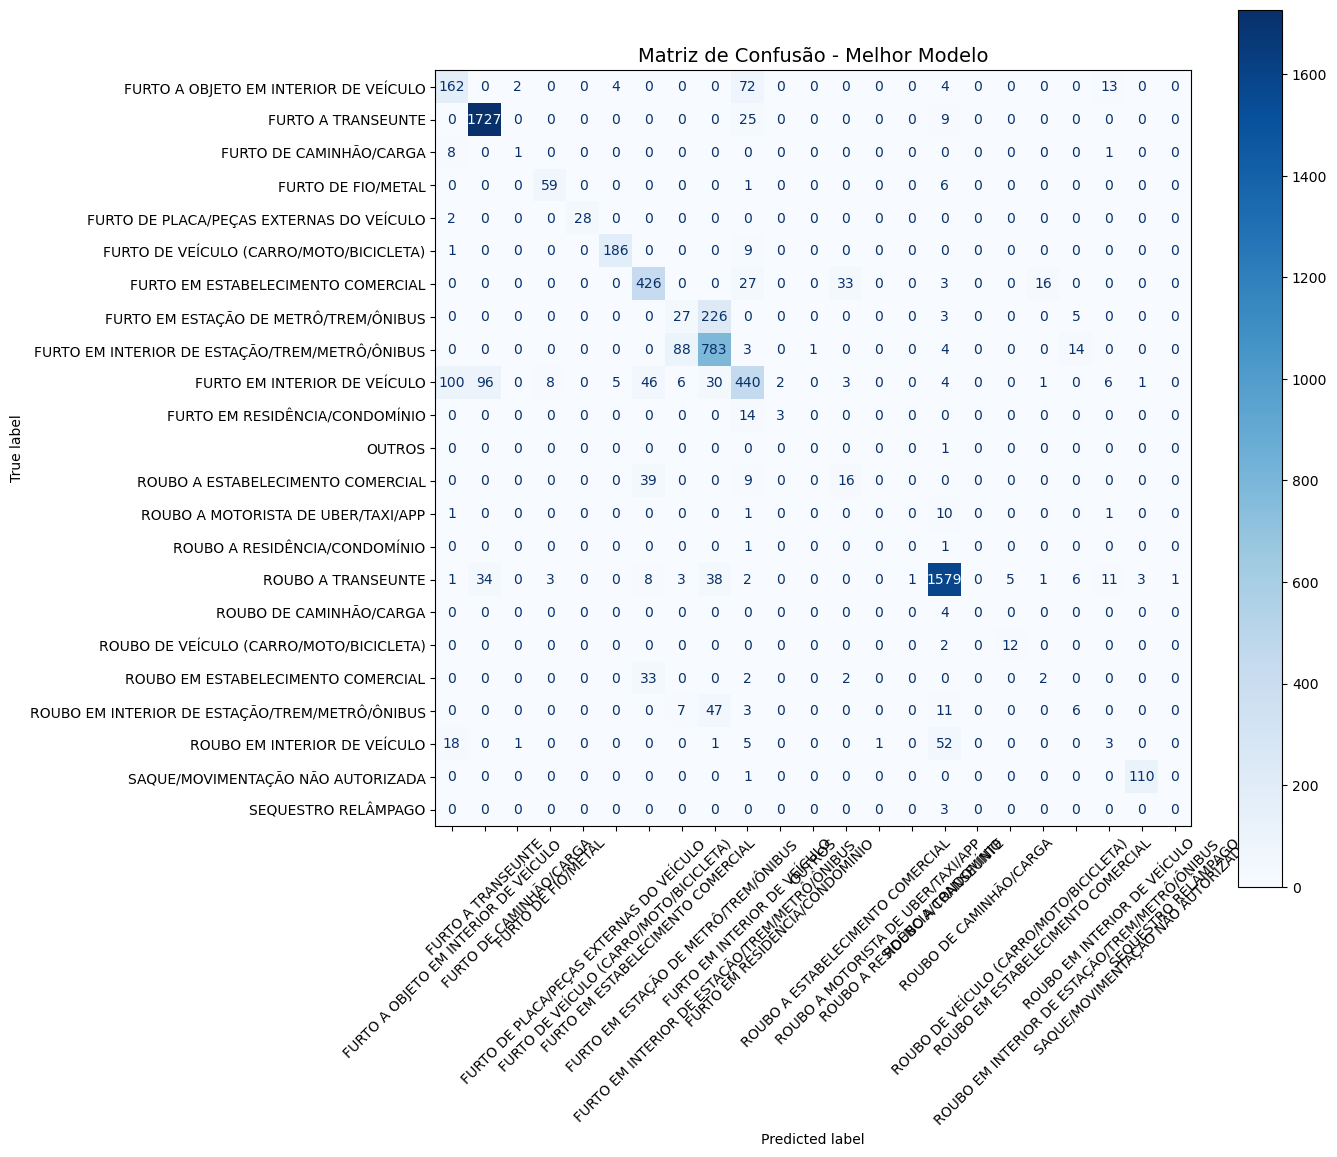

In [ ]:
%%timeit

warnings.filterwarnings("ignore")

df = pd.read_csv("crimes_sp_limpo.csv")

# ------------------------
# Limpeza básica + features derivadas
# ------------------------
df["DATA_OCORRENCIA_BO"] = pd.to_datetime(df["DATA_OCORRENCIA_BO"], errors="coerce")
df["HORA"] = pd.to_datetime(df["HORA_OCORRENCIA_BO"], errors="coerce").dt.hour

try:
    df["DIA_SEMANA"] = df["DATA_OCORRENCIA_BO"].dt.day_name(locale="pt_BR")
except:
    dias_en_pt = {
        "Monday":"Segunda","Tuesday":"Terça","Wednesday":"Quarta",
        "Thursday":"Quinta","Friday":"Sexta","Saturday":"Sábado","Sunday":"Domingo"
    }
    df["DIA_SEMANA"] = df["DATA_OCORRENCIA_BO"].dt.day_name().map(dias_en_pt)

# Selecionar colunas de interesse
df = df[[
    "DIA_SEMANA", "HORA", "TIPO_LOCAL", "BAIRRO", "OBJETO_VISADO", "TIPO_CRIME"
]].copy()

# Padronizar strings (opcional, mas ajuda)
for c in ["DIA_SEMANA", "TIPO_LOCAL", "BAIRRO", "OBJETO_VISADO", "TIPO_CRIME"]:
    df[c] = df[c].astype(str).str.strip().str.upper()

# ------------------------
# Ajuste o limiar conforme seu volume (mínimo de ocorrências para manter a classe ex: 5, 10...)
# ------------------------
threshold = 5 
counts = df["TIPO_CRIME"].value_counts()
raras = counts[counts < threshold].index
df["TIPO_CRIME"] = df["TIPO_CRIME"].where(~df["TIPO_CRIME"].isin(raras), "OUTROS")

counts = df["TIPO_CRIME"].value_counts()
min_class = counts.min()


# ------------------------
# Definindo X, y
# ------------------------
X = df[["DIA_SEMANA", "HORA", "TIPO_LOCAL", "BAIRRO", "OBJETO_VISADO"]]
y = df["TIPO_CRIME"]

# ------------------------
# Pré-processamento
# ------------------------
num_cols = ["HORA"]
cat_cols = ["DIA_SEMANA", "TIPO_LOCAL", "BAIRRO", "OBJETO_VISADO"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

# ------------------------
# Pipeline base
# ------------------------
pipe = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000,random_state=42))  # placeholder, será substituído no GridSearch
])

# ------------------------
# Grid de modelos
# ------------------------
param_grid = [
    {
        "clf": [LogisticRegression(max_iter=2000,random_state=42)],
        "clf__C": [0.1, 1, 10],
        "clf__class_weight": [None, "balanced"]
    },
    {
        "clf": [RandomForestClassifier(random_state=42)],
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [10, None],
        "clf__min_samples_split": [2, 5]
    },
    {
        "clf": [GradientBoostingClassifier(random_state=42)],
        "clf__n_estimators": [200, 400],
        "clf__learning_rate": [0.05, 0.1],
        "clf__max_depth": [2, 3]
    },
    {
        "clf": [SVC()],
        "clf__kernel": ["linear", "rbf"],
        "clf__C": [1, 10],
        "clf__class_weight": [None, "balanced"]
    }
]

# ------------------------
# Split treino/teste + Cross-Validation 
# ------------------------
# Para o split estratificado, cada classe precisa ter pelo menos 2 ocorrências.
# Para o StratifiedKFold, cada classe precisa ter pelo menos n_splits ocorrências.

# Garantir split estratificado viável
if min_class < 2:
    classes_1 = counts[counts < 2].index
    df = df[~df["TIPO_CRIME"].isin(classes_1)].copy()
    X = df[["DIA_SEMANA", "HORA", "TIPO_LOCAL", "BAIRRO", "OBJETO_VISADO"]]
    y = df["TIPO_CRIME"]
    counts = y.value_counts()
    min_class = counts.min()

# Definir número de folds máximo possível
n_splits = int(min(5, min_class))
n_splits = max(n_splits, 3)  # pelo menos 3

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42 # 30% teste
)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
print(f"Usando StratifiedKFold com n_splits={n_splits}")

# ------------------------
# GridSearch
# ------------------------
grid = GridSearchCV(
    pipe,
    param_grid,
    scoring="f1_macro",   # bom p/ classes desbalanceadas como nosso dataset
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\n Melhor modelo:", grid.best_estimator_)
print("\n Melhores parâmetros:", grid.best_params_)
print("\n Score de validação (CV):", grid.best_score_)
print("\n Métricas no conjunto de teste:", grid.cv_results_)

# ------------------------
# Avaliação no teste
# ------------------------
y_pred = grid.predict(X_test)
print("\n Relatório de classificação (teste):\n")
print(classification_report(y_test, y_pred))

# Matriz de confusão
plt.figure()
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusão - Melhor Modelo", fontsize=14)
plt.gcf().set_size_inches(14, 12) 
plt.tight_layout()
plt.show()

# ------------------------
# Importância de features
# ------------------------
best_model = grid.best_estimator_.named_steps["clf"]

# Nomes das colunas pós-transform
ohe = grid.best_estimator_.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

if hasattr(best_model, "feature_importances_"):
    importances = pd.Series(best_model.feature_importances_, index=feature_names)
    topk = importances.nlargest(15)
    plt.figure(figsize=(30,20), dpi=300)
    topk.sort_values().plot(kind="barh")
    plt.title("Top 15 Features mais importantes", fontsize=14)
    plt.tick_params(labelsize=40)
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, "coef_"):
    # Para modelos lineares/multiclasse (one-vs-rest): mostrar média do |coef|
    coef = np.mean(np.abs(best_model.coef_), axis=0) if best_model.coef_.ndim > 1 else np.abs(best_model.coef_)
    importances = pd.Series(coef, index=feature_names)
    topk = importances.nlargest(15)
    plt.figure(figsize=(30,20), dpi=300)
    topk.sort_values().plot(kind="barh")
    plt.title("Top 15 Features (|coef|) - Modelo Linear")
    plt.tick_params(labelsize=40)
    plt.tight_layout()
    plt.show()
else:
    print("O melhor modelo não expõe importâncias de feature (ex.: SVC com kernel RBF).")


Notamos que o modelo fica confuso por serem valores parecidos como Furto a Transeunte e Roubo a Transeunte, logo optamos por juntar para Furto/Roubo a Transeunte

In [91]:
data['TIPO_CRIME'].value_counts()

TIPO_CRIME
furto a transeunte                                5870
roubo a transeunte                                5654
furto em interior de estação/trem/metrô/ônibus    2976
furto em interior de veículo                      2492
furto em estabelecimento comercial                1683
furto em estação de metrô/trem/ônibus              870
furto a objeto em interior de veículo              857
furto de veículo (carro/moto/bicicleta)            653
saque/movimentação não autorizada                  369
roubo em interior de veículo                       269
roubo em interior de estação/trem/metrô/ônibus     247
furto de fio/metal                                 221
roubo a estabelecimento comercial                  214
roubo em estabelecimento comercial                 130
furto de placa/peças externas do veículo           101
furto em residência/condomínio                      56
roubo de veículo (carro/moto/bicicleta)             47
roubo a motorista de uber/taxi/app                  42

In [92]:
substituicoes = {
    'furto a transeunte': 'furto/roubo a transeunte',
    'roubo a transeunte': 'furto/roubo a transeunte',
    'furto em interior de estação/trem/metrô/ônibus': 'furto/roubo em estação/trem/metrô/ônibus',
    'roubo em interior de estação/trem/metrô/ônibus': 'furto/roubo em estação/trem/metrô/ônibus',
    'roubo em ponto de ônibus': 'furto/roubo em estação/trem/metrô/ônibus',
    'furto em estação de metrô/trem/ônibus': 'furto/roubo em estação/trem/metrô/ônibus',
    'roubo em estação de metrô/trem/ônibus': 'furto/roubo em estação/trem/metrô/ônibus',
    'roubo de veículo (carro/moto/bicicleta)': 'furto/roubo de veículo (carro/moto/bicicleta)',
    'furto de veículo (carro/moto/bicicleta)': 'furto/roubo de veículo (carro/moto/bicicleta)',
    'furto de caminhão/carga': 'furto/roubo de caminhão/carga',
    'roubo de caminhão/carga': 'furto/roubo de caminhão/carga',
    'furto em residência/condomínio' : 'furto/roubo em residência/condomínio',
    'roubo a residência/condomínio' : 'furto/roubo em residência/condomínio',
    'roubo em residência/condomínio' : 'furto/roubo em residência/condomínio',
    'roubo a estabelecimento comercial': 'furto/roubo em estabelecimento comercial',
    'roubo em estabelecimento comercial': 'furto/roubo em estabelecimento comercial',
    'furto em estabelecimento comercial': 'furto/roubo em estabelecimento comercial',
    'roubo em interior de veículo': 'furto/roubo em interior de veículo',
    'furto em interior de veículo': 'furto/roubo em interior de veículo'
    
}
data.loc[:, 'TIPO_CRIME'] = data['TIPO_CRIME'].replace(substituicoes)

In [93]:
data.to_csv('crimes_sp_limpo2.csv', index=False)

treinando com os crimes agrupados

Usando StratifiedKFold com n_splits=10
Fitting 10 folds for each of 1896 candidates, totalling 18960 fits

 Melhor modelo: Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  StandardScaler(with_mean=False),
                                                  ['HORA']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DIA_SEMANA', 'BAIRRO'])])),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', probability=True,
                     random_state=42))])

 Melhores parâmetros: {'clf': SVC(probability=True, random_state=42), 'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__decision_function_shape': 'ovr', 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

 Score de validação (CV): 0.23462197125583337

 Resultados de validação (CV):: {'mea

<Figure size 640x480 with 0 Axes>

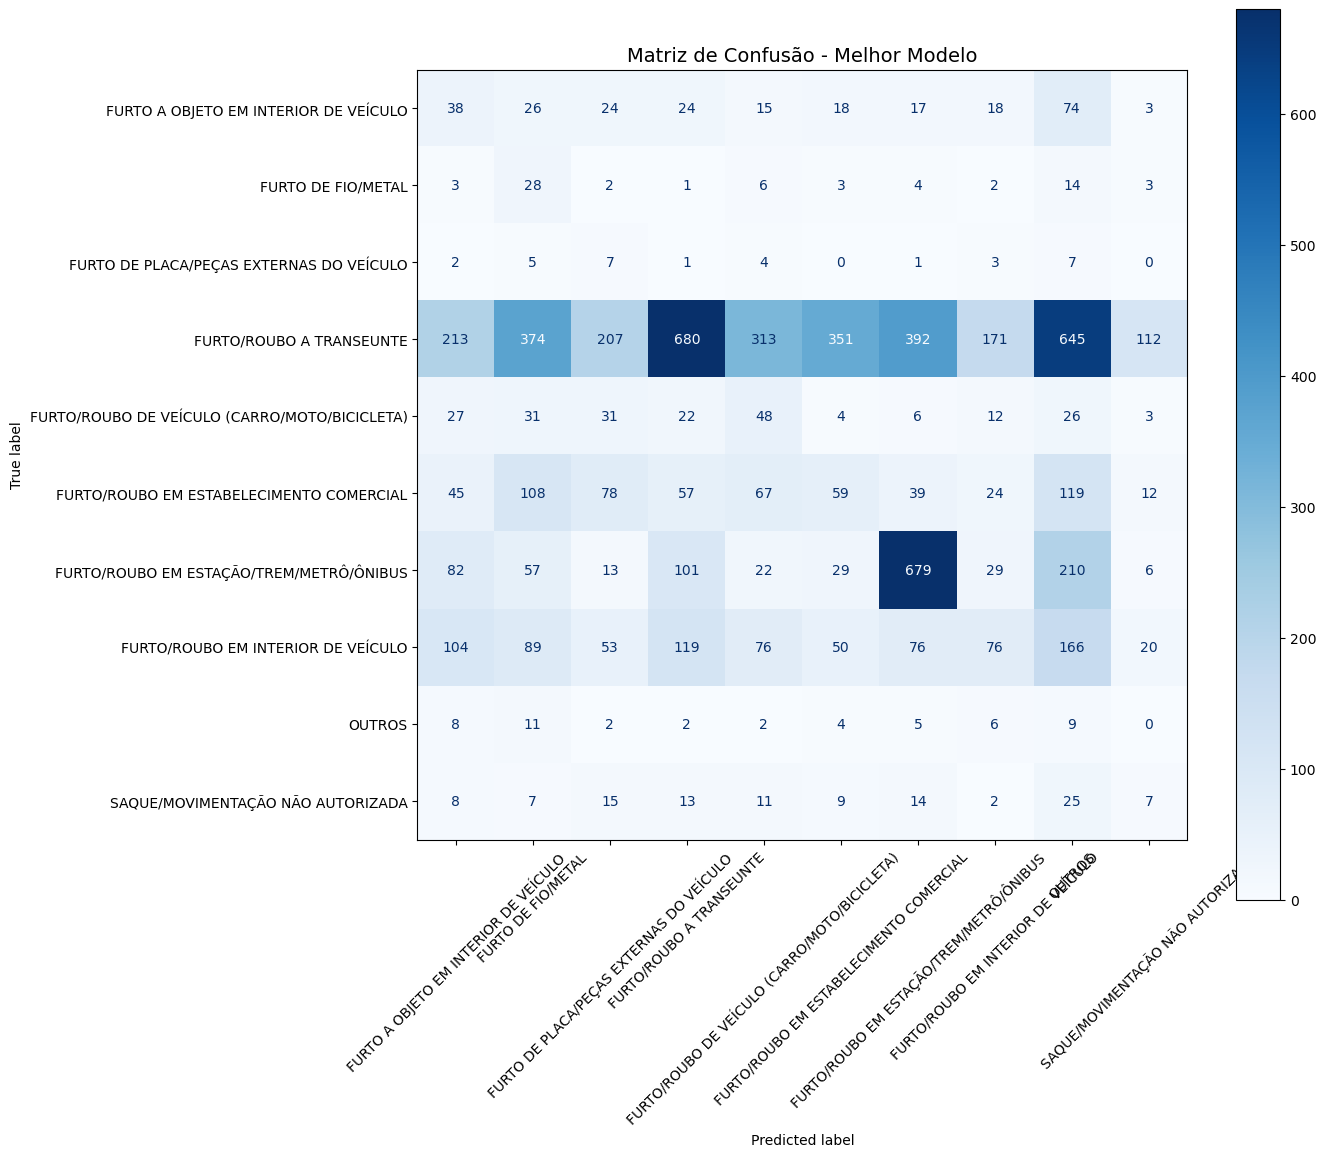

O melhor modelo não expõe importâncias de feature (ex.: SVC com kernel RBF).


['modelo_20251005_190209.pkl']

In [3]:

from datetime import datetime


warnings.filterwarnings("ignore")

df = pd.read_csv("crimes_sp_limpo2.csv")

# ------------------------
# Limpeza básica + features derivadas
# ------------------------
df["DATA_OCORRENCIA_BO"] = pd.to_datetime(df["DATA_OCORRENCIA_BO"], errors="coerce")
df["HORA"] = pd.to_datetime(df["HORA_OCORRENCIA_BO"], errors="coerce").dt.hour

try:
    df["DIA_SEMANA"] = df["DATA_OCORRENCIA_BO"].dt.day_name(locale="pt_BR")
except:
    dias_en_pt = {
        "Monday":"Segunda","Tuesday":"Terça","Wednesday":"Quarta",
        "Thursday":"Quinta","Friday":"Sexta","Saturday":"Sábado","Sunday":"Domingo"
    }
    df["DIA_SEMANA"] = df["DATA_OCORRENCIA_BO"].dt.day_name().map(dias_en_pt)

# Selecionar colunas de interesse
df = df[[
    "DIA_SEMANA", "HORA", "BAIRRO", "TIPO_CRIME"
]].copy()

# Padronizar strings (opcional, mas ajuda)
for c in ["DIA_SEMANA", "BAIRRO", "TIPO_CRIME"]:
    df[c] = df[c].astype(str).str.strip().str.upper()

# ------------------------
# Ajuste o limiar conforme seu volume (mínimo de ocorrências para manter a classe ex: 5, 10...)
# ------------------------
threshold = 100
counts = df["TIPO_CRIME"].value_counts()
raras = counts[counts < threshold].index
df["TIPO_CRIME"] = df["TIPO_CRIME"].where(~df["TIPO_CRIME"].isin(raras), "OUTROS")

counts = df["TIPO_CRIME"].value_counts()
min_class = counts.min()


# ------------------------
# Definindo X, y
# ------------------------
X = df[["DIA_SEMANA", "HORA", "BAIRRO"]]
y = df["TIPO_CRIME"]

# ------------------------
# Pré-processamento
# ------------------------
num_cols = ["HORA"]
cat_cols = ["DIA_SEMANA", "BAIRRO"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

# ------------------------
# Pipeline base
# ------------------------
pipe = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])

# ------------------------
# Grid de modelos
# ------------------------
param_grid = [
    {
        "clf": [LogisticRegression(max_iter=5000, random_state=42, n_jobs=-1, multi_class="ovr")],
        "clf__penalty": ["l1", "l2"],
        "clf__C": [1, 1, 3, 10],
        "clf__class_weight": [None, "balanced"]
    },
    {
        "clf": [RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=True)],
        "clf__n_estimators": [200, 400, 500, 600, 1000],
        "clf__max_depth": [None, 10, 20, 40, 100, 200],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__max_features": ["sqrt", "log2"],
        "clf__class_weight": [None, "balanced", "balanced_subsample"],
        "clf__oob_score": [True], 
        "clf__bootstrap": [True]
    },
    {
        "clf": [GradientBoostingClassifier(random_state=42)],
        "clf__n_estimators": [100, 200, 300, 500],
        "clf__learning_rate": [0.05, 0.1, 0.2],
        "clf__max_depth": [2, 5, 10, 50, 100],
        "clf__min_samples_leaf": [1, 2, 5]
    },
    {
        "clf": [SVC(random_state=42, probability=True)],
        "clf__kernel": ["linear", "rbf"],
        "clf__C": [1e-3, 1e-2, 1e-1, 1, 10],
        "clf__gamma": ["scale", 1e-3, 1e-2, 1e-1],  
        "clf__class_weight": [None, "balanced"],
        "clf__decision_function_shape": ["ovr"]
    }

]

# ------------------------
# Split treino/teste + Cross-Validation 
# ------------------------
# Para o split estratificado, cada classe precisa ter pelo menos 2 ocorrências.
# Para o StratifiedKFold, cada classe precisa ter pelo menos n_splits ocorrências.

# Garantir split estratificado viável
if min_class < 100:
    classes_1 = counts[counts < 100].index
    df = df[~df["TIPO_CRIME"].isin(classes_1)].copy()
    X = df[["DIA_SEMANA", "HORA", "BAIRRO"]]
    y = df["TIPO_CRIME"]
    counts = y.value_counts()
    min_class = counts.min()

# Definir número de folds máximo possível
n_splits = int(min(10, min_class))
n_splits = max(n_splits, 3)  # pelo menos 3

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42 # 30% teste
)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
print(f"Usando StratifiedKFold com n_splits={n_splits}")

# ------------------------
# GridSearch
# ------------------------
grid = GridSearchCV(
    pipe,
    param_grid,
    scoring="balanced_accuracy",   # bom p/ classes desbalanceadas como nosso dataset
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\n Melhor modelo:", grid.best_estimator_)
print("\n Melhores parâmetros:", grid.best_params_)
print("\n Score de validação (CV):", grid.best_score_)
print("\n Resultados de validação (CV)::", grid.cv_results_)

# ------------------------
# Avaliação no teste
# ------------------------
y_pred = grid.predict(X_test)
print("\n Relatório de classificação (teste):\n")
print(classification_report(y_test, y_pred))

# Matriz de confusão
plt.figure()
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusão - Melhor Modelo", fontsize=14)
plt.gcf().set_size_inches(14, 12) 
plt.tight_layout()
plt.show()

# ------------------------
# Importância de features
# ------------------------
best_model = grid.best_estimator_.named_steps["clf"]

# Nomes das colunas pós-transform
ohe = grid.best_estimator_.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

if hasattr(best_model, "feature_importances_"):
    importances = pd.Series(best_model.feature_importances_, index=feature_names)
    topk = importances.nlargest(10)
    plt.figure(figsize=(30,20), dpi=300)
    topk.sort_values().plot(kind="barh")
    plt.title("Top 10 Features mais importantes", fontsize=14)
    plt.tick_params(labelsize=40)
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, "coef_"):
    # Para modelos lineares/multiclasse (one-vs-rest): mostrar média do |coef|
    coef = np.mean(np.abs(best_model.coef_), axis=0) if best_model.coef_.ndim > 1 else np.abs(best_model.coef_)
    importances = pd.Series(coef, index=feature_names)
    topk = importances.nlargest(10)
    plt.figure(figsize=(30,20), dpi=300)
    topk.sort_values().plot(kind="barh")
    plt.title("Top 10 Features (|coef|) - Modelo Linear")
    plt.tick_params(labelsize=40)
    plt.tight_layout()
    plt.show()
else:
    print("O melhor modelo não expõe importâncias de feature (ex.: SVC com kernel RBF).")
    
# Gera nome do arquivo com data/hora atual
now_str = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"modelo_{now_str}.pkl"

joblib.dump(grid.best_estimator_, model_filename, compress=3)

In [8]:
df['TIPO_CRIME'].value_counts()

TIPO_CRIME
FURTO/ROUBO A TRANSEUNTE                         11524
FURTO/ROUBO EM ESTAÇÃO/TREM/METRÔ/ÔNIBUS          4094
FURTO/ROUBO EM INTERIOR DE VEÍCULO                2761
FURTO/ROUBO EM ESTABELECIMENTO COMERCIAL          2027
FURTO A OBJETO EM INTERIOR DE VEÍCULO              857
FURTO/ROUBO DE VEÍCULO (CARRO/MOTO/BICICLETA)      700
SAQUE/MOVIMENTAÇÃO NÃO AUTORIZADA                  369
FURTO DE FIO/METAL                                 221
FURTO DE PLACA/PEÇAS EXTERNAS DO VEÍCULO           101
FURTO/ROUBO EM RESIDÊNCIA/CONDOMÍNIO                63
FURTO/ROUBO DE CAMINHÃO/CARGA                       45
ROUBO A MOTORISTA DE UBER/TAXI/APP                  42
Name: count, dtype: int64

In [6]:
# salvar modelo
modelo = joblib.dump(grid.best_estimator_, "modelo_crimes2.pkl", compress=3)
#joblib.dump(modelo, "modelo_compressed.pkl", compress=3) # compressão para diminuir tamanho do arquivo

-----

Previsão com dados novos

In [13]:
modelo = joblib.load("modelo_20251005_190209.pkl")

novo = pd.DataFrame([{
    "DIA_SEMANA": "QUARTA",      # igual ao padrão do treino
    "HORA": 10,
    "BAIRRO": "SE"  # cuidado com acentos/capitalização conforme treino
}])

modelo.predict(novo)


array(['FURTO A OBJETO EM INTERIOR DE VEÍCULO'], dtype=object)

In [40]:
print(grid.cv_results_['std_test_score'] * 100)

[       nan 0.37875249        nan ... 2.78533778 2.91462345 3.36315711]


In [44]:
print(pontuacoes_dict)

{'mean_fit_time': array([2.02635765e-02, 2.40963125e-01, 1.30066633e-02, ...,
       1.78179775e+02, 2.19630405e+02, 1.64195095e+02]), 'std_fit_time': array([7.52473425e-03, 3.69833526e-02, 4.88123986e-03, ...,
       3.70410507e+00, 3.16269475e+01, 1.14952704e+01]), 'mean_score_time': array([0.        , 0.0090245 , 0.        , ..., 1.29963777, 1.08590593,
       1.16623116]), 'std_score_time': array([0.        , 0.00349709, 0.        , ..., 0.05416916, 0.0345186 ,
       0.24774397]), 'param_clf': masked_array(data=[LogisticRegression(max_iter=5000, multi_class='ovr', n_jobs=-1, random_state=42),
                   LogisticRegression(max_iter=5000, multi_class='ovr', n_jobs=-1, random_state=42),
                   LogisticRegression(max_iter=5000, multi_class='ovr', n_jobs=-1, random_state=42),
                   ..., SVC(probability=True, random_state=42),
                   SVC(probability=True, random_state=42),
                   SVC(probability=True, random_state=42)],
          

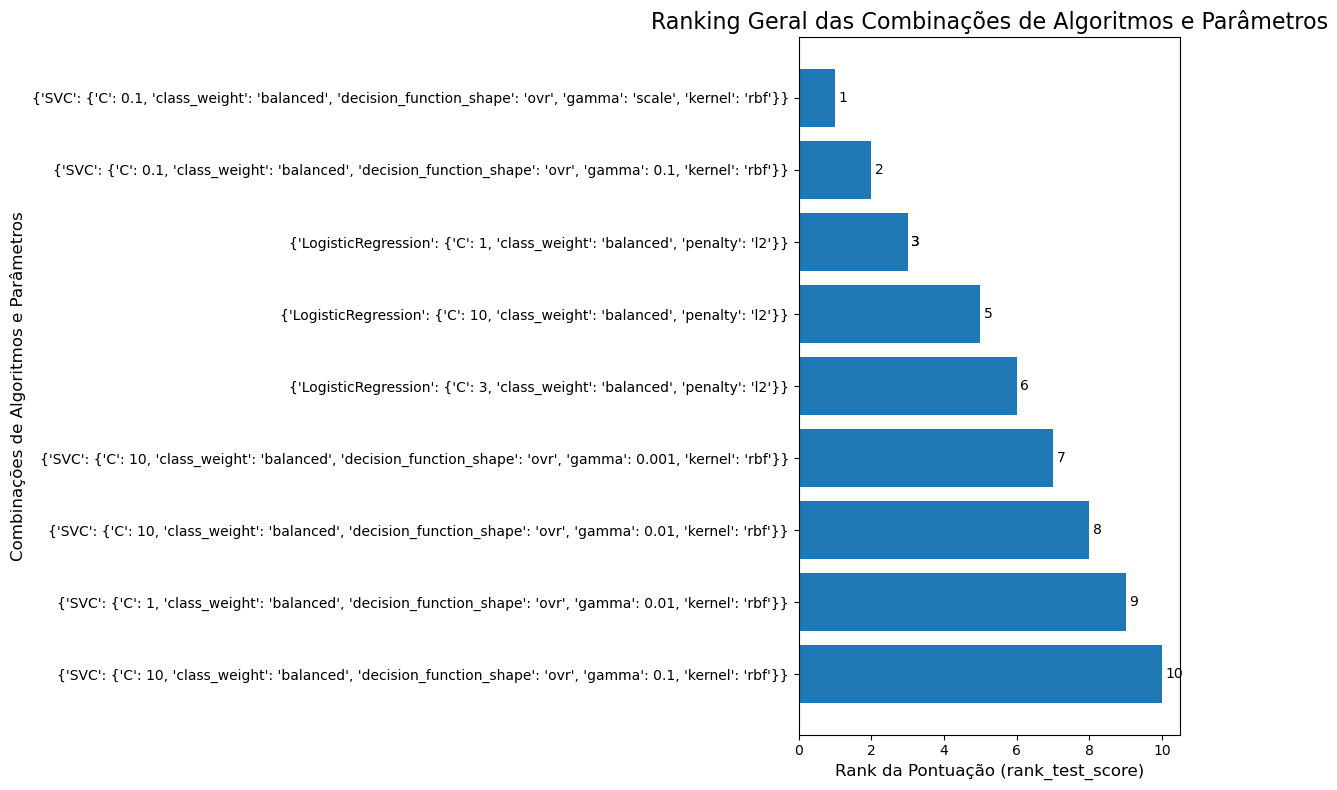

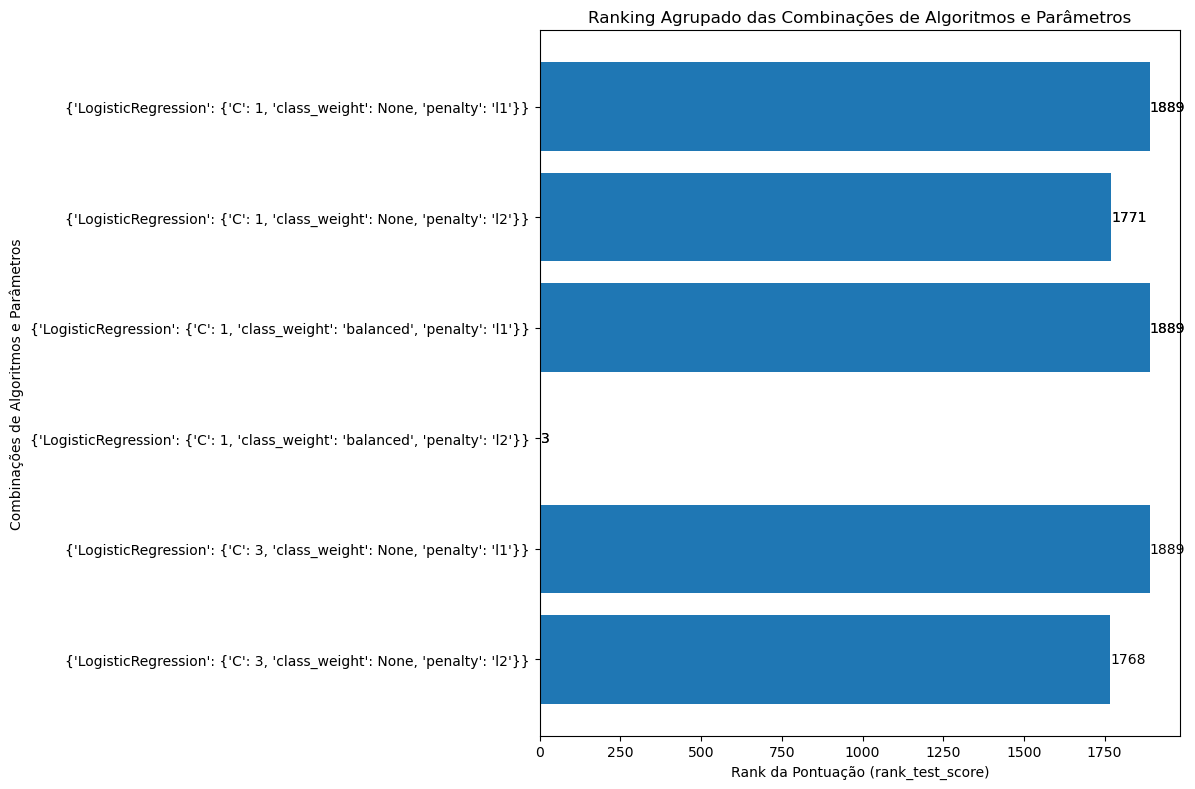

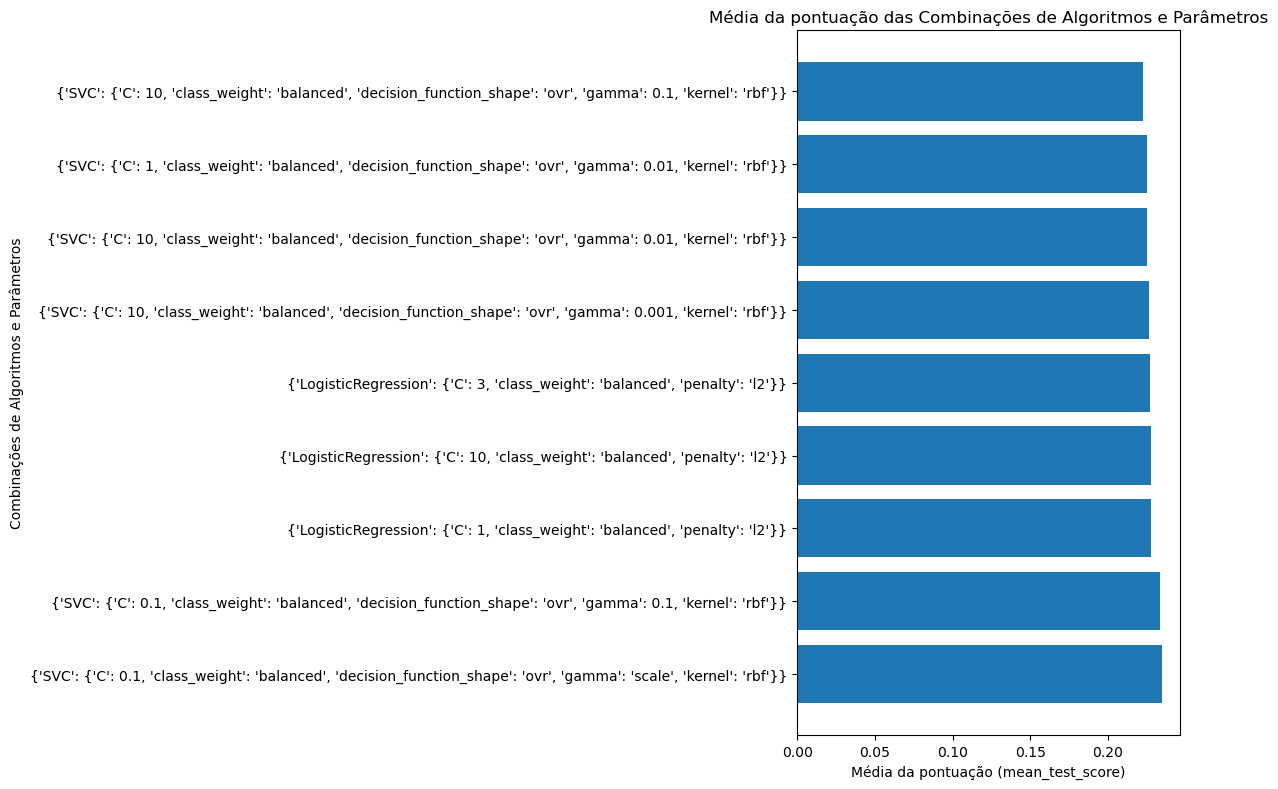

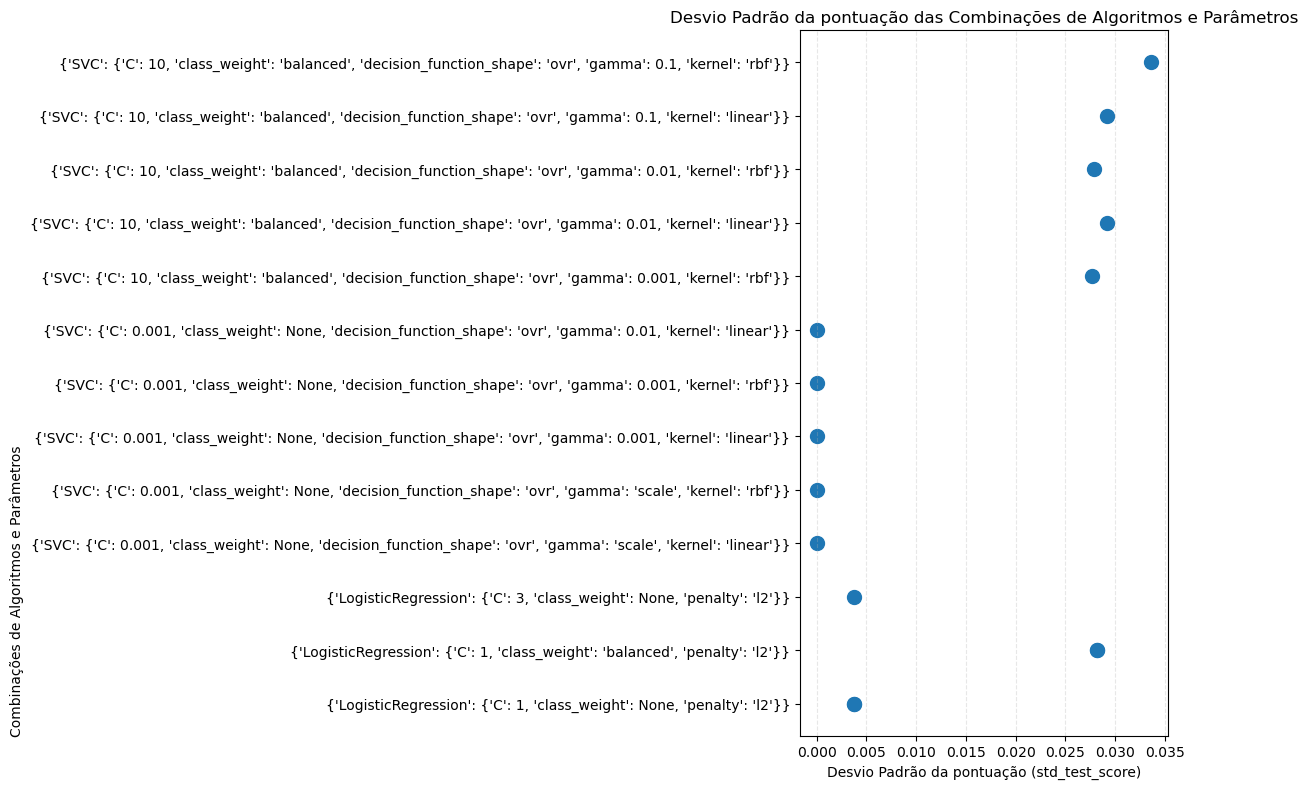

In [146]:
# ------------------------
# Ranking Geral das Combinações
# ------------------------

# cópia profunda para não alterar o dicionário original do grid
pontuacoes_dict = copy.deepcopy(grid.cv_results_)
pontuacoes_new_dicts = []

# criando dicionários mais limpos para legibilidade e adicionando em uma lista
for dic in pontuacoes_dict['params']:
    dic['clf'] = str(dic['clf'])
    if dic['clf'][0] == 'L':
        dic['clf'] = dic['clf'][:18]
    elif dic['clf'][0] == 'R':
        dic['clf'] = dic['clf'][:22]   
    elif dic['clf'][0] == 'G':
        dic['clf'] = dic['clf'][:26]
    elif dic['clf'][0] == 'S':
        dic['clf'] = dic['clf'][:3]
        
    dic = {key.replace('clf__', ''): value for key, value in dic.items()}
    pontuacoes_new_dict = dict()
    pontuacoes_new_dict[dic['clf']] = {key: value for key, value in dic.items() if key != 'clf'}
    pontuacoes_new_dicts.append(pontuacoes_new_dict)

# adicionando a lista criada em uma nova chave com os parâmetros limpos nos resultados, o "pontuacoes_dict"  
pontuacoes_dict['clean_params'] = pontuacoes_new_dicts

pontuacoes_df = pd.DataFrame(pontuacoes_dict).sort_values('rank_test_score')

parametros = pontuacoes_df['clean_params'].astype(str)[:10]
ranks = pontuacoes_df['rank_test_score'][:10]

plt.figure(figsize=(12, 8))
barras = plt.barh(parametros, ranks)
plt.xlabel('Rank da Pontuação (rank_test_score)', fontsize=12)
plt.ylabel('Combinações de Algoritmos e Parâmetros', fontsize=12)
plt.title('Ranking Geral das Combinações de Algoritmos e Parâmetros', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()

# Adiciona os valores dos ranks ao final das barras
for barra, rank in zip(barras, ranks):
    width = barra.get_width()
    plt.text(width + 0.1,               
             barra.get_y() + barra.get_height() / 2,
             f'{rank:.0f}',             
             va='center')

# ------------------------
# Ranking Agrupado das Combinações
# ------------------------

pontuacoes_df = pd.DataFrame(pontuacoes_dict)

parametros = pontuacoes_df['clean_params'].astype(str)[:10]
ranks = pontuacoes_df['rank_test_score'][:10]

plt.figure(figsize=(12, 8))
barras = plt.barh(parametros, ranks)
plt.xlabel('Rank da Pontuação (rank_test_score)', fontsize=10)
plt.ylabel('Combinações de Algoritmos e Parâmetros', fontsize=10)
plt.title('Ranking Agrupado das Combinações de Algoritmos e Parâmetros', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()

# Adiciona os valores dos ranks ao final das barras
for barra, rank in zip(barras, ranks):
    width = barra.get_width()
    plt.text(width + 0.1,               
             barra.get_y() + barra.get_height() / 2,  
             f'{rank:.0f}',             
             va='center')

# ------------------------
# Média dos Scores das Combinações
# ------------------------

pontuacoes_df = pd.DataFrame(pontuacoes_dict).sort_values('mean_test_score', ascending=False)

parametros = pontuacoes_df['clean_params'].astype(str)[:10]
media_scores = pontuacoes_df['mean_test_score'][:10]

plt.figure(figsize=(12, 8))
barras = plt.barh(parametros, media_scores)
plt.xlabel('Média da pontuação (mean_test_score)', fontsize=10)
plt.ylabel('Combinações de Algoritmos e Parâmetros', fontsize=10)
plt.title('Média da pontuação das Combinações de Algoritmos e Parâmetros', fontsize=12)
plt.tight_layout()

# ------------------------
# Desvio Padrão dos Scores das Combinações
# ------------------------

pontuacoes_df = pd.DataFrame(pontuacoes_dict) #.sort_values('std_test_score')
pontuacoes_df = pontuacoes_df.dropna(subset=['std_test_score'])

parametros = pontuacoes_df['clean_params'].astype(str)
desvio_padrao_scores = pontuacoes_df['std_test_score']

pd.set_option('display.max_colwidth', None)

tail = pontuacoes_df[['clean_params', 'std_test_score']].tail()
head = pontuacoes_df[['clean_params', 'std_test_score']].head()
body = pontuacoes_df[pontuacoes_df['std_test_score'] == 0.000000].head()
std_scores = pd.concat([head, body, tail])
table = std_scores[['clean_params', 'std_test_score']]
plt.figure(figsize=(12, 8))

y = table['clean_params'].astype(str)
x = table['std_test_score']
barras = plt.scatter(x, y, s=100)
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.xlabel('Desvio Padrão da pontuação (std_test_score)', fontsize=10)
plt.ylabel('Combinações de Algoritmos e Parâmetros', fontsize=10, loc='bottom')
plt.title('Desvio Padrão da pontuação das Combinações de Algoritmos e Parâmetros', fontsize=12)
plt.tight_layout()


